# **IE Sustainability Datathon 2023:** 01_EDA Analysis

## GENERAL CONFIG

### Modules & Libraries

In [18]:
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1
#!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.7 MB

In [1]:
import pandas as pd
import numpy as np
import pathlib

In [2]:
import datetime as dt
from ydata_profiling import ProfileReport
from math import *

In [3]:
# Viz ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm
import seaborn as sns
import plotly
import plotnine
from plotnine import *
#import patchworklib as pw
from mizani.formatters import date_format
from dateutil import tz

%matplotlib inline

In [4]:
from sklearn.preprocessing import OneHotEncoder

import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


In [5]:
pd.options.display.float_format = "{:,.2f}".format

### Prepared Functions

In [6]:
def miss_info(df_data):

    # MISSING VALUES INFO (BY COLUMNS)

    df_colsnan = pd.DataFrame()
    df_colsnan['dtypes'] = df_data.apply(lambda x: x.dtypes)
    df_colsnan['nan'] = df_data.isnull().sum()
    df_colsnan['perc_nan'] = (df_data.isnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_nan'] = df_colsnan['perc_nan'].round(2)
    df_colsnan['not_nan'] = df_data.notnull().sum()
    df_colsnan['perc_not_nan'] = (df_data.notnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_not_nan'] = df_colsnan['perc_not_nan'].round(2)

    for x in list(df_data.columns):
      zero_count = df_data[df_data[x]==0][x].count()
      df_colsnan.loc[x,'zero_values'] = zero_count

    df_colsnan['unique_values'] = df_data.apply(lambda x: len(x.unique()) )
    df_colsnan['neg_values'] = df_data.apply(lambda x: x.lt(0).sum() if x.dtypes == 'float64' else 'NA')
    df_colsnan.reset_index(inplace=True)
    df_colsnan.rename(columns={'index':'col_name'}, inplace=True)

    return df_colsnan

In [7]:
def cicl_tranf_diasem(df_input, col_diasem):

    nrows = df_input.shape[0]
    df_out = df_input.copy()
    df_out["DiaSem_SIN"] = ""
    df_out["DiaSem_COS"] = ""

    for i in range(0,nrows):
        dias_sem = {'Lunes':1, 'Martes':2, 'Miercoles':3, 'Jueves':4, 'Viernes':5, 'Sabado':6, 'Domingo':7}
        dia_sem = df_input[col_diasem][i]
        value_dia_sem = dias_sem[dia_sem]

        df_out.at[i, 'DiaSem_SIN'] = np.sin((value_dia_sem-1)*(2.*np.pi/7))
        df_out.at[i, 'DiaSem_COS'] = np.cos((value_dia_sem-1)*(2.*np.pi/7))

    df_out = df_out.astype({'DiaSem_SIN':'float64', 'DiaSem_COS':'float64'})

    return df_out

In [8]:
def cicl_tranf_month(df_input, col_month):

    nrows = df_input.shape[0]
    df_out = df_input.copy()
    df_out["Mes_SIN"] = ""
    df_out["Mes_COS"] = ""

    for i in range(0,nrows):
        month_i = df_input[col_month][i]

        df_out.at[i, 'Mes_SIN'] = np.sin((month_i-1)*(2.*np.pi/12))
        df_out.at[i, 'Mes_COS'] = np.cos((month_i-1)*(2.*np.pi/12))

    df_out = df_out.astype({'Mes_SIN':'float64', 'Mes_COS':'float64'})

    return df_out

In [9]:
def cicl_tranf_day(df_input, col_day, col_month, col_ano):

    nrows = df_input.shape[0]
    df_out = df_input.copy()
    df_out["Dia_SIN"] = ""
    df_out["Dia_COS"] = ""

    for i in range(0,nrows):
        day_i = df_input[col_day][i]
        month_i = df_input[col_month][i]
        ano_i = df_input[col_ano][i]

        month_31 = [1,3,5,7,8,10,12]
        month_30 = [4,6,9,11]
        month_28_29 = [2]

        ano_29 = []
        for x in range(2012,2500,4):
            ano_29.append(x)

        if month_i in month_31:
            df_out.at[i, 'Dia_SIN'] = np.sin((day_i-1)*(2.*np.pi/31))
            df_out.at[i, 'Dia_COS'] = np.cos((day_i-1)*(2.*np.pi/31))
        if month_i in month_30:
            df_out.at[i, 'Dia_SIN'] = np.sin((day_i-1)*(2.*np.pi/30))
            df_out.at[i, 'Dia_COS'] = np.cos((day_i-1)*(2.*np.pi/30))
        if month_i in month_28_29 and ano_i not in ano_29:
            df_out.at[i, 'Dia_SIN'] = np.sin((day_i-1)*(2.*np.pi/28))
            df_out.at[i, 'Dia_COS'] = np.cos((day_i-1)*(2.*np.pi/28))
        if month_i in month_28_29 and ano_i in ano_29:
            df_out.at[i, 'Dia_SIN'] = np.sin((day_i-1)*(2.*np.pi/29))
            df_out.at[i, 'Dia_COS'] = np.cos((day_i-1)*(2.*np.pi/29))

    df_out = df_out.astype({'Dia_SIN':'float64', 'Dia_COS':'float64'})

    return df_out

In [10]:
def cicl_tranf_15mins(df_input, col_time):

    nrows = df_input.shape[0]
    df_out = df_input.copy()
    df_out["Time_SIN"] = ""
    df_out["Time_COS"] = ""

    for i in range(0,nrows):
      mins_times = {'00:15:00':1, '00:30:00':2, '00:45:00':3, '01:00:00':4, '01:15:00':5,'01:30:00':6, '01:45:00':7, '02:00:00':8, '02:15:00':9, '02:30:00':10,
                    '02:45:00':11, '03:00:00':12, '03:15:00':13, '03:30:00':14, '03:45:00':15,'04:00:00':16, '04:15:00':17, '04:30:00':18, '04:45:00':19, '05:00:00':20,
                    '05:15:00':21, '05:30:00':22, '05:45:00':23, '06:00:00':24, '06:15:00':25,'06:30:00':26, '06:45:00':27, '07:00:00':28, '07:15:00':29, '07:30:00':30,
                    '07:45:00':31, '08:00:00':32, '08:15:00':33, '08:30:00':34, '08:45:00':35,'09:00:00':36, '09:15:00':37, '09:30:00':38, '09:45:00':39, '10:00:00':40,
                    '10:15:00':41, '10:30:00':42, '10:45:00':43, '11:00:00':44, '11:15:00':45,'11:30:00':46, '11:45:00':47, '12:00:00':48, '12:15:00':49, '12:30:00':50,
                    '12:45:00':51, '13:00:00':52, '13:15:00':53, '13:30:00':54, '13:45:00':55,'14:00:00':56, '14:15:00':57, '14:30:00':58, '14:45:00':59, '15:00:00':60,
                    '15:15:00':61, '15:30:00':62, '15:45:00':63, '16:00:00':64, '16:15:00':65,'16:30:00':66, '16:45:00':67, '17:00:00':68, '17:15:00':69, '17:30:00':70,
                    '17:45:00':71, '18:00:00':72, '18:15:00':73, '18:30:00':74, '18:45:00':75,'19:00:00':76, '19:15:00':77, '19:30:00':78, '19:45:00':79, '20:00:00':80,
                    '20:15:00':81, '20:30:00':82, '20:45:00':83, '21:00:00':84, '21:15:00':85,'21:30:00':86, '21:45:00':87, '22:00:00':88, '22:15:00':89, '22:30:00':90,
                    '22:45:00':91, '23:00:00':92, '23:15:00':93, '23:30:00':94, '23:45:00':95,'00:00:00':96
                    }

      min_time = df_input[col_time][i]
      value_min_time = mins_times[min_time]

      df_out.at[i, 'Time_SIN'] = np.sin((value_min_time-1)*(2.*np.pi/96))
      df_out.at[i, 'Time_COS'] = np.cos((value_min_time-1)*(2.*np.pi/96))

    df_out = df_out.astype({'Time_SIN':'float64', 'Time_COS':'float64'})

    return df_out

In [11]:
def RowKey_transf(x):
    myDate = str(x.date())
    return dt.datetime.strptime(myDate, '%Y-%m-%d').strftime('%Y-%m-%dT00:00:00.000Z')

In [12]:
def df_cols2rows(df_data, datetime_col):

  sel_cols = [x for x in list(df_data.columns) if x!=datetime_col]

  for x in sel_cols:

    ind_x = sel_cols.index(x)
    #col_name = 'V_' + x.replace(' ','-')

    if ind_x==0:
      df_viz = df_data[[datetime_col,x]].copy()
      df_viz.rename({x:'INF_Value'}, axis=1, inplace=True)
      df_viz['STA_Name'] = x
    else:
      df_aux = df_data[[datetime_col,x]].copy()
      df_aux.rename({x:'INF_Value'}, axis=1, inplace=True)
      df_aux.reset_index(drop=True, inplace=True)
      df_aux['STA_Name'] = x

      df_viz = pd.concat([df_viz,df_aux], axis=0)
      df_viz.reset_index(drop=True, inplace=True)

  return df_viz


 calcular el caudal de agua en una tubería de saneamiento basado en una diferencia de presión y el diámetro de la tubería, podemos usar una versión simplificada de la ley de Torricelli, que se deriva de la ecuación de Bernoulli para fluidos ideales. Asumiremos que la tubería tiene una sección transversal circular y que el flujo es turbulento.

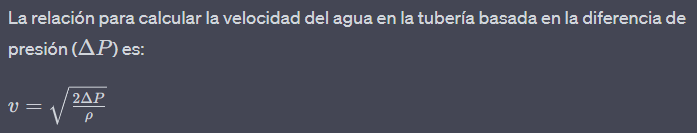

Donde:

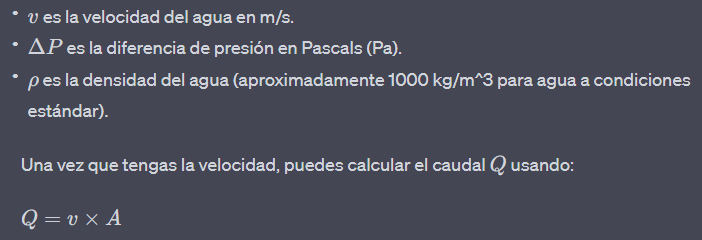


Donde:

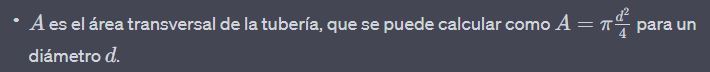


Combinando ambas ecuaciones, obtenemos:

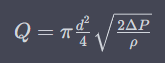


Recuerda que estas fórmulas son simplificaciones y pueden no reflejar completamente la realidad, especialmente en sistemas complejos donde hay factores adicionales como rugosidad de la tubería, cambios de dirección, y otros factores que pueden influir en el caudal real.


## LOADING DATASETS

### Preparing connection

In [13]:
from google.colab import drive
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


In [14]:
#folder_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/Datos IE'
folder_path = '/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE'

In [15]:
desktop = pathlib.Path(folder_path)
# .iterdir() produces a generator
desktop.iterdir()

<generator object Path.iterdir at 0x7bd6947eaf80>

In [16]:
# Which you can wrap in a list() constructor to materialize
files_list = list(desktop.iterdir())
files_list

[PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/cliente.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/contador.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/gis.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/clima.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/abonado.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/caudales.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/setDatos (1).zip'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/setDatos (1)_Dataset Information ACCIONA.pdf')]

In [17]:
files_list = [x for x in files_list if str(x).find('setDatos (1)')==-1]
files_list

[PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/cliente.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/contador.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/gis.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/clima.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/abonado.csv'),
 PosixPath('/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos IE/caudales.csv')]

In [18]:
df_dict = {}

for x in files_list:

    #df_name = str(x).split('\\')[-1]
    df_name = str(x).split('/')[-1]
    df_aux = pd.read_csv(x)

    df_dict[df_name] = df_aux


In [19]:
df_dict.keys()

dict_keys(['cliente.csv', 'contador.csv', 'gis.csv', 'clima.csv', 'abonado.csv', 'caudales.csv'])

### Dataset 1: 'caudales'

This file contains information related to water consumption in the city of Villarubia (Service VR) for the time period between August 2021 and December 2022. These are the variables in caudales.csv dataset:

- Canonical: Indicates the type of element from which the measurement is obtained.
- RowKey: Date and time when the measurement was made.
- INF_Label: Specific information about the canonical.
- INF_Value: Value of the measurement.
- STA_Label: Identification number of the Neta sector and the canonical.
- Sector_Neta: Indicates the sector where the element is located.

Note that only the water supply services of Villarubia need to be considered for analysis and forecasting. Also, pay attention to the frequency of measurements.

In [20]:
df1 = df_dict['caudales.csv'].copy()
df1

Canonical                    RowKey  \
0                      DEPOSITO  2021-08-01T00:15:00.000Z   
1                      DEPOSITO  2021-08-01T00:30:00.000Z   
2                      DEPOSITO  2021-08-01T00:45:00.000Z   
3                      DEPOSITO  2021-08-01T01:00:00.000Z   
4                      DEPOSITO  2021-08-01T01:15:00.000Z   
...                         ...                       ...   
1024222                DEPOSITO  2022-12-12T08:00:00.000Z   
1024223  DEPOSITO_CAUDAL_SALIDA  2022-12-12T07:45:00.000Z   
1024224  DEPOSITO_CAUDAL_SALIDA  2022-12-12T08:00:00.000Z   
1024225         DEPOSITO_METROS  2022-12-12T07:45:00.000Z   
1024226         DEPOSITO_METROS  2022-12-12T08:00:00.000Z   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  
0         CO:Nivel Deposito %      86.07  88001 Deposito     22880010  
1         CO:Nivel Deposito %      86.24  88001 Deposito     22880010  
2         CO:Nivel Deposito %      86.42  88001 Deposito     22880010  
3         CO:Nivel Deposito %      86.77  88001 Deposito     22880010  
4         CO:Nivel Deposito %      86.94  88001 Deposito     22880010  
...                       ...        ...             ...          ...  
1024222   CO:Nivel Deposito %      83.12  88001 Deposito     22880010  
1024223         Caudal Salida     120.00  88001 Deposito     22880010  
1024224         Caudal Salida     128.00  88001 Deposito     22880010  
1024225  AI: Nivel Deposito m       3.28  88001 Deposito     22880010  
1024226  AI: Nivel Deposito m       3.24  88001 Deposito     22880010  

[1024227 rows x 6 columns]

In [21]:
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Carretera Urda", "Carretera_Urda"))
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Sur Este", "Sur_Este"))
df1['STA_Code'] = df1['STA_Label'].apply(lambda x: x.split(' ')[0])
df1['STA_Name'] = df1['STA_Label'].apply(lambda x: x.split(' ')[1])
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Carretera_Urda", "Carretera Urda"))
df1['STA_Name'] = df1['STA_Name'].apply(lambda x: x.replace("Carretera_Urda", "Carretera Urda"))
df1['STA_Label'] = df1['STA_Label'].apply(lambda x: x.replace("Sur_Este", "Sur Este"))
df1['STA_Name'] = df1['STA_Name'].apply(lambda x: x.replace("Sur_Este", "Sur Este"))
df1

Canonical                    RowKey  \
0                      DEPOSITO  2021-08-01T00:15:00.000Z   
1                      DEPOSITO  2021-08-01T00:30:00.000Z   
2                      DEPOSITO  2021-08-01T00:45:00.000Z   
3                      DEPOSITO  2021-08-01T01:00:00.000Z   
4                      DEPOSITO  2021-08-01T01:15:00.000Z   
...                         ...                       ...   
1024222                DEPOSITO  2022-12-12T08:00:00.000Z   
1024223  DEPOSITO_CAUDAL_SALIDA  2022-12-12T07:45:00.000Z   
1024224  DEPOSITO_CAUDAL_SALIDA  2022-12-12T08:00:00.000Z   
1024225         DEPOSITO_METROS  2022-12-12T07:45:00.000Z   
1024226         DEPOSITO_METROS  2022-12-12T08:00:00.000Z   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  \
0         CO:Nivel Deposito %      86.07  88001 Deposito     22880010   
1         CO:Nivel Deposito %      86.24  88001 Deposito     22880010   
2         CO:Nivel Deposito %      86.42  88001 Deposito     22880010   
3         CO:Nivel Deposito %      86.77  88001 Deposito     22880010   
4         CO:Nivel Deposito %      86.94  88001 Deposito     22880010   
...                       ...        ...             ...          ...   
1024222   CO:Nivel Deposito %      83.12  88001 Deposito     22880010   
1024223         Caudal Salida     120.00  88001 Deposito     22880010   
1024224         Caudal Salida     128.00  88001 Deposito     22880010   
1024225  AI: Nivel Deposito m       3.28  88001 Deposito     22880010   
1024226  AI: Nivel Deposito m       3.24  88001 Deposito     22880010   

        STA_Code  STA_Name  
0          88001  Deposito  
1          88001  Deposito  
2          88001  Deposito  
3          88001  Deposito  
4          88001  Deposito  
...          ...       ...  
1024222    88001  Deposito  
1024223    88001  Deposito  
1024224    88001  Deposito  
1024225    88001  Deposito  
1024226    88001  Deposito  

[1024227 rows x 8 columns]

In [22]:
df1['STA_Name'].unique()

array(['Deposito', 'Valladolid', 'Gasolinera', 'Churruca',
       'Carretera Urda', 'Planta', 'Centro', 'Sur Este', 'Poligono'],
      dtype=object)

In [23]:
miss_info(df1)

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  zero_values  \
0    Canonical   object    0      0.00  1024227        100.00         0.00   
1       RowKey   object    0      0.00  1024227        100.00         0.00   
2    INF_Label   object    0      0.00  1024227        100.00         0.00   
3    INF_Value  float64    0      0.00  1024227        100.00    64,742.00   
4    STA_Label   object    0      0.00  1024227        100.00         0.00   
5  Sector_Neta    int64    0      0.00  1024227        100.00         0.00   
6     STA_Code   object    0      0.00  1024227        100.00         0.00   
7     STA_Name   object    0      0.00  1024227        100.00         0.00   

   unique_values neg_values  
0             11         NA  
1          49167         NA  
2             16         NA  
3         242599          0  
4              9         NA  
5             13         NA  
6              9         NA  
7              9         NA

In [24]:
df1['Canonical'].unique()

array(['DEPOSITO', 'DEPOSITO_CAUDAL_SALIDA', 'MARCHA_POZO', 'TOTALIZADOR',
       'PRESION_ENTRADA_SECTOR', 'VOLUMEN_DIARIO', 'CAUDAL',
       'PRESION_SALIDA_SECTOR', 'VOLUMEN', 'DEPOSITO_METROS',
       'DEPOSITO_VOLUMEN_SALIDA'], dtype=object)

In [25]:
df1['INF_Label'].unique()

array(['CO:Nivel Deposito %', 'Caudal Salida', 'DO:Marcha_Pozo_7',
       'DO:Marcha_Pozo_8', 'LS Valladolid', 'LS Gasolinera',
       'LS Churruca', 'LS Urda', 'LS Planta', 'LS Centro', 'LS-V Sureste',
       'LS Poligono', 'AI: Nivel Deposito m', 'Volumen Salida',
       'DO:Marcha_Pozo_3', 'DO:Marcha_Pozo_5'], dtype=object)

In [26]:
df1['STA_Name'].unique()

array(['Deposito', 'Valladolid', 'Gasolinera', 'Churruca',
       'Carretera Urda', 'Planta', 'Centro', 'Sur Este', 'Poligono'],
      dtype=object)

In [27]:
sectors_list = list(df1['STA_Name'].unique())
#sectors_list = [x.replace(' ', '-') for x in sectors_list]
sectors_list.remove('Deposito')
#sectors_list.insert(len(sectors_list), 'Deposito')
sectors_list

['Valladolid',
 'Gasolinera',
 'Churruca',
 'Carretera Urda',
 'Planta',
 'Centro',
 'Sur Este',
 'Poligono']

In [28]:
df1['Sector_Neta'].unique()

array([22880010, 22770070, 22770080, 22120000, 22121000, 22130000,
       22110000, 22131000, 22132100, 22122000, 22122100, 22770030,
       22770050])

In [29]:
for x in list(df1['STA_Label'].unique()):
    for y in range(0,df1.shape[0]):

        if df1.loc[y,'STA_Label']==x:
          STA_Label = df1.loc[y,'STA_Label']
          Sector_Neta = df1.loc[y,'Sector_Neta']
          print(f'{STA_Label} / {Sector_Neta}')
          break


88001 Deposito / 22880010
12000 Valladolid / 22120000
12100 Gasolinera / 22121000
13000 Churruca / 22130000
11000 Carretera Urda / 22110000
13100 Planta / 22131000
13210 Centro / 22132100
12200 Sur Este / 22122000
12210 Poligono / 22122100


In [30]:
# DATE COLUMN
'''
RowKey
'''

# Column "FECHA_ALTA_SUMINISTRO"
df1['RowKey'] = pd.to_datetime(df1['RowKey'])


In [31]:
df1['RowKey_Date'] = df1['RowKey'].apply(lambda x: x.date())
df1['RowKey_Time'] = df1['RowKey'].apply(lambda x: x.time())

In [32]:
df1

Canonical                    RowKey  \
0                      DEPOSITO 2021-08-01 00:15:00+00:00   
1                      DEPOSITO 2021-08-01 00:30:00+00:00   
2                      DEPOSITO 2021-08-01 00:45:00+00:00   
3                      DEPOSITO 2021-08-01 01:00:00+00:00   
4                      DEPOSITO 2021-08-01 01:15:00+00:00   
...                         ...                       ...   
1024222                DEPOSITO 2022-12-12 08:00:00+00:00   
1024223  DEPOSITO_CAUDAL_SALIDA 2022-12-12 07:45:00+00:00   
1024224  DEPOSITO_CAUDAL_SALIDA 2022-12-12 08:00:00+00:00   
1024225         DEPOSITO_METROS 2022-12-12 07:45:00+00:00   
1024226         DEPOSITO_METROS 2022-12-12 08:00:00+00:00   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  \
0         CO:Nivel Deposito %      86.07  88001 Deposito     22880010   
1         CO:Nivel Deposito %      86.24  88001 Deposito     22880010   
2         CO:Nivel Deposito %      86.42  88001 Deposito     22880010   
3         CO:Nivel Deposito %      86.77  88001 Deposito     22880010   
4         CO:Nivel Deposito %      86.94  88001 Deposito     22880010   
...                       ...        ...             ...          ...   
1024222   CO:Nivel Deposito %      83.12  88001 Deposito     22880010   
1024223         Caudal Salida     120.00  88001 Deposito     22880010   
1024224         Caudal Salida     128.00  88001 Deposito     22880010   
1024225  AI: Nivel Deposito m       3.28  88001 Deposito     22880010   
1024226  AI: Nivel Deposito m       3.24  88001 Deposito     22880010   

        STA_Code  STA_Name RowKey_Date RowKey_Time  
0          88001  Deposito  2021-08-01    00:15:00  
1          88001  Deposito  2021-08-01    00:30:00  
2          88001  Deposito  2021-08-01    00:45:00  
3          88001  Deposito  2021-08-01    01:00:00  
4          88001  Deposito  2021-08-01    01:15:00  
...          ...       ...         ...         ...  
1024222    88001  Deposito  2022-12-12    08:00:00  
1024223    88001  Deposito  2022-12-12    07:45:00  
1024224    88001  Deposito  2022-12-12    08:00:00  
1024225    88001  Deposito  2022-12-12    07:45:00  
1024226    88001  Deposito  2022-12-12    08:00:00  

[1024227 rows x 10 columns]

In [33]:
# Column "FECHA_ALTA_SUMINISTRO"
df1['RowKey_Date'] = pd.to_datetime(df1['RowKey_Date'])

# Column "FECHA_ALTA_SUMINISTRO"
df1['RowKey_Time'] = df1['RowKey_Time'].apply(lambda x: str(x))
order = list(df1['RowKey_Time'].unique())
order.sort()
#print(order)
data = df1['RowKey_Time']
df1['RowKey_Time'] = pd.Categorical(data, order, ordered=True)


In [34]:
for i in range(0,df1.shape[0]):
    if df1.loc[i,'RowKey_Time']=='00:00:00':
        df1.loc[i,'RowKey_Date'] = df1.loc[i,'RowKey_Date'] - pd.DateOffset(days=1)

In [35]:
df1[df1['RowKey_Time']=='00:00:00']

Canonical                    RowKey  \
121                     DEPOSITO 2021-08-03 00:00:00+00:00   
235                     DEPOSITO 2021-08-05 00:00:00+00:00   
331                     DEPOSITO 2021-08-06 00:00:00+00:00   
427                     DEPOSITO 2021-08-07 00:00:00+00:00   
523                     DEPOSITO 2021-08-08 00:00:00+00:00   
...                          ...                       ...   
1016636  DEPOSITO_VOLUMEN_SALIDA 2022-12-05 00:00:00+00:00   
1016650                 DEPOSITO 2022-12-04 00:00:00+00:00   
1016654   DEPOSITO_CAUDAL_SALIDA 2022-12-04 00:00:00+00:00   
1016658          DEPOSITO_METROS 2022-12-04 00:00:00+00:00   
1016662  DEPOSITO_VOLUMEN_SALIDA 2022-12-04 00:00:00+00:00   

                    INF_Label  INF_Value       STA_Label  Sector_Neta  \
121       CO:Nivel Deposito %      72.16  88001 Deposito     22880010   
235       CO:Nivel Deposito %      91.81  88001 Deposito     22880010   
331       CO:Nivel Deposito %      88.33  88001 Deposito     22880010   
427       CO:Nivel Deposito %      87.63  88001 Deposito     22880010   
523       CO:Nivel Deposito %      83.12  88001 Deposito     22880010   
...                       ...        ...             ...          ...   
1016636        Volumen Salida   2,876.00  88001 Deposito     22880010   
1016650   CO:Nivel Deposito %      78.24  88001 Deposito     22880010   
1016654         Caudal Salida     100.00  88001 Deposito     22880010   
1016658  AI: Nivel Deposito m       3.05  88001 Deposito     22880010   
1016662        Volumen Salida   2,906.00  88001 Deposito     22880010   

        STA_Code  STA_Name RowKey_Date RowKey_Time  
121        88001  Deposito  2021-08-02    00:00:00  
235        88001  Deposito  2021-08-04    00:00:00  
331        88001  Deposito  2021-08-05    00:00:00  
427        88001  Deposito  2021-08-06    00:00:00  
523        88001  Deposito  2021-08-07    00:00:00  
...          ...       ...         ...         ...  
1016636    88001  Deposito  2022-12-04    00:00:00  
1016650    88001  Deposito  2022-12-03    00:00:00  
1016654    88001  Deposito  2022-12-03    00:00:00  
1016658    88001  Deposito  2022-12-03    00:00:00  
1016662    88001  Deposito  2022-12-03    00:00:00  

[13751 rows x 10 columns]

In [36]:
df1[df1['RowKey_Time']=='00:03:22']

Canonical                    RowKey         INF_Label  INF_Value  \
1008738  MARCHA_POZO 2022-08-29 00:03:22+00:00  DO:Marcha_Pozo_3       0.00   
1008739  MARCHA_POZO 2022-08-29 00:03:22+00:00  DO:Marcha_Pozo_5       0.00   
1008740  MARCHA_POZO 2022-08-29 00:03:22+00:00  DO:Marcha_Pozo_7       0.00   
1008741  MARCHA_POZO 2022-08-29 00:03:22+00:00  DO:Marcha_Pozo_8       0.00   

              STA_Label  Sector_Neta STA_Code  STA_Name RowKey_Date  \
1008738  88001 Deposito     22770030    88001  Deposito  2022-08-29   
1008739  88001 Deposito     22770050    88001  Deposito  2022-08-29   
1008740  88001 Deposito     22770070    88001  Deposito  2022-08-29   
1008741  88001 Deposito     22770080    88001  Deposito  2022-08-29   

        RowKey_Time  
1008738    00:03:22  
1008739    00:03:22  
1008740    00:03:22  
1008741    00:03:22

In [37]:
# CATEGORICAL NOMINAL
'''
Canonical
INF_Label
STA_Label
Sector_Neta
STA_Code
STA_Name
'''

# Column "Canonical"
data = df1['Canonical']
df1['Canonical'] = pd.Categorical(data, ordered=False)

# Column "INF_Label"
data = df1['INF_Label']
df1['INF_Label'] = pd.Categorical(data, ordered=False)

# Column "STA_Label"
data = df1['STA_Label']
df1['STA_Label'] = pd.Categorical(data, ordered=False)

# Column "Sector_Neta"
data = df1['Sector_Neta']
df1['Sector_Neta'] = pd.Categorical(data, ordered=False)

# Column "STA_code"
data = df1['STA_Code']
df1['STA_Code'] = pd.Categorical(data, ordered=False)

# Column "STA_name"
data = df1['STA_Name']
df1['STA_Name'] = pd.Categorical(data, ordered=False)


In [38]:
df1 = df1.sort_values(by=['STA_Name','Canonical','RowKey_Date']).reset_index(drop=True)
df1

Canonical                    RowKey      INF_Label  INF_Value  \
0                CAUDAL 2021-08-01 00:15:00+00:00        LS Urda       5.00   
1                CAUDAL 2021-08-01 00:30:00+00:00        LS Urda       4.72   
2                CAUDAL 2021-08-01 00:45:00+00:00        LS Urda       4.40   
3                CAUDAL 2021-08-01 01:00:00+00:00        LS Urda       4.00   
4                CAUDAL 2021-08-01 01:15:00+00:00        LS Urda       4.56   
...                 ...                       ...            ...        ...   
1024222  VOLUMEN_DIARIO 2022-12-08 00:00:00+00:00  LS Valladolid   1,028.90   
1024223  VOLUMEN_DIARIO 2022-12-09 00:00:00+00:00  LS Valladolid   1,046.60   
1024224  VOLUMEN_DIARIO 2022-12-10 00:00:00+00:00  LS Valladolid   1,053.50   
1024225  VOLUMEN_DIARIO 2022-12-11 00:00:00+00:00  LS Valladolid   1,082.30   
1024226  VOLUMEN_DIARIO 2022-12-12 00:00:00+00:00  LS Valladolid     983.30   

                    STA_Label Sector_Neta STA_Code        STA_Name  \
0        11000 Carretera Urda    22110000    11000  Carretera Urda   
1        11000 Carretera Urda    22110000    11000  Carretera Urda   
2        11000 Carretera Urda    22110000    11000  Carretera Urda   
3        11000 Carretera Urda    22110000    11000  Carretera Urda   
4        11000 Carretera Urda    22110000    11000  Carretera Urda   
...                       ...         ...      ...             ...   
1024222      12000 Valladolid    22120000    12000      Valladolid   
1024223      12000 Valladolid    22120000    12000      Valladolid   
1024224      12000 Valladolid    22120000    12000      Valladolid   
1024225      12000 Valladolid    22120000    12000      Valladolid   
1024226      12000 Valladolid    22120000    12000      Valladolid   

        RowKey_Date RowKey_Time  
0        2021-08-01    00:15:00  
1        2021-08-01    00:30:00  
2        2021-08-01    00:45:00  
3        2021-08-01    01:00:00  
4        2021-08-01    01:15:00  
...             ...         ...  
1024222  2022-12-07    00:00:00  
1024223  2022-12-08    00:00:00  
1024224  2022-12-09    00:00:00  
1024225  2022-12-10    00:00:00  
1024226  2022-12-11    00:00:00  

[1024227 rows x 10 columns]

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024227 entries, 0 to 1024226
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   Canonical    1024227 non-null  category           
 1   RowKey       1024227 non-null  datetime64[ns, UTC]
 2   INF_Label    1024227 non-null  category           
 3   INF_Value    1024227 non-null  float64            
 4   STA_Label    1024227 non-null  category           
 5   Sector_Neta  1024227 non-null  category           
 6   STA_Code     1024227 non-null  category           
 7   STA_Name     1024227 non-null  category           
 8   RowKey_Date  1024227 non-null  datetime64[ns]     
 9   RowKey_Time  1024227 non-null  category           
dtypes: category(7), datetime64[ns, UTC](1), datetime64[ns](1), float64(1)
memory usage: 31.3 MB


In [40]:
'''
profile = ProfileReport(df1, title="Profile_1-Caudales")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_1-Caudales.html")
'''

'\nprofile = ProfileReport(df1, title="Profile_1-Caudales")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_1-Caudales.html")\n'

### Dataset 2: 'gis.csv'

This file contains information related to the hierarchical and locational relationship of the elements that exist in the water supply service of Villarubia. GIS means Geographic Information System.

These are the variables in gis.cvs dataset:

- oid: Identifier of the service and Gis code.
- bissioCode: Sector code.
- Code: Gis (Geographic Information System) code.
- parentCode: code of the parent sector.
- Name: Name of the sector.
- Service: Service code. This code is always VR (Villarubia).


In [ ]:
df2 = df_dict['gis.csv'].copy()
df2

oid bissioCode      code    parentCode                name service
0   VR22110000          1  22110000 22,100,000.00   Carretera de Urda      VR
1   VR22120000          2  22120000 22,100,000.00          Valladolid      VR
2   VR22121000        2.1  22121000 22,120,000.00          Gasolinera      VR
3   VR22122900    2.2.1.9  22122900 22,122,000.00    Sur Este Virtual      VR
4   VR22132100      3.2.1  22132100 22,132,000.00              Centro      VR
5   VR22132900      3.2.9  22132900 22,132,000.00   Sur Oeste Virtual      VR
6   VR22100000        0.0  22100000           NaN             General      VR
7   VR22119000          0  22119000 22,100,000.00          Diferencia      VR
8   VR22122000        2.2  22122000 22,120,000.00            Sur Este      VR
9   VR22122100      2.2.1  22122100 22,122,000.00            Polígono      VR
10  VR22129000        2.9  22129000 22,120,000.00  Valladolid Virtual      VR
11  VR22130000          3  22130000 22,100,000.00            Churruca      VR
12  VR22131000        3.1  22131000 22,130,000.00              Planta      VR
13  VR22132000        3.2  22132000 22,130,000.00           Sur Oeste      VR
14  VR22139000        3.9  22139000 22,130,000.00    Churruca Virtual      VR

In [ ]:
sectors_list

['Valladolid',
 'Gasolinera',
 'Churruca',
 'Carretera Urda',
 'Planta',
 'Centro',
 'Sur Este',
 'Poligono']

In [ ]:
df2 = df2.sort_values(['oid'], axis=0)
df2['name'] = df2['name'].apply(lambda x: x.replace('Polígono', 'Poligono'))
df2['name'] = df2['name'].apply(lambda x: x.replace('Carretera de Urda', 'Carretera Urda'))
df2[df2['name'].isin(sectors_list)]

oid bissioCode      code    parentCode            name service
0   VR22110000          1  22110000 22,100,000.00  Carretera Urda      VR
1   VR22120000          2  22120000 22,100,000.00      Valladolid      VR
2   VR22121000        2.1  22121000 22,120,000.00      Gasolinera      VR
8   VR22122000        2.2  22122000 22,120,000.00        Sur Este      VR
9   VR22122100      2.2.1  22122100 22,122,000.00        Poligono      VR
11  VR22130000          3  22130000 22,100,000.00        Churruca      VR
12  VR22131000        3.1  22131000 22,130,000.00          Planta      VR
4   VR22132100      3.2.1  22132100 22,132,000.00          Centro      VR

In [ ]:
'''
88001 Deposito / 22880010
12000 Valladolid / 22120000 --
12100 Gasolinera / 22121000 --
13000 Churruca / 22130000 --
11000 Carretera Urda / 22110000 --
13100 Planta / 22131000 --
13210 Centro / 22132100 --
12200 Sur Este / 22122000 --
12210 Poligono / 22122100 --
'''

'\n88001 Deposito / 22880010\n12000 Valladolid / 22120000 --\n12100 Gasolinera / 22121000 --\n13000 Churruca / 22130000 --\n11000 Carretera Urda / 22110000 --\n13100 Planta / 22131000 --\n13210 Centro / 22132100 --\n12200 Sur Este / 22122000 --\n12210 Poligono / 22122100 --\n'

In [ ]:
miss_info(df2)

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  unique_values  \
0         oid   object    0      0.00       15        100.00             15   
1  bissioCode   object    0      0.00       15        100.00             15   
2        code    int64    0      0.00       15        100.00             15   
3  parentCode  float64    1      6.67       14         93.33              6   
4        name   object    0      0.00       15        100.00             15   
5     service   object    0      0.00       15        100.00              1   

  neg_values  
0         NA  
1         NA  
2         NA  
3          0  
4         NA  
5         NA

In [ ]:
df2['oid'].unique()

array(['VR22100000', 'VR22110000', 'VR22119000', 'VR22120000',
       'VR22121000', 'VR22122000', 'VR22122100', 'VR22122900',
       'VR22129000', 'VR22130000', 'VR22131000', 'VR22132000',
       'VR22132100', 'VR22132900', 'VR22139000'], dtype=object)

In [ ]:
df2['bissioCode'].unique()

array(['0.0', '1', '0', '2', '2.1', '2.2', '2.2.1', '2.2.1.9', '2.9', '3',
       '3.1', '3.2', '3.2.1', '3.2.9', '3.9'], dtype=object)

In [ ]:
df2['code'].unique()

array([22100000, 22110000, 22119000, 22120000, 22121000, 22122000,
       22122100, 22122900, 22129000, 22130000, 22131000, 22132000,
       22132100, 22132900, 22139000], dtype=int64)

In [ ]:
df2['parentCode'].unique()

array([      nan, 22100000., 22120000., 22122000., 22130000., 22132000.])

In [ ]:
# 'Carretera Urda','Valladolid','Gasolinera','Centro','Sur Este','Poligono','Churruca','Planta','Deposito'

In [ ]:
df2['name'].unique()

array(['General', 'Carretera Urda', 'Diferencia', 'Valladolid',
       'Gasolinera', 'Sur Este', 'Poligono', 'Sur Este Virtual',
       'Valladolid Virtual', 'Churruca', 'Planta', 'Sur Oeste', 'Centro',
       'Sur Oeste Virtual', 'Churruca Virtual'], dtype=object)

In [ ]:
df2['service'].unique()

array(['VR'], dtype=object)

In [ ]:
# CATEGORICAL NOMINAL
'''
ALL COLUMNS
'''

# Column "oid"
data = df2['oid']
df2['oid'] = pd.Categorical(data, ordered=False)

# Column "SECTOR"
data = df2['bissioCode']
df2['bissioCode'] = pd.Categorical(data, ordered=False)

# Column "COD_SUMINISTRO"
data = df2['code']
df2['code'] = pd.Categorical(data, ordered=False)

# Column "COD_TIPO_SUMINISTRO"
df2['parentCode'] = df2['parentCode'].astype(str).apply(lambda x: x.replace('.0',''))
data = df2['parentCode']
df2['parentCode'] = pd.Categorical(data, ordered=False)

# Column "COD_TIPO_SUMINISTRO"
data = df2['name']
df2['name'] = pd.Categorical(data, ordered=False)

# Column "COD_TIPO_SUMINISTRO"
data = df2['service']
df2['service'] = pd.Categorical(data, ordered=False)


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 6 to 14
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   oid         15 non-null     category
 1   bissioCode  15 non-null     category
 2   code        15 non-null     category
 3   parentCode  15 non-null     category
 4   name        15 non-null     category
 5   service     15 non-null     category
dtypes: category(6)
memory usage: 3.2 KB


In [ ]:
'''
profile = ProfileReport(df2, title="Profile_2-Gis")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_2-Gis.html")
'''

'\nprofile = ProfileReport(df2, title="Profile_2-Gis")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_2-Gis.html")\n'

### Dataset 3: 'abonado.csv'

This file contains information related to the provision of service in Villarubia. These are the variables in abonado.csv dataset:

- COD_CONCESION: Service code. This code is always VR (Villarubia).
- SECTOR: Sector code.
- COD_SUMINISTRO: Contract reference.
- FECHA_ALTA_SUMINISTRO: Contract start date
- FECHA_BAJA_SUMINISTRO: Contract termination date.
- COD_TIPO_SUMINISTRO: Type of supply.
- NUM_VIVIENDAS: Number of dwellings registered in the contract.
- NUM_PERSONAS: Number of people registered in the contract.

In [ ]:
df3 = df_dict['abonado.csv'].copy()
df3

COD_CONCESION SECTOR  COD_SUMINISTRO FECHA_ALTA_SUMINISTRO  \
0               VR      2         1000002            2009-08-13   
1               VR      0         1000003            2009-08-17   
2               VR    3.2         1000004            2009-08-28   
3               VR    NaN         1000005            2009-08-21   
4               VR      2         1000006            2009-08-13   
...            ...    ...             ...                   ...   
7048            VR      0          999994            2009-08-17   
7049            VR    2.2          999995            2009-09-10   
7050            VR    3.1          999996            2009-08-17   
7051            VR    3.2          999997            2009-09-01   
7052            VR    3.2          999998            2009-08-27   

     FECHA_BAJA_SUMINISTRO COD_TIPO_SUMINISTRO  NUM_VIVIENDAS  NUM_PERSONAS  
0                      NaN                CONT           1.00          3.00  
1                      NaN                CONT           1.00          3.00  
2                      NaN                CONT           1.00          3.00  
3               2011-11-09                CONT            NaN           NaN  
4                      NaN                CONT           1.00          3.00  
...                    ...                 ...            ...           ...  
7048                   NaN                CONT           1.00          3.00  
7049                   NaN            SIN_CONT           1.00          3.00  
7050                   NaN                CONT           1.00          3.00  
7051                   NaN                CONT           1.00          3.00  
7052                   NaN                CONT           1.00          3.00  

[7053 rows x 8 columns]

In [ ]:
miss_info(df3)

col_name   dtypes   nan  perc_nan  not_nan  perc_not_nan  \
0          COD_CONCESION   object     0      0.00     7053        100.00   
1                 SECTOR   object   558      7.91     6495         92.09   
2         COD_SUMINISTRO    int64     0      0.00     7053        100.00   
3  FECHA_ALTA_SUMINISTRO   object     0      0.00     7053        100.00   
4  FECHA_BAJA_SUMINISTRO   object  6528     92.56      525          7.44   
5    COD_TIPO_SUMINISTRO   object     1      0.01     7052         99.99   
6          NUM_VIVIENDAS  float64   350      4.96     6703         95.04   
7           NUM_PERSONAS  float64   602      8.54     6451         91.46   

   unique_values neg_values  
0              1         NA  
1             13         NA  
2           7053         NA  
3            356         NA  
4            227         NA  
5              3         NA  
6              2          0  
7              3          0

In [ ]:
df3['SECTOR'].unique()

array(['2', '0', '3.2', nan, '2.2', '3.1', '3.2.1', '2.1', '3', '2.2.1',
       '1', ' ', '**'], dtype=object)

In [ ]:
df3['COD_TIPO_SUMINISTRO'].unique()

array(['CONT', 'SIN_CONT', nan], dtype=object)

In [ ]:
df3['NUM_VIVIENDAS'].unique()

array([ 1., nan])

In [ ]:
df3['NUM_PERSONAS'].unique()

array([ 3., nan,  1.])

In [ ]:
# DATE COLUMN
'''
FECHA_ALTA_SUMINISTRO
FECHA_BAJA_SUMINISTRO
'''

# Column "FECHA_ALTA_SUMINISTRO"
df3['FECHA_ALTA_SUMINISTRO'] = pd.to_datetime(df3['FECHA_ALTA_SUMINISTRO'])

# Column "FECHA_BAJA_SUMINISTRO"
df3['FECHA_BAJA_SUMINISTRO'] = pd.to_datetime(df3['FECHA_BAJA_SUMINISTRO'])


In [ ]:
# CATEGORICAL NOMINAL
'''
COD_CONCESION
SECTOR
COD_SUMINISTRO
COD_TIPO_SUMINISTRO
'''

# Column "COD_CONCESION"
data = df3['COD_CONCESION']
df3['COD_CONCESION'] = pd.Categorical(data, ordered=False)

# Column "SECTOR"
data = df3['SECTOR']
df3['SECTOR'] = pd.Categorical(data, ordered=False)

# Column "COD_SUMINISTRO"
data = df3['COD_SUMINISTRO']
df3['COD_SUMINISTRO'] = pd.Categorical(data, ordered=False)

# Column "COD_TIPO_SUMINISTRO"
data = df3['COD_TIPO_SUMINISTRO']
df3['COD_TIPO_SUMINISTRO'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL
'''
NUM_VIVIENDAS
NUM_PERSONAS
'''

# Column "NUM_VIVIENDAS"
df3['NUM_VIVIENDAS'].replace(np.nan, 0, inplace=True)
#df3['NUM_VIVIENDAS'].replace('nan', 0, inplace=True)
#df1['NUM_VIVIENDAS'] = df1['NUM_VIVIENDAS'].astype('int64')

# Column "NUM_PERSONAS"
df3['NUM_PERSONAS'].replace(np.nan, 0, inplace=True)
#df3['NUM_PERSONAS'].replace('nan', 0, inplace=True)
#df1['NUM_PERSONAS'] = df1['NUM_PERSONAS'].astype('int64')


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7053 entries, 0 to 7052
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   COD_CONCESION          7053 non-null   category      
 1   SECTOR                 6495 non-null   category      
 2   COD_SUMINISTRO         7053 non-null   category      
 3   FECHA_ALTA_SUMINISTRO  7053 non-null   datetime64[ns]
 4   FECHA_BAJA_SUMINISTRO  525 non-null    datetime64[ns]
 5   COD_TIPO_SUMINISTRO    7052 non-null   category      
 6   NUM_VIVIENDAS          7053 non-null   float64       
 7   NUM_PERSONAS           7053 non-null   float64       
dtypes: category(4), datetime64[ns](2), float64(2)
memory usage: 568.7 KB


In [ ]:
'''
profile = ProfileReport(df3, title="Profile_3-Abonado")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_3-Abonado.html")
'''

'\nprofile = ProfileReport(df3, title="Profile_3-Abonado")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_3-Abonado.html")\n'

### Dataset 4: 'cliente'

This file contains information on the type of customer and the model of their meter. These are the variables in cliente.csv dataset:

- cod_concesion: Service code. This code is always VR (Villarubia),
- cod_tipo_sujeto: Type of customer.
- COD_SUMINISTRO: Contract reference.
- SECTOR: Sector code.
- COD_TIPO_SUMINISTRO: Type of supply.
- COD_CONTADOR_ACT: Meter model.


In [ ]:
df4 = df_dict['cliente.csv'].copy()
df4

cod_concesion cod_tipo_sujeto  COD_SUMINISTRO SECTOR COD_TIPO_SUMINISTRO  \
0               VR             PER         1000002      2                CONT   
1               VR             PER         1000003      0                CONT   
2               VR             PER         1000004    3.2                CONT   
3               VR             SOC          981003    3.2            SIN_CONT   
4               VR             PER         1000005    NaN                CONT   
...            ...             ...             ...    ...                 ...   
7048            VR             PER          999994      0                CONT   
7049            VR             PER          999995    2.2            SIN_CONT   
7050            VR             PER          999996    3.1                CONT   
7051            VR             PER          999997    3.2                CONT   
7052            VR             PER          999998    3.2                CONT   

     COD_CONTADOR_ACT  
0        Q18EA019889G  
1        J14LA719590L  
2           991150195  
3                 NaN  
4             1107103  
...               ...  
7048     Q19GA023797T  
7049              NaN  
7050     Q18GA043158V  
7051     Q19GA023965R  
7052     Q18GA037964C  

[7053 rows x 6 columns]

In [ ]:
miss_info(df4)

col_name  dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0        cod_concesion  object    0      0.00     7053        100.00   
1      cod_tipo_sujeto  object    0      0.00     7053        100.00   
2       COD_SUMINISTRO   int64    0      0.00     7053        100.00   
3               SECTOR  object  558      7.91     6495         92.09   
4  COD_TIPO_SUMINISTRO  object    1      0.01     7052         99.99   
5     COD_CONTADOR_ACT  object  707     10.02     6346         89.98   

   unique_values neg_values  
0              1         NA  
1              4         NA  
2           7053         NA  
3             13         NA  
4              3         NA  
5           6220         NA

In [ ]:
df4['cod_concesion'].unique()

array(['VR'], dtype=object)

In [ ]:
df4['cod_tipo_sujeto'].unique()

array(['PER', 'SOC', 'CON', 'ENP'], dtype=object)

In [ ]:
df4['SECTOR'].unique()

array(['2', '0', '3.2', nan, '2.2', '3.1', '3.2.1', '2.1', '3', '2.2.1',
       '1', ' ', '**'], dtype=object)

In [ ]:
df4['COD_TIPO_SUMINISTRO'].unique()

array(['CONT', 'SIN_CONT', nan], dtype=object)

In [ ]:
# CATEGORICAL NOMINAL
'''
ALL COLUMNS
'''

# Column "cod_concesion"
data = df4['cod_concesion']
df4['cod_concesion'] = pd.Categorical(data, ordered=False)

# Column "cod_tipo_sujeto"
data = df4['cod_tipo_sujeto']
df4['cod_tipo_sujeto'] = pd.Categorical(data, ordered=False)

# Column "COD_SUMINISTRO"
data = df4['COD_SUMINISTRO']
df4['COD_SUMINISTRO'] = pd.Categorical(data, ordered=False)

# Column "SECTOR"
data = df4['SECTOR']
df4['SECTOR'] = pd.Categorical(data, ordered=False)

# Column "COD_TIPO_SUMINISTRO"
data = df4['COD_TIPO_SUMINISTRO']
df4['COD_TIPO_SUMINISTRO'] = pd.Categorical(data, ordered=False)

# Column "COD_CONTADOR_ACT"
data = df4['COD_CONTADOR_ACT']
df4['COD_CONTADOR_ACT'] = pd.Categorical(data, ordered=False)


In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7053 entries, 0 to 7052
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   cod_concesion        7053 non-null   category
 1   cod_tipo_sujeto      7053 non-null   category
 2   COD_SUMINISTRO       7053 non-null   category
 3   SECTOR               6495 non-null   category
 4   COD_TIPO_SUMINISTRO  7052 non-null   category
 5   COD_CONTADOR_ACT     6346 non-null   category
dtypes: category(6)
memory usage: 546.8 KB


In [ ]:
'''
profile = ProfileReport(df4, title="Profile_4-Cliente")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_4-Cliente.html")
'''

'\nprofile = ProfileReport(df4, title="Profile_4-Cliente")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_4-Cliente.html")\n'

### Dataset 5: 'contador'

This file contains information related to the meter and its manufacturer. These are the variables in Contador.csv dataset:

- cod_concesion: Service code. This code is always VR (Villarubia).
- COD_CONTADOR_ACT: model of the meter.
- CALIBRE: diameter of the meter.


In [ ]:
df5 = df_dict['contador.csv'].copy()
df5

cod_concesion COD_CONTADOR_ACT  CALIBRE
0               VR     Q18EA019889G    13.00
1               VR     J14LA719590L    13.00
2               VR        991150195    13.00
3               VR              NaN      NaN
4               VR          1107103    13.00
...            ...              ...      ...
7048            VR     Q19GA023797T    13.00
7049            VR              NaN      NaN
7050            VR     Q18GA043158V    13.00
7051            VR     Q19GA023965R    13.00
7052            VR     Q18GA037964C    13.00

[7053 rows x 3 columns]

In [ ]:
miss_info(df5)

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0     cod_concesion   object    0      0.00     7053        100.00   
1  COD_CONTADOR_ACT   object  707     10.02     6346         89.98   
2           CALIBRE  float64  710     10.07     6343         89.93   

   unique_values neg_values  
0              1         NA  
1           6220         NA  
2             11          0

In [ ]:
df5['cod_concesion'].unique()

array(['VR'], dtype=object)

In [ ]:
df5['CALIBRE'].unique()

array([13., nan,  0., 30., 20., 65., 80., 25., 15., 50., 40.])

In [ ]:
# CATEGORICAL NOMINAL
'''
cod_concesion
COD_CONTADOR_ACT
'''

# Column "cod_concesion"
data = df5['cod_concesion']
df5['cod_concesion'] = pd.Categorical(data, ordered=False)

# Column "CALIBRE"
data = df5['COD_CONTADOR_ACT']
df5['COD_CONTADOR_ACT'] = pd.Categorical(data, ordered=False)


In [ ]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7053 entries, 0 to 7052
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   cod_concesion     7053 non-null   category
 1   COD_CONTADOR_ACT  6346 non-null   category
 2   CALIBRE           6343 non-null   float64 
dtypes: category(2), float64(1)
memory usage: 253.6 KB


In [ ]:
'''
profile = ProfileReport(df5, title="Profile_5-Contador")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_5-Contador.html")
'''

'\nprofile = ProfileReport(df5, title="Profile_5-Contador")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_5-Contador.html")\n'

### Dataset 6: 'clima'

This dataset contains information about the weather conditions.
According to Chat GPT:

- wdir: Wind direction, indicating the compass direction from which the wind is coming.
- temp: Temperature, typically measured in degrees Celsius or Fahrenheit.
- maxt: Maximum temperature, often the highest temperature recorded during a specific time period.
- visibility: Visibility distance, representing how far one can see in meters or miles.
- wspd: Wind speed, measured in units like meters per second or miles per hour.
- datetimeStr: Date and time in a string format.
- solarenergy: Solar energy or solar radiation data.
- heatindex: Heat index, which is a measure of how hot it feels when relative humidity is factored in with the temperature.
- cloudcover: Cloud cover percentage, indicating how much of the sky is obscured by clouds.
- mint: Minimum temperature, typically the lowest temperature recorded during a specific time period.
- datetime: Date and time in a standard format, often as a timestamp.
- precip: Precipitation data, which may include rainfall or snowfall measurements.
- solarradiation: Solar radiation data, often measured in watts per square meter.
- weathertype: Weather type, which may describe conditions like rain, snow, fog, etc.
- snowdepth: Snow depth, indicating the depth of accumulated snow on the ground.
- sealevelpressure: Sea-level atmospheric pressure, often measured in millibars or inches of mercury.
- snow: Snowfall data.
- dew: Dew point temperature, representing the temperature at which air becomes saturated with moisture and dew forms.
- humidity: Humidity level, often expressed as a percentage.
- precipcover: Precipitation cover percentage, indicating the extent of an area affected by precipitation.
- wgust: Wind gust speed, representing the maximum wind speed during a short burst.
- conditions: Weather conditions or descriptions.
- windchill: Wind chill, which is a measure of how cold it feels when wind speed is factored in with the temperature.
- info: Additional information or metadata.
- locations: Locations or geographic information related to the data.


In [41]:
df6 = df_dict['clima.csv'].copy()
df6

wdir  temp  maxt  visibility  wspd                datetimeStr  \
0    264.50  4.40  7.10       15.30 22.10  2021-01-01T00:00:00+01:00   
1    291.04  2.10  6.90       19.60 18.50  2021-01-02T00:00:00+01:00   
2    252.50  2.00  8.10       20.00 13.00  2021-01-03T00:00:00+01:00   
3    255.58  1.20  3.80       14.60 18.40  2021-01-04T00:00:00+01:00   
4    138.75 -0.90  5.00        9.40  8.80  2021-01-05T00:00:00+01:00   
...     ...   ...   ...         ...   ...                        ...   
2182 129.13 12.60 18.60       10.00 12.10  2022-12-26T00:00:00+01:00   
2183  84.44 12.40 18.00        7.80  7.60  2022-12-27T00:00:00+01:00   
2184 197.14  9.70 15.00        5.20  9.40  2022-12-28T00:00:00+01:00   
2185 197.33 14.90 18.00        9.70 20.50  2022-12-29T00:00:00+01:00   
2186  90.00 12.00 12.00       10.00  5.40  2022-12-30T00:00:00+01:00   

      solarenergy  heatindex  cloudcover  mint  ...  sealevelpressure  snow  \
0            7.40        NaN       55.30  2.10  ...          1,012.60  0.00   
1            8.30        NaN       25.00 -1.30  ...          1,016.40  0.00   
2            9.20        NaN         NaN -2.90  ...          1,018.60  0.00   
3            2.70        NaN       68.50 -1.20  ...          1,015.30  0.00   
4            7.60        NaN       61.10 -4.50  ...          1,014.70  0.00   
...           ...        ...         ...   ...  ...               ...   ...   
2182          NaN        NaN       14.00  8.70  ...          1,025.40   NaN   
2183          NaN        NaN      100.00  6.00  ...          1,030.10   NaN   
2184          NaN        NaN       90.60  5.00  ...          1,026.10   NaN   
2185          NaN        NaN       78.80  8.00  ...          1,024.10   NaN   
2186          NaN        NaN         NaN 12.00  ...          1,024.50   NaN   

       dew humidity  precipcover  wgust              conditions  windchill  \
0     1.80    83.64        12.50    NaN  Rain, Partially cloudy      -1.50   
1    -3.30    70.25         0.00    NaN                   Clear      -3.90   
2    -4.40    63.87         0.00    NaN                   Clear      -4.50   
3    -0.10    90.94         0.00    NaN        Partially cloudy      -2.90   
4    -2.40    90.55         0.00    NaN        Partially cloudy      -5.40   
...    ...      ...          ...    ...                     ...        ...   
2182 10.60    89.14         4.35    NaN                    Rain       7.80   
2183 10.70    90.03         0.00    NaN                Overcast       7.30   
2184  9.10    96.56         0.00    NaN                Overcast       5.00   
2185 13.00    88.83         0.00    NaN                Overcast        NaN   
2186 11.00    93.60         0.00    NaN                   Clear        NaN   

      info                           locations  
0      NaN               39.2210171,-3.6185337  
1      NaN               39.2210171,-3.6185337  
2      NaN               39.2210171,-3.6185337  
3      NaN               39.2210171,-3.6185337  
4      NaN               39.2210171,-3.6185337  
...    ...                                 ...  
2182   NaN  38.4230642610591,-6.41439677433768  
2183   NaN  38.4230642610591,-6.41439677433768  
2184   NaN  38.4230642610591,-6.41439677433768  
2185   NaN  38.4230642610591,-6.41439677433768  
2186   NaN  38.4230642610591,-6.41439677433768  

[2187 rows x 25 columns]

In [42]:
len(df6.columns)

25

In [43]:
df6.iloc[:,range(0,13)]

wdir  temp  maxt  visibility  wspd                datetimeStr  \
0    264.50  4.40  7.10       15.30 22.10  2021-01-01T00:00:00+01:00   
1    291.04  2.10  6.90       19.60 18.50  2021-01-02T00:00:00+01:00   
2    252.50  2.00  8.10       20.00 13.00  2021-01-03T00:00:00+01:00   
3    255.58  1.20  3.80       14.60 18.40  2021-01-04T00:00:00+01:00   
4    138.75 -0.90  5.00        9.40  8.80  2021-01-05T00:00:00+01:00   
...     ...   ...   ...         ...   ...                        ...   
2182 129.13 12.60 18.60       10.00 12.10  2022-12-26T00:00:00+01:00   
2183  84.44 12.40 18.00        7.80  7.60  2022-12-27T00:00:00+01:00   
2184 197.14  9.70 15.00        5.20  9.40  2022-12-28T00:00:00+01:00   
2185 197.33 14.90 18.00        9.70 20.50  2022-12-29T00:00:00+01:00   
2186  90.00 12.00 12.00       10.00  5.40  2022-12-30T00:00:00+01:00   

      solarenergy  heatindex  cloudcover  mint       datetime  precip  \
0            7.40        NaN       55.30  2.10  1609459200000    2.60   
1            8.30        NaN       25.00 -1.30  1609545600000    0.00   
2            9.20        NaN         NaN -2.90  1609632000000    0.00   
3            2.70        NaN       68.50 -1.20  1609718400000    0.00   
4            7.60        NaN       61.10 -4.50  1609804800000    0.00   
...           ...        ...         ...   ...            ...     ...   
2182          NaN        NaN       14.00  8.70  1672012800000    0.20   
2183          NaN        NaN      100.00  6.00  1672099200000    0.00   
2184          NaN        NaN       90.60  5.00  1672185600000    0.00   
2185          NaN        NaN       78.80  8.00  1672272000000    0.00   
2186          NaN        NaN         NaN 12.00  1672358400000    0.00   

      solarradiation  
0             205.20  
1             229.30  
2             256.90  
3              75.30  
4             211.70  
...              ...  
2182             NaN  
2183             NaN  
2184             NaN  
2185             NaN  
2186             NaN  

[2187 rows x 13 columns]

In [44]:
df6.iloc[:,range(13,25)]

weathertype  snowdepth  \
0                    Drizzle, Mist, Light Drizzle, Rain       0.00   
1                                                   NaN       0.00   
2                                                   NaN       0.00   
3     Light Snow, Light Drizzle, Sky Coverage Decrea...       0.00   
4                                             Mist, Fog       0.00   
...                                                 ...        ...   
2182  Drizzle, Mist, Rain, Fog, Sky Coverage Decreasing        NaN   
2183                                                NaN        NaN   
2184                                                NaN        NaN   
2185                                                NaN        NaN   
2186                                                NaN        NaN   

      sealevelpressure  snow   dew  humidity  precipcover  wgust  \
0             1,012.60  0.00  1.80     83.64        12.50    NaN   
1             1,016.40  0.00 -3.30     70.25         0.00    NaN   
2             1,018.60  0.00 -4.40     63.87         0.00    NaN   
3             1,015.30  0.00 -0.10     90.94         0.00    NaN   
4             1,014.70  0.00 -2.40     90.55         0.00    NaN   
...                ...   ...   ...       ...          ...    ...   
2182          1,025.40   NaN 10.60     89.14         4.35    NaN   
2183          1,030.10   NaN 10.70     90.03         0.00    NaN   
2184          1,026.10   NaN  9.10     96.56         0.00    NaN   
2185          1,024.10   NaN 13.00     88.83         0.00    NaN   
2186          1,024.50   NaN 11.00     93.60         0.00    NaN   

                  conditions  windchill  info  \
0     Rain, Partially cloudy      -1.50   NaN   
1                      Clear      -3.90   NaN   
2                      Clear      -4.50   NaN   
3           Partially cloudy      -2.90   NaN   
4           Partially cloudy      -5.40   NaN   
...                      ...        ...   ...   
2182                    Rain       7.80   NaN   
2183                Overcast       7.30   NaN   
2184                Overcast       5.00   NaN   
2185                Overcast        NaN   NaN   
2186                   Clear        NaN   NaN   

                               locations  
0                  39.2210171,-3.6185337  
1                  39.2210171,-3.6185337  
2                  39.2210171,-3.6185337  
3                  39.2210171,-3.6185337  
4                  39.2210171,-3.6185337  
...                                  ...  
2182  38.4230642610591,-6.41439677433768  
2183  38.4230642610591,-6.41439677433768  
2184  38.4230642610591,-6.41439677433768  
2185  38.4230642610591,-6.41439677433768  
2186  38.4230642610591,-6.41439677433768  

[2187 rows x 12 columns]

In [45]:
# DATE COLUMN
'''
datetimeStr
datetime
'''

# Column "datetimeStr"
df6['datetimeStr'] = pd.to_datetime(df6['datetimeStr'])

df6['datetimeStr_Date'] = df6['datetimeStr'].apply(lambda x: x.date())

# Column "datetimeStr_Date"
df6['datetimeStr_Date'] = pd.to_datetime(df6['datetimeStr_Date'])


In [46]:
# FILTER DATES: '39.2210171,-3.6185337'
df6 = df6[(df6['datetimeStr_Date']>='2021-08-02')&(df6['datetimeStr_Date']<='2022-12-12')]
df6 = df6.drop(['datetimeStr'], axis=1)

In [47]:
df6['locations'].unique()

array(['39.2210171,-3.6185337', '39.5473041962222,2.38945489891581',
       '38.4230642610591,-6.41439677433768'], dtype=object)

- LOC: '39.2210171,-3.6185337'



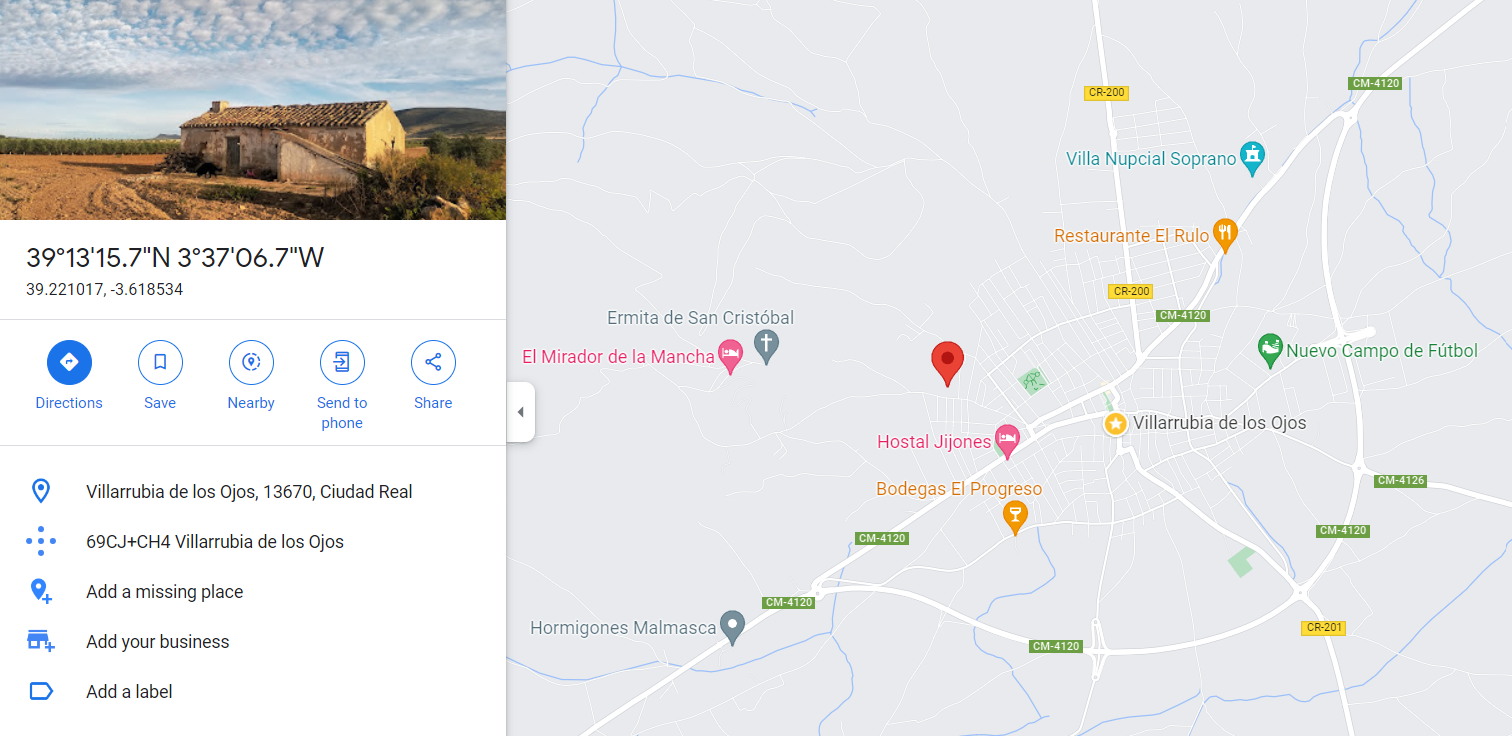

- LOC: '39.5473041962222,2.38945489891581'

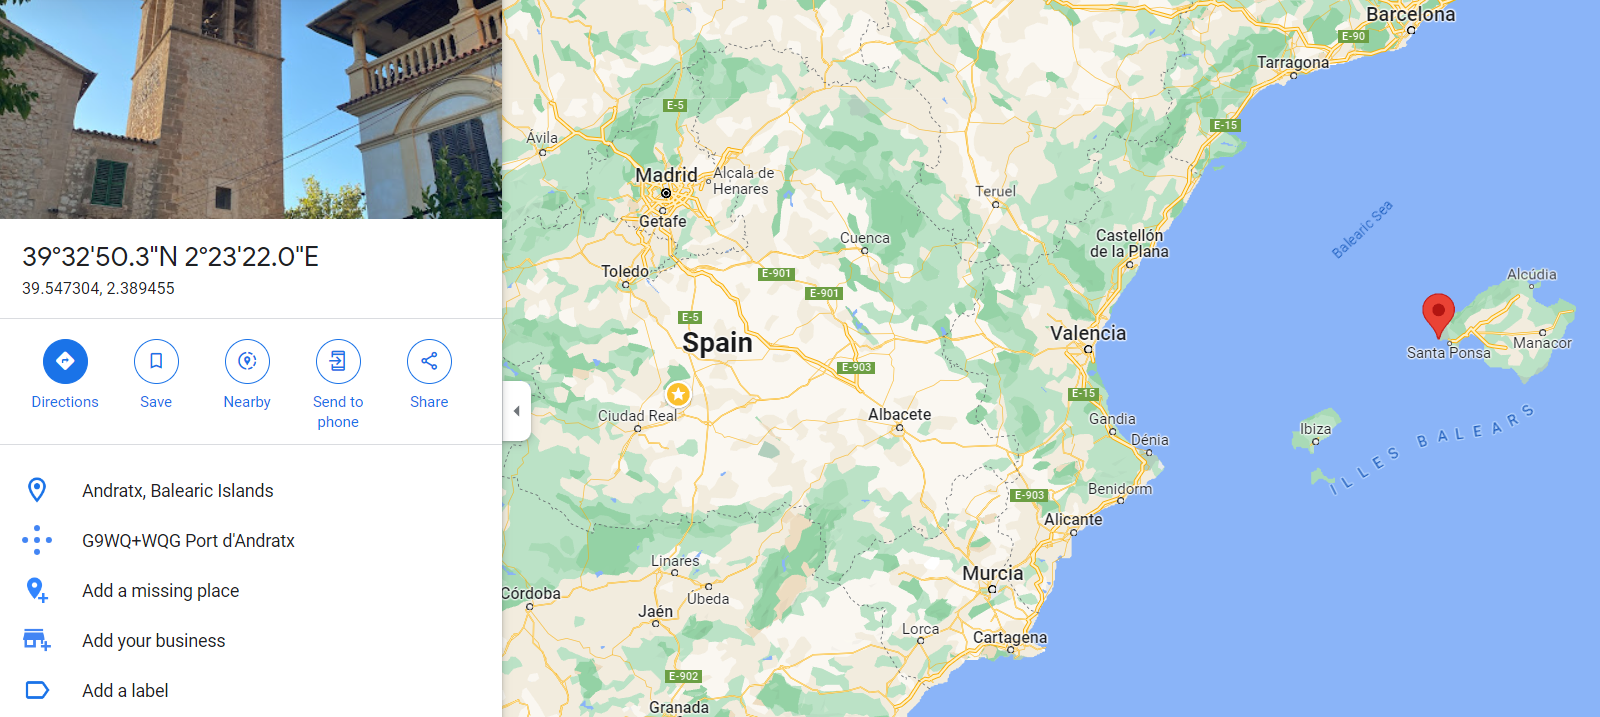

- LOC: '38.4230642610591,-6.41439677433768'

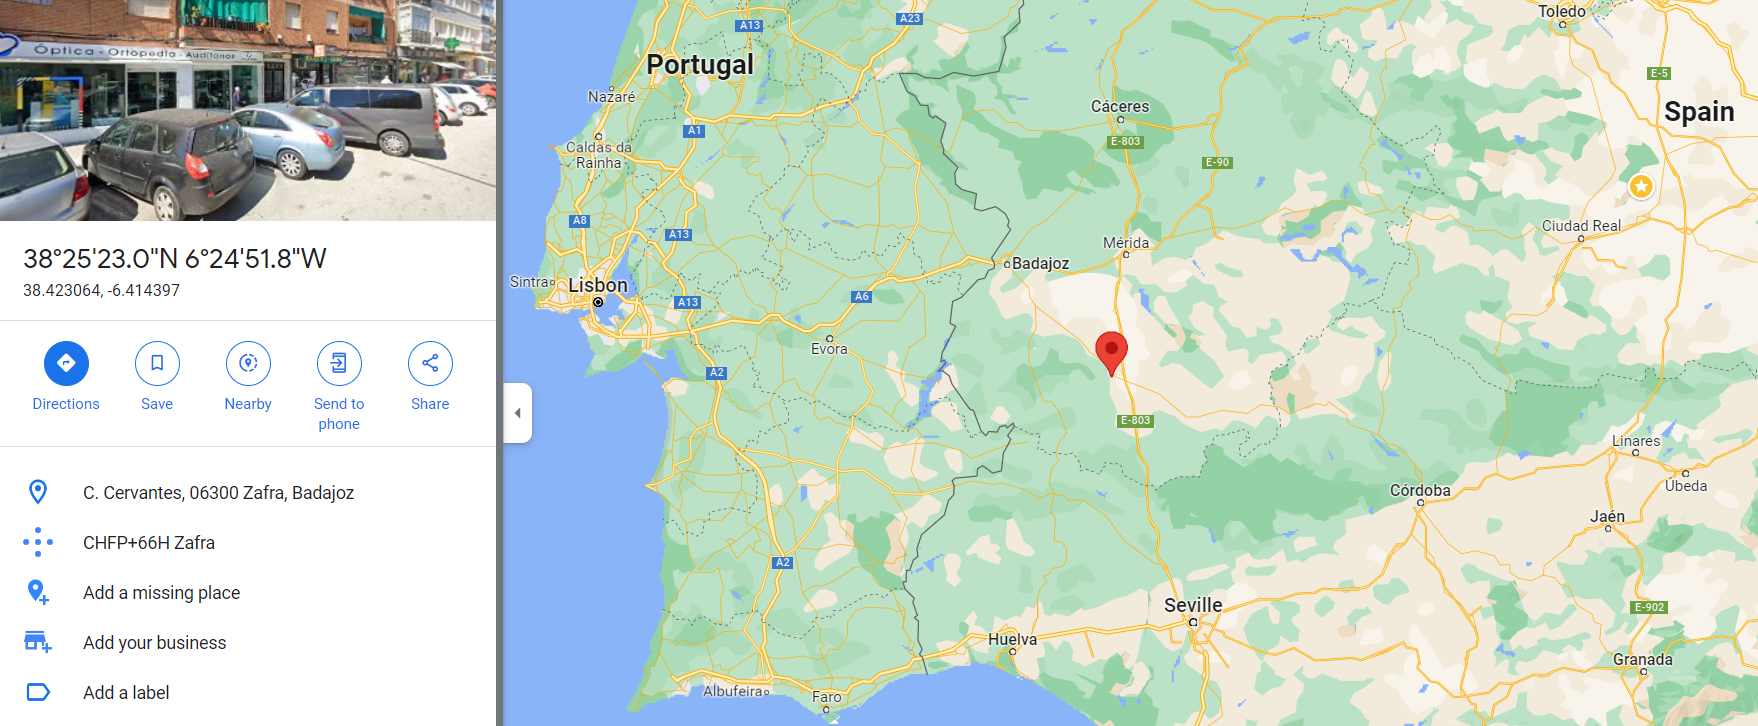

In [48]:
# FILTER LOC: '39.2210171,-3.6185337'
df6 = df6[(df6['locations']=='39.2210171,-3.6185337')].reset_index(drop=True)
df6 = df6.drop(['datetime','locations'], axis=1)

In [49]:
miss_info(df6)

col_name          dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0               wdir         float64    0      0.00      498        100.00   
1               temp         float64    0      0.00      498        100.00   
2               maxt         float64    0      0.00      498        100.00   
3         visibility         float64    0      0.00      498        100.00   
4               wspd         float64    0      0.00      498        100.00   
5        solarenergy         float64    0      0.00      498        100.00   
6          heatindex         float64  302     60.64      196         39.36   
7         cloudcover         float64  100     20.08      398         79.92   
8               mint         float64    0      0.00      498        100.00   
9             precip         float64    0      0.00      498        100.00   
10    solarradiation         float64    0      0.00      498        100.00   
11       weathertype          object  217     43.57      281         56.43   
12         snowdepth         float64  346     69.48      152         30.52   
13  sealevelpressure         float64    0      0.00      498        100.00   
14              snow         float64  346     69.48      152         30.52   
15               dew         float64    0      0.00      498        100.00   
16          humidity         float64    0      0.00      498        100.00   
17       precipcover         float64    0      0.00      498        100.00   
18             wgust         float64  369     74.10      129         25.90   
19        conditions          object    0      0.00      498        100.00   
20         windchill         float64  308     61.85      190         38.15   
21              info         float64  498    100.00        0          0.00   
22  datetimeStr_Date  datetime64[ns]    0      0.00      498        100.00   

    zero_values  unique_values neg_values  
0          0.00            487          0  
1          0.00            257          0  
2          0.00            215          0  
3          0.00             85          0  
4          0.00            162          0  
5          0.00            213          0  
6          0.00             97          0  
7         22.00            227          0  
8          3.00            211         53  
9        418.00             36          0  
10         0.00            453          0  
11         0.00             89         NA  
12       152.00              2          0  
13         0.00            195          0  
14       152.00              2          0  
15         1.00            158         31  
16         0.00            473          0  
17       418.00             22          0  
18         0.00             28          0  
19         0.00              6         NA  
20         0.00            107         48  
21         0.00              1          0  
22         0.00            498         NA

In [50]:
df_aux = miss_info(df6)
df_aux[df_aux['perc_nan']>=10]

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  zero_values  \
6     heatindex  float64  302     60.64      196         39.36         0.00   
7    cloudcover  float64  100     20.08      398         79.92        22.00   
11  weathertype   object  217     43.57      281         56.43         0.00   
12    snowdepth  float64  346     69.48      152         30.52       152.00   
14         snow  float64  346     69.48      152         30.52       152.00   
18        wgust  float64  369     74.10      129         25.90         0.00   
20    windchill  float64  308     61.85      190         38.15         0.00   
21         info  float64  498    100.00        0          0.00         0.00   

    unique_values neg_values  
6              97          0  
7             227          0  
11             89         NA  
12              2          0  
14              2          0  
18             28          0  
20            107         48  
21              1          0

In [51]:
# FILTER COLUMNS WITH MISSING VALUES
df6 = df6.drop(['heatindex','cloudcover','weathertype','snowdepth','snow','wgust','windchill','info'], axis=1)

In [52]:
miss_info(df6)

col_name          dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0               wdir         float64    0      0.00      498        100.00   
1               temp         float64    0      0.00      498        100.00   
2               maxt         float64    0      0.00      498        100.00   
3         visibility         float64    0      0.00      498        100.00   
4               wspd         float64    0      0.00      498        100.00   
5        solarenergy         float64    0      0.00      498        100.00   
6               mint         float64    0      0.00      498        100.00   
7             precip         float64    0      0.00      498        100.00   
8     solarradiation         float64    0      0.00      498        100.00   
9   sealevelpressure         float64    0      0.00      498        100.00   
10               dew         float64    0      0.00      498        100.00   
11          humidity         float64    0      0.00      498        100.00   
12       precipcover         float64    0      0.00      498        100.00   
13        conditions          object    0      0.00      498        100.00   
14  datetimeStr_Date  datetime64[ns]    0      0.00      498        100.00   

    zero_values  unique_values neg_values  
0          0.00            487          0  
1          0.00            257          0  
2          0.00            215          0  
3          0.00             85          0  
4          0.00            162          0  
5          0.00            213          0  
6          3.00            211         53  
7        418.00             36          0  
8          0.00            453          0  
9          0.00            195          0  
10         1.00            158         31  
11         0.00            473          0  
12       418.00             22          0  
13         0.00              6         NA  
14         0.00            498         NA

In [53]:
df6['conditions'].unique()

array(['Partially cloudy', 'Clear', 'Rain, Partially cloudy',
       'Rain, Overcast', 'Overcast', 'Rain'], dtype=object)

In [54]:
conditions_list = ['Partially cloudy', 'Clear','Rain', 'Overcast', 'Rain']

In [55]:
for x in conditions_list:

  column_name = 'cond_' + str(x).replace(' ','-')
  df6[column_name] = np.nan


In [56]:
df6

wdir  temp  maxt  visibility  wspd  solarenergy  mint  precip  \
0   247.13 24.00 30.30       14.80 10.60        24.40 14.20    0.00   
1   205.26 25.80 33.00       14.60 12.40        24.70 15.30    0.00   
2   264.83 27.30 33.00       14.80 16.20        25.30 21.20    0.00   
3   261.25 28.40 35.10       14.80 20.50        25.30 19.60    0.00   
4   253.96 28.60 34.90       14.80 29.70        25.50 22.20    0.00   
..     ...   ...   ...         ...   ...          ...   ...     ...   
493 144.00 10.80 13.20        9.50 11.40         2.80  8.90   11.80   
494 214.13 11.00 14.00       14.30 19.60         6.20  9.90    7.00   
495 255.22 10.50 13.00       14.30 21.50         4.30  8.90    0.60   
496 220.58 12.00 15.70       11.40 28.60         4.10  8.40   31.60   
497 240.63 14.50 16.90       12.70 28.40         3.10 12.60    3.40   

     solarradiation  sealevelpressure   dew  humidity  precipcover  \
0            452.70          1,014.10  3.80     27.87         0.00   
1            456.50          1,015.10  7.70     35.15         0.00   
2            468.30          1,014.60  8.00     30.15         0.00   
3            468.40          1,014.80  5.50     25.73         0.00   
4            471.70          1,010.70  5.80     25.60         0.00   
..              ...               ...   ...       ...          ...   
493           77.40          1,005.20  9.90     94.11        41.67   
494          172.40          1,001.80  9.50     90.65        20.83   
495          119.00          1,009.80  8.40     87.26        13.04   
496          114.90          1,007.30 10.60     91.03        37.50   
497           87.40          1,009.80 12.10     86.12        12.50   

                 conditions datetimeStr_Date  cond_Partially-cloudy  \
0          Partially cloudy       2021-08-02                    NaN   
1          Partially cloudy       2021-08-03                    NaN   
2                     Clear       2021-08-04                    NaN   
3                     Clear       2021-08-05                    NaN   
4                     Clear       2021-08-06                    NaN   
..                      ...              ...                    ...   
493  Rain, Partially cloudy       2022-12-08                    NaN   
494  Rain, Partially cloudy       2022-12-09                    NaN   
495  Rain, Partially cloudy       2022-12-10                    NaN   
496          Rain, Overcast       2022-12-11                    NaN   
497          Rain, Overcast       2022-12-12                    NaN   

     cond_Clear  cond_Rain  cond_Overcast  
0           NaN        NaN            NaN  
1           NaN        NaN            NaN  
2           NaN        NaN            NaN  
3           NaN        NaN            NaN  
4           NaN        NaN            NaN  
..          ...        ...            ...  
493         NaN        NaN            NaN  
494         NaN        NaN            NaN  
495         NaN        NaN            NaN  
496         NaN        NaN            NaN  
497         NaN        NaN            NaN  

[498 rows x 19 columns]

In [57]:
for i in range(0,df6.shape[0]):

  i_conditions = df6.loc[i,'conditions']

  for x in conditions_list:

    column_name = 'cond_' + str(x).replace(' ','-')

    if i_conditions.find(x) != -1:
      df6.loc[i,column_name] = 1
    else:
      df6.loc[i,column_name] = 0


In [58]:
df6

wdir  temp  maxt  visibility  wspd  solarenergy  mint  precip  \
0   247.13 24.00 30.30       14.80 10.60        24.40 14.20    0.00   
1   205.26 25.80 33.00       14.60 12.40        24.70 15.30    0.00   
2   264.83 27.30 33.00       14.80 16.20        25.30 21.20    0.00   
3   261.25 28.40 35.10       14.80 20.50        25.30 19.60    0.00   
4   253.96 28.60 34.90       14.80 29.70        25.50 22.20    0.00   
..     ...   ...   ...         ...   ...          ...   ...     ...   
493 144.00 10.80 13.20        9.50 11.40         2.80  8.90   11.80   
494 214.13 11.00 14.00       14.30 19.60         6.20  9.90    7.00   
495 255.22 10.50 13.00       14.30 21.50         4.30  8.90    0.60   
496 220.58 12.00 15.70       11.40 28.60         4.10  8.40   31.60   
497 240.63 14.50 16.90       12.70 28.40         3.10 12.60    3.40   

     solarradiation  sealevelpressure   dew  humidity  precipcover  \
0            452.70          1,014.10  3.80     27.87         0.00   
1            456.50          1,015.10  7.70     35.15         0.00   
2            468.30          1,014.60  8.00     30.15         0.00   
3            468.40          1,014.80  5.50     25.73         0.00   
4            471.70          1,010.70  5.80     25.60         0.00   
..              ...               ...   ...       ...          ...   
493           77.40          1,005.20  9.90     94.11        41.67   
494          172.40          1,001.80  9.50     90.65        20.83   
495          119.00          1,009.80  8.40     87.26        13.04   
496          114.90          1,007.30 10.60     91.03        37.50   
497           87.40          1,009.80 12.10     86.12        12.50   

                 conditions datetimeStr_Date  cond_Partially-cloudy  \
0          Partially cloudy       2021-08-02                   1.00   
1          Partially cloudy       2021-08-03                   1.00   
2                     Clear       2021-08-04                   0.00   
3                     Clear       2021-08-05                   0.00   
4                     Clear       2021-08-06                   0.00   
..                      ...              ...                    ...   
493  Rain, Partially cloudy       2022-12-08                   1.00   
494  Rain, Partially cloudy       2022-12-09                   1.00   
495  Rain, Partially cloudy       2022-12-10                   1.00   
496          Rain, Overcast       2022-12-11                   0.00   
497          Rain, Overcast       2022-12-12                   0.00   

     cond_Clear  cond_Rain  cond_Overcast  
0          0.00       0.00           0.00  
1          0.00       0.00           0.00  
2          1.00       0.00           0.00  
3          1.00       0.00           0.00  
4          1.00       0.00           0.00  
..          ...        ...            ...  
493        0.00       1.00           0.00  
494        0.00       1.00           0.00  
495        0.00       1.00           0.00  
496        0.00       1.00           1.00  
497        0.00       1.00           1.00  

[498 rows x 19 columns]

In [59]:
df6 = df6.drop(['conditions'], axis=1)

In [60]:
# NUMERICAL DISCRETE
'''
cond_Partially-cloudy
cond_Clear
cond_Rain
cond_Overcast
'''

# Column "cond_Partially-cloudy"
df6['cond_Partially-cloudy'] = df6['cond_Partially-cloudy'].astype('int64')

# Column "cond_Clear"
df6['cond_Clear'] = df6['cond_Clear'].astype('int64')

# Column "cond_Rain"
df6['cond_Rain'] = df6['cond_Rain'].astype('int64')

# Column "cond_Overcast"
df6['cond_Overcast'] = df6['cond_Overcast'].astype('int64')


In [61]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wdir                   498 non-null    float64       
 1   temp                   498 non-null    float64       
 2   maxt                   498 non-null    float64       
 3   visibility             498 non-null    float64       
 4   wspd                   498 non-null    float64       
 5   solarenergy            498 non-null    float64       
 6   mint                   498 non-null    float64       
 7   precip                 498 non-null    float64       
 8   solarradiation         498 non-null    float64       
 9   sealevelpressure       498 non-null    float64       
 10  dew                    498 non-null    float64       
 11  humidity               498 non-null    float64       
 12  precipcover            498 non-null    float64       
 13  datet

In [62]:
'''
profile = ProfileReport(df6, title="Profile_6-Clima")
#profile.to_notebook_iframe()
profile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_6-Clima.html")
'''

'\nprofile = ProfileReport(df6, title="Profile_6-Clima")\n#profile.to_notebook_iframe()\nprofile.to_file("C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_6-Clima.html")\n'

### Dataset 7: 'laboralidad' (EXTRA)

This dataset contains information about dates and working days.


In [63]:
#file_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/Datos Extra/Laboralidad/2000-2022_Tabla Lab-Fest.xlsx'
file_path = '/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/Datos Extra/Laboralidad/2000-2022_Tabla Lab-Fest.xlsx'

In [64]:
df7 = pd.read_excel(file_path)
df7.drop(['N_DiaSem', 'Tipo_Festivo', 'Festividad'], axis=1, inplace=True)
df7

Fecha     DiaSem  N_DiaMes  N_Mes  N_Ano    Clasif_Lab Clasif_Fest  \
0     2000-01-01     Sabado         1      1   2000  No Laborable     Festivo   
1     2000-01-02    Domingo         2      1   2000  No Laborable  No Festivo   
2     2000-01-03      Lunes         3      1   2000     Laborable  No Festivo   
3     2000-01-04     Martes         4      1   2000     Laborable  No Festivo   
4     2000-01-05  Miercoles         5      1   2000     Laborable  No Festivo   
...          ...        ...       ...    ...    ...           ...         ...   
18623 2050-12-27     Martes        27     12   2050     Laborable  No Festivo   
18624 2050-12-28  Miercoles        28     12   2050     Laborable  No Festivo   
18625 2050-12-29     Jueves        29     12   2050     Laborable  No Festivo   
18626 2050-12-30    Viernes        30     12   2050     Laborable  No Festivo   
18627 2050-12-31     Sabado        31     12   2050  No Laborable  No Festivo   

       Lab_PrevioFest  Lab_PostFest  
0                   0             0  
1                   0             0  
2                   0             0  
3                   0             0  
4                   1             0  
...               ...           ...  
18623               0             1  
18624               0             0  
18625               0             0  
18626               0             0  
18627               0             0  

[18628 rows x 9 columns]

In [65]:
# Categoric cycle variables
df7 = cicl_tranf_diasem(df_input=df7, col_diasem='DiaSem')
df7 = cicl_tranf_day(df_input=df7, col_day='N_DiaMes', col_month='N_Mes', col_ano='N_Ano')
df7 = cicl_tranf_month(df_input=df7, col_month='N_Mes')

In [66]:
df7

Fecha     DiaSem  N_DiaMes  N_Mes  N_Ano    Clasif_Lab Clasif_Fest  \
0     2000-01-01     Sabado         1      1   2000  No Laborable     Festivo   
1     2000-01-02    Domingo         2      1   2000  No Laborable  No Festivo   
2     2000-01-03      Lunes         3      1   2000     Laborable  No Festivo   
3     2000-01-04     Martes         4      1   2000     Laborable  No Festivo   
4     2000-01-05  Miercoles         5      1   2000     Laborable  No Festivo   
...          ...        ...       ...    ...    ...           ...         ...   
18623 2050-12-27     Martes        27     12   2050     Laborable  No Festivo   
18624 2050-12-28  Miercoles        28     12   2050     Laborable  No Festivo   
18625 2050-12-29     Jueves        29     12   2050     Laborable  No Festivo   
18626 2050-12-30    Viernes        30     12   2050     Laborable  No Festivo   
18627 2050-12-31     Sabado        31     12   2050  No Laborable  No Festivo   

       Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  DiaSem_COS  Dia_SIN  Dia_COS  \
0                   0             0       -0.97       -0.22     0.00     1.00   
1                   0             0       -0.78        0.62     0.20     0.98   
2                   0             0        0.00        1.00     0.39     0.92   
3                   0             0        0.78        0.62     0.57     0.82   
4                   1             0        0.97       -0.22     0.72     0.69   
...               ...           ...         ...         ...      ...      ...   
18623               0             1        0.78        0.62    -0.85     0.53   
18624               0             0        0.97       -0.22    -0.72     0.69   
18625               0             0        0.43       -0.90    -0.57     0.82   
18626               0             0       -0.43       -0.90    -0.39     0.92   
18627               0             0       -0.97       -0.22    -0.20     0.98   

       Mes_SIN  Mes_COS  
0         0.00     1.00  
1         0.00     1.00  
2         0.00     1.00  
3         0.00     1.00  
4         0.00     1.00  
...        ...      ...  
18623    -0.50     0.87  
18624    -0.50     0.87  
18625    -0.50     0.87  
18626    -0.50     0.87  
18627    -0.50     0.87  

[18628 rows x 15 columns]

In [67]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df7['DiaSem']
df7['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df7['Clasif_Lab']
df7['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df7['Clasif_Fest']
df7['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [68]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha           18628 non-null  datetime64[ns]
 1   DiaSem          18628 non-null  category      
 2   N_DiaMes        18628 non-null  int64         
 3   N_Mes           18628 non-null  int64         
 4   N_Ano           18628 non-null  int64         
 5   Clasif_Lab      18628 non-null  category      
 6   Clasif_Fest     18628 non-null  category      
 7   Lab_PrevioFest  18628 non-null  int64         
 8   Lab_PostFest    18628 non-null  int64         
 9   DiaSem_SIN      18628 non-null  float64       
 10  DiaSem_COS      18628 non-null  float64       
 11  Dia_SIN         18628 non-null  float64       
 12  Dia_COS         18628 non-null  float64       
 13  Mes_SIN         18628 non-null  float64       
 14  Mes_COS         18628 non-null  float64       
dtypes:

In [69]:
'''
profile = ProfileReport(df7, title="Profile_7-Laboralidad")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_7-Laboralidad.html')
'''

'\nprofile = ProfileReport(df7, title="Profile_7-Laboralidad")\n#profile.to_notebook_iframe()\nprofile.to_file(\'C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_7-Laboralidad.html\')\n'

## DATASET 1 PREPARATION: '15 mins volume'

### Missing observations (per sector)

In [70]:
df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']=='Carretera Urda')]

Canonical                    RowKey INF_Label  INF_Value  \
95483   TOTALIZADOR 2021-08-01 00:15:00+00:00   LS Urda   4,437.40   
95484   TOTALIZADOR 2021-08-01 00:30:00+00:00   LS Urda   4,438.58   
95485   TOTALIZADOR 2021-08-01 00:45:00+00:00   LS Urda   4,439.68   
95486   TOTALIZADOR 2021-08-01 01:00:00+00:00   LS Urda   4,440.68   
95487   TOTALIZADOR 2021-08-01 01:15:00+00:00   LS Urda   4,441.82   
...             ...                       ...       ...        ...   
143220  TOTALIZADOR 2022-12-12 05:00:00+00:00   LS Urda  20,183.72   
143221  TOTALIZADOR 2022-12-12 05:15:00+00:00   LS Urda  20,183.89   
143222  TOTALIZADOR 2022-12-12 05:30:00+00:00   LS Urda  20,184.04   
143223  TOTALIZADOR 2022-12-12 05:45:00+00:00   LS Urda  20,184.20   
143224  TOTALIZADOR 2022-12-12 06:00:00+00:00   LS Urda  20,184.35   

                   STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
95483   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95484   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95485   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95486   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95487   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
...                      ...         ...      ...             ...         ...   
143220  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143221  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143222  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143223  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143224  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   

       RowKey_Time  
95483     00:15:00  
95484     00:30:00  
95485     00:45:00  
95486     01:00:00  
95487     01:15:00  
...            ...  
143220    05:00:00  
143221    05:15:00  
143222    05:30:00  
143223    05:45:00  
143224    06:00:00  

[47742 rows x 10 columns]

In [71]:
df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']=='Carretera Urda')&(df1['RowKey_Time']=='00:00:00')]

Canonical                    RowKey INF_Label  INF_Value  \
95578   TOTALIZADOR 2021-08-02 00:00:00+00:00   LS Urda   4,560.84   
95674   TOTALIZADOR 2021-08-03 00:00:00+00:00   LS Urda   4,670.93   
95770   TOTALIZADOR 2021-08-04 00:00:00+00:00   LS Urda   4,777.60   
95866   TOTALIZADOR 2021-08-05 00:00:00+00:00   LS Urda   4,851.78   
95962   TOTALIZADOR 2021-08-06 00:00:00+00:00   LS Urda   4,866.26   
...             ...                       ...       ...        ...   
142792  TOTALIZADOR 2022-12-08 00:00:00+00:00   LS Urda  20,098.90   
142911  TOTALIZADOR 2022-12-09 00:00:00+00:00   LS Urda  20,118.77   
142984  TOTALIZADOR 2022-12-10 00:00:00+00:00   LS Urda  20,138.56   
143103  TOTALIZADOR 2022-12-11 00:00:00+00:00   LS Urda  20,159.18   
143176  TOTALIZADOR 2022-12-12 00:00:00+00:00   LS Urda  20,180.56   

                   STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
95578   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95674   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-02   
95770   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-03   
95866   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-04   
95962   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-05   
...                      ...         ...      ...             ...         ...   
142792  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-07   
142911  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-08   
142984  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-09   
143103  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-10   
143176  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-11   

       RowKey_Time  
95578     00:00:00  
95674     00:00:00  
95770     00:00:00  
95866     00:00:00  
95962     00:00:00  
...            ...  
142792    00:00:00  
142911    00:00:00  
142984    00:00:00  
143103    00:00:00  
143176    00:00:00  

[498 rows x 10 columns]

In [72]:
dftot_nans = pd.DataFrame()

for x in sectors_list:
  col_name = x + '_TimeObs'
  dftot_nans[col_name] = df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']==x)].groupby('RowKey_Date').count()['RowKey_Time']

dftot_nans.reset_index(inplace=True)


In [73]:
dftot_nans

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
0    2021-08-01                  96                 NaN             96.00   
1    2021-08-02                  96                 NaN             96.00   
2    2021-08-03                  96                 NaN             96.00   
3    2021-08-04                  96                 NaN             96.00   
4    2021-08-05                  96                 NaN             96.00   
..          ...                 ...                 ...               ...   
492  2022-12-08                  96                 NaN               NaN   
493  2022-12-09                  96                 NaN               NaN   
494  2022-12-10                  96                 NaN               NaN   
495  2022-12-11                  96                 NaN               NaN   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
0                        96           96.00           96.00               NaN   
1                        96           96.00           96.00               NaN   
2                        96           96.00           96.00               NaN   
3                        96           96.00           96.00               NaN   
4                        96           96.00           96.00             41.00   
..                      ...             ...             ...               ...   
492                      96           96.00           96.00             96.00   
493                      96           96.00           96.00             96.00   
494                      96           96.00           96.00             96.00   
495                      96           96.00           96.00             96.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
..                ...  
492               NaN  
493               NaN  
494               NaN  
495               NaN  
496               NaN  

[497 rows x 9 columns]

In [74]:
dftot_nans.sum()

<ipython-input-74-6bab5d854587>:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


Valladolid_TimeObs       47,434.00
Gasolinera_TimeObs            0.00
Churruca_TimeObs         33,158.00
Carretera Urda_TimeObs   47,550.00
Planta_TimeObs           40,237.00
Centro_TimeObs           39,748.00
Sur Este_TimeObs         47,134.00
Poligono_TimeObs              0.00
dtype: float64

In [75]:
dftot_nans[dftot_nans['Valladolid_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
157  2022-01-05                  24                 NaN             24.00   
158  2022-01-07                  93                 NaN               NaN   
237  2022-03-27                  92                 NaN             92.00   
442  2022-10-18                  24                 NaN               NaN   
443  2022-10-20                  41                 NaN               NaN   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
157                      25           25.00             NaN             29.00   
158                      96           96.00             NaN             96.00   
237                      92             NaN           92.00             92.00   
442                      96           96.00           96.00             96.00   
443                      96           96.00           96.00             96.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
157               NaN  
158               NaN  
237               NaN  
442               NaN  
443               NaN  
496               NaN

In [76]:
dftot_nans[dftot_nans['Gasolinera_TimeObs']<96]

Empty DataFrame
Columns: [RowKey_Date, Valladolid_TimeObs, Gasolinera_TimeObs, Churruca_TimeObs, Carretera Urda_TimeObs, Planta_TimeObs, Centro_TimeObs, Sur Este_TimeObs, Poligono_TimeObs]
Index: []

In [77]:
dftot_nans[dftot_nans['Churruca_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
157  2022-01-05                  24                 NaN             24.00   
167  2022-01-16                  96                 NaN             57.00   
237  2022-03-27                  92                 NaN             92.00   
330  2022-06-28                  96                 NaN             24.00   
387  2022-08-24                  96                 NaN             60.00   
392  2022-08-29                  96                 NaN             24.00   
400  2022-09-06                  96                 NaN             43.00   
417  2022-09-23                  96                 NaN             24.00   
465  2022-11-11                  96                 NaN             50.00   
469  2022-11-15                  96                 NaN             24.00   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
157                      25           25.00             NaN             29.00   
167                      96           96.00             NaN             96.00   
237                      92             NaN           92.00             92.00   
330                      96           96.00           96.00             96.00   
387                      96           96.00           96.00             96.00   
392                      96           96.00           96.00             96.00   
400                      96           96.00           96.00             96.00   
417                      96           96.00           96.00             96.00   
465                      96           96.00           96.00             96.00   
469                      96           96.00           96.00             96.00   

     Poligono_TimeObs  
157               NaN  
167               NaN  
237               NaN  
330               NaN  
387               NaN  
392               NaN  
400               NaN  
417               NaN  
465               NaN  
469               NaN

In [78]:
dftot_nans[dftot_nans['Carretera Urda_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
157  2022-01-05                  24                 NaN             24.00   
177  2022-01-26                  96                 NaN             96.00   
237  2022-03-27                  92                 NaN             92.00   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
157                      25           25.00             NaN             29.00   
177                      81           96.00           56.00             96.00   
237                      92             NaN           92.00             92.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
157               NaN  
177               NaN  
237               NaN  
496               NaN

In [79]:
dftot_nans[dftot_nans['Planta_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
157  2022-01-05                  24                 NaN             24.00   
198  2022-02-16                  96                 NaN             96.00   
274  2022-05-03                  96                 NaN             96.00   
280  2022-05-09                  96                 NaN             96.00   
337  2022-07-05                  96                 NaN               NaN   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
157                      25           25.00             NaN             29.00   
198                      96           24.00           96.00             96.00   
274                      96           54.00           96.00             96.00   
280                      96           87.00           96.00             96.00   
337                      96           87.00           96.00             96.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
157               NaN  
198               NaN  
274               NaN  
280               NaN  
337               NaN  
496               NaN

In [80]:
dftot_nans[dftot_nans['Centro_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
95   2021-11-04                  96                 NaN             96.00   
177  2022-01-26                  96                 NaN             96.00   
237  2022-03-27                  92                 NaN             92.00   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
95                       96           96.00           24.00             96.00   
177                      81           96.00           56.00             96.00   
237                      92             NaN           92.00             92.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
95                NaN  
177               NaN  
237               NaN  
496               NaN

In [81]:
dftot_nans[dftot_nans['Sur Este_TimeObs']<96]

RowKey_Date  Valladolid_TimeObs  Gasolinera_TimeObs  Churruca_TimeObs  \
4    2021-08-05                  96                 NaN             96.00   
157  2022-01-05                  24                 NaN             24.00   
237  2022-03-27                  92                 NaN             92.00   
496  2022-12-12                  24                 NaN               NaN   

     Carretera Urda_TimeObs  Planta_TimeObs  Centro_TimeObs  Sur Este_TimeObs  \
4                        96           96.00           96.00             41.00   
157                      25           25.00             NaN             29.00   
237                      92             NaN           92.00             92.00   
496                      24           24.00           24.00             28.00   

     Poligono_TimeObs  
4                 NaN  
157               NaN  
237               NaN  
496               NaN

In [82]:
dftot_nans[dftot_nans['Poligono_TimeObs']<96]

Empty DataFrame
Columns: [RowKey_Date, Valladolid_TimeObs, Gasolinera_TimeObs, Churruca_TimeObs, Carretera Urda_TimeObs, Planta_TimeObs, Centro_TimeObs, Sur Este_TimeObs, Poligono_TimeObs]
Index: []

### Obtaining '15 mins volume'

In [207]:
list(df1['Canonical'].unique())

['CAUDAL',
 'PRESION_ENTRADA_SECTOR',
 'TOTALIZADOR',
 'VOLUMEN_DIARIO',
 'DEPOSITO',
 'DEPOSITO_CAUDAL_SALIDA',
 'DEPOSITO_METROS',
 'DEPOSITO_VOLUMEN_SALIDA',
 'MARCHA_POZO',
 'VOLUMEN',
 'PRESION_SALIDA_SECTOR']

In [208]:
df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']=='Carretera Urda')]

Canonical                    RowKey INF_Label  INF_Value  \
95483   TOTALIZADOR 2021-08-01 00:15:00+00:00   LS Urda   4,437.40   
95484   TOTALIZADOR 2021-08-01 00:30:00+00:00   LS Urda   4,438.58   
95485   TOTALIZADOR 2021-08-01 00:45:00+00:00   LS Urda   4,439.68   
95486   TOTALIZADOR 2021-08-01 01:00:00+00:00   LS Urda   4,440.68   
95487   TOTALIZADOR 2021-08-01 01:15:00+00:00   LS Urda   4,441.82   
...             ...                       ...       ...        ...   
143220  TOTALIZADOR 2022-12-12 05:00:00+00:00   LS Urda  20,183.72   
143221  TOTALIZADOR 2022-12-12 05:15:00+00:00   LS Urda  20,183.89   
143222  TOTALIZADOR 2022-12-12 05:30:00+00:00   LS Urda  20,184.04   
143223  TOTALIZADOR 2022-12-12 05:45:00+00:00   LS Urda  20,184.20   
143224  TOTALIZADOR 2022-12-12 06:00:00+00:00   LS Urda  20,184.35   

                   STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
95483   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95484   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95485   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95486   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95487   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
...                      ...         ...      ...             ...         ...   
143220  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143221  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143222  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143223  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   
143224  11000 Carretera Urda    22110000    11000  Carretera Urda  2022-12-12   

       RowKey_Time  
95483     00:15:00  
95484     00:30:00  
95485     00:45:00  
95486     01:00:00  
95487     01:15:00  
...            ...  
143220    05:00:00  
143221    05:15:00  
143222    05:30:00  
143223    05:45:00  
143224    06:00:00  

[47742 rows x 10 columns]

In [209]:
df1[(df1['Canonical']=='CAUDAL')&(df1['RowKey_Date']=='2021-08-01')&(df1['STA_Name']=='Carretera Urda')]

Canonical                    RowKey INF_Label  INF_Value  \
0     CAUDAL 2021-08-01 00:15:00+00:00   LS Urda       5.00   
1     CAUDAL 2021-08-01 00:30:00+00:00   LS Urda       4.72   
2     CAUDAL 2021-08-01 00:45:00+00:00   LS Urda       4.40   
3     CAUDAL 2021-08-01 01:00:00+00:00   LS Urda       4.00   
4     CAUDAL 2021-08-01 01:15:00+00:00   LS Urda       4.56   
..       ...                       ...       ...        ...   
91    CAUDAL 2021-08-01 23:00:00+00:00   LS Urda       4.36   
92    CAUDAL 2021-08-01 23:15:00+00:00   LS Urda       4.28   
93    CAUDAL 2021-08-01 23:30:00+00:00   LS Urda       4.44   
94    CAUDAL 2021-08-01 23:45:00+00:00   LS Urda       4.56   
95    CAUDAL 2021-08-02 00:00:00+00:00   LS Urda       4.84   

               STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
0   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
1   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
2   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
3   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
4   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
..                   ...         ...      ...             ...         ...   
91  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
92  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
93  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
94  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   

   RowKey_Time  
0     00:15:00  
1     00:30:00  
2     00:45:00  
3     01:00:00  
4     01:15:00  
..         ...  
91    23:00:00  
92    23:15:00  
93    23:30:00  
94    23:45:00  
95    00:00:00  

[96 rows x 10 columns]

In [210]:
df1[(df1['Canonical'].str.contains('PRESION'))&(df1['RowKey_Date']=='2021-08-01')&(df1['STA_Name']=='Carretera Urda')]

Canonical                    RowKey INF_Label  INF_Value  \
47742  PRESION_ENTRADA_SECTOR 2021-08-01 00:15:00+00:00   LS Urda       3.84   
47743  PRESION_ENTRADA_SECTOR 2021-08-01 00:30:00+00:00   LS Urda       3.88   
47744  PRESION_ENTRADA_SECTOR 2021-08-01 00:45:00+00:00   LS Urda       3.89   
47745  PRESION_ENTRADA_SECTOR 2021-08-01 01:00:00+00:00   LS Urda       3.89   
47746  PRESION_ENTRADA_SECTOR 2021-08-01 01:15:00+00:00   LS Urda       3.89   
...                       ...                       ...       ...        ...   
47833  PRESION_ENTRADA_SECTOR 2021-08-01 23:00:00+00:00   LS Urda       3.68   
47834  PRESION_ENTRADA_SECTOR 2021-08-01 23:15:00+00:00   LS Urda       3.64   
47835  PRESION_ENTRADA_SECTOR 2021-08-01 23:30:00+00:00   LS Urda       3.68   
47836  PRESION_ENTRADA_SECTOR 2021-08-01 23:45:00+00:00   LS Urda       3.69   
47837  PRESION_ENTRADA_SECTOR 2021-08-02 00:00:00+00:00   LS Urda       3.92   

                  STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
47742  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47743  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47744  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47745  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47746  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
...                     ...         ...      ...             ...         ...   
47833  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47834  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47835  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47836  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
47837  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   

      RowKey_Time  
47742    00:15:00  
47743    00:30:00  
47744    00:45:00  
47745    01:00:00  
47746    01:15:00  
...           ...  
47833    23:00:00  
47834    23:15:00  
47835    23:30:00  
47836    23:45:00  
47837    00:00:00  

[96 rows x 10 columns]

In [211]:
df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']=='Poligono')]

Empty DataFrame
Columns: [Canonical, RowKey, INF_Label, INF_Value, STA_Label, Sector_Neta, STA_Code, STA_Name, RowKey_Date, RowKey_Time]
Index: []

In [212]:
df1[(df1['Canonical']=='CAUDAL')&(df1['RowKey_Date']=='2021-08-02')&(df1['STA_Name']=='Poligono')]

Canonical                    RowKey    INF_Label  INF_Value  \
681551    CAUDAL 2021-08-02 01:00:00+00:00  LS Poligono       5.91   
681552    CAUDAL 2021-08-02 02:00:00+00:00  LS Poligono       5.93   
681553    CAUDAL 2021-08-02 03:00:00+00:00  LS Poligono       5.91   
681554    CAUDAL 2021-08-02 04:00:00+00:00  LS Poligono       6.07   
681555    CAUDAL 2021-08-02 05:00:00+00:00  LS Poligono       6.25   
681556    CAUDAL 2021-08-02 06:00:00+00:00  LS Poligono       5.90   
681557    CAUDAL 2021-08-02 07:00:00+00:00  LS Poligono       7.05   
681558    CAUDAL 2021-08-02 08:00:00+00:00  LS Poligono      11.94   
681559    CAUDAL 2021-08-02 09:00:00+00:00  LS Poligono      28.61   
681560    CAUDAL 2021-08-02 10:00:00+00:00  LS Poligono      20.39   
681561    CAUDAL 2021-08-02 11:00:00+00:00  LS Poligono       7.74   
681562    CAUDAL 2021-08-02 12:00:00+00:00  LS Poligono      11.74   
681563    CAUDAL 2021-08-02 13:00:00+00:00  LS Poligono       6.94   
681564    CAUDAL 2021-08-02 14:00:00+00:00  LS Poligono       4.88   
681565    CAUDAL 2021-08-02 15:00:00+00:00  LS Poligono       4.36   
681566    CAUDAL 2021-08-02 16:00:00+00:00  LS Poligono       4.50   
681567    CAUDAL 2021-08-02 17:00:00+00:00  LS Poligono       5.09   
681568    CAUDAL 2021-08-02 18:00:00+00:00  LS Poligono       4.79   
681569    CAUDAL 2021-08-02 19:00:00+00:00  LS Poligono       4.59   
681570    CAUDAL 2021-08-02 20:00:00+00:00  LS Poligono       5.82   
681571    CAUDAL 2021-08-02 21:00:00+00:00  LS Poligono       5.40   
681572    CAUDAL 2021-08-02 22:00:00+00:00  LS Poligono       6.77   
681573    CAUDAL 2021-08-02 23:00:00+00:00  LS Poligono       8.21   
681574    CAUDAL 2021-08-03 00:00:00+00:00  LS Poligono       7.57   

             STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date RowKey_Time  
681551  12210 Poligono    22122100    12210  Poligono  2021-08-02    01:00:00  
681552  12210 Poligono    22122100    12210  Poligono  2021-08-02    02:00:00  
681553  12210 Poligono    22122100    12210  Poligono  2021-08-02    03:00:00  
681554  12210 Poligono    22122100    12210  Poligono  2021-08-02    04:00:00  
681555  12210 Poligono    22122100    12210  Poligono  2021-08-02    05:00:00  
681556  12210 Poligono    22122100    12210  Poligono  2021-08-02    06:00:00  
681557  12210 Poligono    22122100    12210  Poligono  2021-08-02    07:00:00  
681558  12210 Poligono    22122100    12210  Poligono  2021-08-02    08:00:00  
681559  12210 Poligono    22122100    12210  Poligono  2021-08-02    09:00:00  
681560  12210 Poligono    22122100    12210  Poligono  2021-08-02    10:00:00  
681561  12210 Poligono    22122100    12210  Poligono  2021-08-02    11:00:00  
681562  12210 Poligono    22122100    12210  Poligono  2021-08-02    12:00:00  
681563  12210 Poligono    22122100    12210  Poligono  2021-08-02    13:00:00  
681564  12210 Poligono    22122100    12210  Poligono  2021-08-02    14:00:00  
681565  12210 Poligono    22122100    12210  Poligono  2021-08-02    15:00:00  
681566  12210 Poligono    22122100    12210  Poligono  2021-08-02    16:00:00  
681567  12210 Poligono    22122100    12210  Poligono  2021-08-02    17:00:00  
681568  12210 Poligono    22122100    12210  Poligono  2021-08-02    18:00:00  
681569  12210 Poligono    22122100    12210  Poligono  2021-08-02    19:00:00  
681570  12210 Poligono    22122100    12210  Poligono  2021-08-02    20:00:00  
681571  12210 Poligono    22122100    12210  Poligono  2021-08-02    21:00:00  
681572  12210 Poligono    22122100    12210  Poligono  2021-08-02    22:00:00  
681573  12210 Poligono    22122100    12210  Poligono  2021-08-02    23:00:00  
681574  12210 Poligono    22122100    12210  Poligono  2021-08-02    00:00:00

In [213]:
df1[(df1['Canonical']=='CAUDAL')&(df1['RowKey_Date']=='2021-08-02')&(df1['STA_Name']=='Poligono')]['INF_Value'].sum()

192.35999570041895

In [214]:
df1[(df1['Canonical'].str.contains('PRESION'))&(df1['RowKey_Date']=='2021-08-01')&(df1['STA_Name']=='Poligono')]

Empty DataFrame
Columns: [Canonical, RowKey, INF_Label, INF_Value, STA_Label, Sector_Neta, STA_Code, STA_Name, RowKey_Date, RowKey_Time]
Index: []

In [215]:
df1[(df1['Canonical']=='VOLUMEN')]

Canonical                    RowKey    INF_Label  INF_Value  \
692956   VOLUMEN 2021-08-02 00:00:00+00:00  LS Poligono     195.40   
692957   VOLUMEN 2021-08-03 00:00:00+00:00  LS Poligono     192.36   
692958   VOLUMEN 2021-08-04 00:00:00+00:00  LS Poligono     212.30   
692959   VOLUMEN 2021-08-05 00:00:00+00:00  LS Poligono     215.27   
692960   VOLUMEN 2021-08-06 00:00:00+00:00  LS Poligono     185.43   
...          ...                       ...          ...        ...   
693427   VOLUMEN 2022-12-08 00:00:00+00:00  LS Poligono      65.69   
693428   VOLUMEN 2022-12-09 00:00:00+00:00  LS Poligono      57.25   
693429   VOLUMEN 2022-12-10 00:00:00+00:00  LS Poligono      60.48   
693430   VOLUMEN 2022-12-11 00:00:00+00:00  LS Poligono      62.17   
693431   VOLUMEN 2022-12-12 00:00:00+00:00  LS Poligono      44.60   

             STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date RowKey_Time  
692956  12210 Poligono    22122100    12210  Poligono  2021-08-01    00:00:00  
692957  12210 Poligono    22122100    12210  Poligono  2021-08-02    00:00:00  
692958  12210 Poligono    22122100    12210  Poligono  2021-08-03    00:00:00  
692959  12210 Poligono    22122100    12210  Poligono  2021-08-04    00:00:00  
692960  12210 Poligono    22122100    12210  Poligono  2021-08-05    00:00:00  
...                ...         ...      ...       ...         ...         ...  
693427  12210 Poligono    22122100    12210  Poligono  2022-12-07    00:00:00  
693428  12210 Poligono    22122100    12210  Poligono  2022-12-08    00:00:00  
693429  12210 Poligono    22122100    12210  Poligono  2022-12-09    00:00:00  
693430  12210 Poligono    22122100    12210  Poligono  2022-12-10    00:00:00  
693431  12210 Poligono    22122100    12210  Poligono  2022-12-11    00:00:00  

[476 rows x 10 columns]

In [216]:
df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']=='Churruca')]

Canonical                    RowKey    INF_Label  INF_Value  \
331962  TOTALIZADOR 2021-08-01 00:15:00+00:00  LS Churruca 948,875.19   
331963  TOTALIZADOR 2021-08-01 00:30:00+00:00  LS Churruca 948,885.12   
331964  TOTALIZADOR 2021-08-01 00:45:00+00:00  LS Churruca 948,895.12   
331965  TOTALIZADOR 2021-08-01 01:00:00+00:00  LS Churruca 948,904.69   
331966  TOTALIZADOR 2021-08-01 01:15:00+00:00  LS Churruca 948,914.44   
...             ...                       ...          ...        ...   
365115  TOTALIZADOR 2022-11-15 05:00:00+00:00  LS Churruca       0.00   
365116  TOTALIZADOR 2022-11-15 05:15:00+00:00  LS Churruca       0.00   
365117  TOTALIZADOR 2022-11-15 05:30:00+00:00  LS Churruca       0.00   
365118  TOTALIZADOR 2022-11-15 05:45:00+00:00  LS Churruca       0.00   
365119  TOTALIZADOR 2022-11-15 06:00:00+00:00  LS Churruca       0.00   

             STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date RowKey_Time  
331962  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:15:00  
331963  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:30:00  
331964  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:45:00  
331965  13000 Churruca    22130000    13000  Churruca  2021-08-01    01:00:00  
331966  13000 Churruca    22130000    13000  Churruca  2021-08-01    01:15:00  
...                ...         ...      ...       ...         ...         ...  
365115  13000 Churruca    22130000    13000  Churruca  2022-11-15    05:00:00  
365116  13000 Churruca    22130000    13000  Churruca  2022-11-15    05:15:00  
365117  13000 Churruca    22130000    13000  Churruca  2022-11-15    05:30:00  
365118  13000 Churruca    22130000    13000  Churruca  2022-11-15    05:45:00  
365119  13000 Churruca    22130000    13000  Churruca  2022-11-15    06:00:00  

[33158 rows x 10 columns]

In [217]:
df1[(df1['Canonical']=='CAUDAL')&(df1['RowKey_Date']=='2021-08-01')&(df1['STA_Name']=='Churruca')]

Canonical                    RowKey    INF_Label  INF_Value  \
263648    CAUDAL 2021-08-01 00:15:00+00:00  LS Churruca      42.80   
263649    CAUDAL 2021-08-01 00:30:00+00:00  LS Churruca      39.60   
263650    CAUDAL 2021-08-01 00:45:00+00:00  LS Churruca      40.00   
263651    CAUDAL 2021-08-01 01:00:00+00:00  LS Churruca      38.40   
263652    CAUDAL 2021-08-01 01:15:00+00:00  LS Churruca      38.80   
...          ...                       ...          ...        ...   
263739    CAUDAL 2021-08-01 23:00:00+00:00  LS Churruca      56.80   
263740    CAUDAL 2021-08-01 23:15:00+00:00  LS Churruca      54.80   
263741    CAUDAL 2021-08-01 23:30:00+00:00  LS Churruca      50.80   
263742    CAUDAL 2021-08-01 23:45:00+00:00  LS Churruca      47.60   
263743    CAUDAL 2021-08-02 00:00:00+00:00  LS Churruca      46.80   

             STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date RowKey_Time  
263648  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:15:00  
263649  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:30:00  
263650  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:45:00  
263651  13000 Churruca    22130000    13000  Churruca  2021-08-01    01:00:00  
263652  13000 Churruca    22130000    13000  Churruca  2021-08-01    01:15:00  
...                ...         ...      ...       ...         ...         ...  
263739  13000 Churruca    22130000    13000  Churruca  2021-08-01    23:00:00  
263740  13000 Churruca    22130000    13000  Churruca  2021-08-01    23:15:00  
263741  13000 Churruca    22130000    13000  Churruca  2021-08-01    23:30:00  
263742  13000 Churruca    22130000    13000  Churruca  2021-08-01    23:45:00  
263743  13000 Churruca    22130000    13000  Churruca  2021-08-01    00:00:00  

[96 rows x 10 columns]

In [218]:
df1[(df1['Canonical'].str.contains('PRESION'))&(df1['RowKey_Date']=='2021-08-01')&(df1['STA_Name']=='Churruca')]

Canonical                    RowKey    INF_Label  \
297806  PRESION_ENTRADA_SECTOR 2021-08-01 00:15:00+00:00  LS Churruca   
297807  PRESION_ENTRADA_SECTOR 2021-08-01 00:30:00+00:00  LS Churruca   
297808  PRESION_ENTRADA_SECTOR 2021-08-01 00:45:00+00:00  LS Churruca   
297809  PRESION_ENTRADA_SECTOR 2021-08-01 01:00:00+00:00  LS Churruca   
297810  PRESION_ENTRADA_SECTOR 2021-08-01 01:15:00+00:00  LS Churruca   
...                        ...                       ...          ...   
297897  PRESION_ENTRADA_SECTOR 2021-08-01 23:00:00+00:00  LS Churruca   
297898  PRESION_ENTRADA_SECTOR 2021-08-01 23:15:00+00:00  LS Churruca   
297899  PRESION_ENTRADA_SECTOR 2021-08-01 23:30:00+00:00  LS Churruca   
297900  PRESION_ENTRADA_SECTOR 2021-08-01 23:45:00+00:00  LS Churruca   
297901  PRESION_ENTRADA_SECTOR 2021-08-02 00:00:00+00:00  LS Churruca   

        INF_Value       STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date  \
297806       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297807       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297808       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297809       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297810       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
...           ...             ...         ...      ...       ...         ...   
297897       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297898       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297899       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297900       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   
297901       0.03  13000 Churruca    22130000    13000  Churruca  2021-08-01   

       RowKey_Time  
297806    00:15:00  
297807    00:30:00  
297808    00:45:00  
297809    01:00:00  
297810    01:15:00  
...            ...  
297897    23:00:00  
297898    23:15:00  
297899    23:30:00  
297900    23:45:00  
297901    00:00:00  

[96 rows x 10 columns]

In [219]:
df1[(df1['Canonical'].str.contains('PRESION_SALIDA'))&(df1['RowKey_Date']=='2021-08-01')]

Empty DataFrame
Columns: [Canonical, RowKey, INF_Label, INF_Value, STA_Label, Sector_Neta, STA_Code, STA_Name, RowKey_Date, RowKey_Time]
Index: []

In [220]:
df1[(df1['Canonical'].str.contains('PRESION_SALIDA'))]

Canonical                    RowKey     INF_Label  \
787084  PRESION_SALIDA_SECTOR 2021-08-05 14:00:00+00:00  LS-V Sureste   
787085  PRESION_SALIDA_SECTOR 2021-08-05 14:15:00+00:00  LS-V Sureste   
787086  PRESION_SALIDA_SECTOR 2021-08-05 14:30:00+00:00  LS-V Sureste   
787087  PRESION_SALIDA_SECTOR 2021-08-05 14:45:00+00:00  LS-V Sureste   
787088  PRESION_SALIDA_SECTOR 2021-08-05 15:00:00+00:00  LS-V Sureste   
...                       ...                       ...           ...   
833405  PRESION_SALIDA_SECTOR 2022-12-12 06:00:00+00:00  LS-V Sureste   
833406  PRESION_SALIDA_SECTOR 2022-12-12 06:15:00+00:00  LS-V Sureste   
833407  PRESION_SALIDA_SECTOR 2022-12-12 06:30:00+00:00  LS-V Sureste   
833408  PRESION_SALIDA_SECTOR 2022-12-12 06:45:00+00:00  LS-V Sureste   
833409  PRESION_SALIDA_SECTOR 2022-12-12 07:00:00+00:00  LS-V Sureste   

        INF_Value       STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date  \
787084       4.50  12200 Sur Este    22122000    12200  Sur Este  2021-08-05   
787085       4.41  12200 Sur Este    22122000    12200  Sur Este  2021-08-05   
787086       4.05  12200 Sur Este    22122000    12200  Sur Este  2021-08-05   
787087       4.08  12200 Sur Este    22122000    12200  Sur Este  2021-08-05   
787088       4.07  12200 Sur Este    22122000    12200  Sur Este  2021-08-05   
...           ...             ...         ...      ...       ...         ...   
833405       3.35  12200 Sur Este    22122000    12200  Sur Este  2022-12-12   
833406       3.46  12200 Sur Este    22122000    12200  Sur Este  2022-12-12   
833407       3.64  12200 Sur Este    22122000    12200  Sur Este  2022-12-12   
833408       3.82  12200 Sur Este    22122000    12200  Sur Este  2022-12-12   
833409       4.02  12200 Sur Este    22122000    12200  Sur Este  2022-12-12   

       RowKey_Time  
787084    14:00:00  
787085    14:15:00  
787086    14:30:00  
787087    14:45:00  
787088    15:00:00  
...            ...  
833405    06:00:00  
833406    06:15:00  
833407    06:30:00  
833408    06:45:00  
833409    07:00:00  

[46326 rows x 10 columns]

In [221]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024227 entries, 0 to 1024226
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype              
---  ------       --------------    -----              
 0   Canonical    1024227 non-null  category           
 1   RowKey       1024227 non-null  datetime64[ns, UTC]
 2   INF_Label    1024227 non-null  category           
 3   INF_Value    1024227 non-null  float64            
 4   STA_Label    1024227 non-null  category           
 5   Sector_Neta  1024227 non-null  category           
 6   STA_Code     1024227 non-null  category           
 7   STA_Name     1024227 non-null  category           
 8   RowKey_Date  1024227 non-null  datetime64[ns]     
 9   RowKey_Time  1024227 non-null  category           
dtypes: category(7), datetime64[ns, UTC](1), datetime64[ns](1), float64(1)
memory usage: 31.3 MB


In [222]:
sectors_list = list(df1['STA_Name'].unique())
#sectors_list = [x.replace(' ', '-') for x in sectors_list]
sectors_list.remove('Deposito')
#sectors_list.insert(len(sectors_list), 'Deposito')
sectors_list

['Carretera Urda',
 'Centro',
 'Churruca',
 'Gasolinera',
 'Planta',
 'Poligono',
 'Sur Este',
 'Valladolid']

In [223]:
dates_list = []

x_datetime = dt.datetime(2021, 8, 1, 00, 15)
end_datetime = dt.datetime(2022, 12, 12, 7, 00)

while x_datetime <= end_datetime:
  dates_list.append(x_datetime)
  x_datetime += dt.timedelta(minutes=15)

dates_list[:5]

[datetime.datetime(2021, 8, 1, 0, 15),
 datetime.datetime(2021, 8, 1, 0, 30),
 datetime.datetime(2021, 8, 1, 0, 45),
 datetime.datetime(2021, 8, 1, 1, 0),
 datetime.datetime(2021, 8, 1, 1, 15)]

In [224]:
df_out = pd.DataFrame({'RowKey' : dates_list})
df_out['RowKey'] = df_out['RowKey'].dt.tz_localize(tz='UTC')

for x in sectors_list:

  # Volumen
  column_name = 'TOT_' + x.replace(' ', '-')
  df_aux = df1[(df1['Canonical']=='TOTALIZADOR')&(df1['STA_Name']==x)][['RowKey','INF_Value']].copy()
  df_aux.rename({'INF_Value' : column_name}, axis=1, inplace=True)

  df_out = df_out.merge(df_aux, how='left', on='RowKey', suffixes=(False, False))

  # Caudal
  column_name = 'C_' + x.replace(' ', '-')
  df_aux = df1[(df1['Canonical']=='CAUDAL')&(df1['STA_Name']==x)][['RowKey','INF_Value']].copy()
  df_aux.rename({'INF_Value' : column_name}, axis=1, inplace=True)

  df_out = df_out.merge(df_aux, how='left', on='RowKey', suffixes=(False, False))

  # Presión entrada
  column_name = 'PE_' + x.replace(' ', '-')
  df_aux = df1[(df1['Canonical']=='PRESION_ENTRADA_SECTOR')&(df1['STA_Name']==x)][['RowKey','INF_Value']].copy()
  df_aux.rename({'INF_Value' : column_name}, axis=1, inplace=True)

  df_out = df_out.merge(df_aux, how='left', on='RowKey', suffixes=(False, False))


In [225]:
df_out.head(10)

RowKey  TOT_Carretera-Urda  C_Carretera-Urda  \
0 2021-08-01 00:15:00+00:00            4,437.40              5.00   
1 2021-08-01 00:30:00+00:00            4,438.58              4.72   
2 2021-08-01 00:45:00+00:00            4,439.68              4.40   
3 2021-08-01 01:00:00+00:00            4,440.68              4.00   
4 2021-08-01 01:15:00+00:00            4,441.82              4.56   
5 2021-08-01 01:30:00+00:00            4,442.83              4.04   
6 2021-08-01 01:45:00+00:00            4,443.85              4.08   
7 2021-08-01 02:00:00+00:00            4,444.86              4.04   
8 2021-08-01 02:15:00+00:00            4,445.90              4.16   
9 2021-08-01 02:30:00+00:00            4,446.94              4.16   

   PE_Carretera-Urda  TOT_Centro  C_Centro  PE_Centro  TOT_Churruca  \
0               3.84  396,702.09      5.80       1.17    948,875.19   
1               3.88  396,703.72      6.44       1.12    948,885.12   
2               3.89  396,705.34      6.56       1.07    948,895.12   
3               3.89  396,706.78      5.72       1.03    948,904.69   
4               3.89  396,708.28      6.00       1.11    948,914.44   
5               3.92  396,709.78      5.92       1.23    948,923.50   
6               3.93  396,711.16      5.60       1.27    948,932.12   
7               3.92  396,712.50      5.40       1.28    948,940.69   
8               3.92  396,713.81      5.24       1.23    948,949.19   
9               3.93  396,715.22      5.52       1.27    948,957.44   

   C_Churruca  PE_Churruca  ...  PE_Planta  TOT_Poligono  C_Poligono  \
0       42.80         0.03  ...       0.01           NaN         NaN   
1       39.60         0.03  ...       0.01           NaN         NaN   
2       40.00         0.03  ...       0.01           NaN         NaN   
3       38.40         0.03  ...       0.01           NaN        5.82   
4       38.80         0.03  ...       0.01           NaN         NaN   
5       36.40         0.03  ...       0.01           NaN         NaN   
6       34.40         0.03  ...       0.01           NaN         NaN   
7       34.40         0.03  ...       0.01           NaN        5.85   
8       34.00         0.03  ...       0.01           NaN         NaN   
9       32.80         0.03  ...       0.01           NaN         NaN   

   PE_Poligono  TOT_Sur-Este  C_Sur-Este  PE_Sur-Este  TOT_Valladolid  \
0          NaN           NaN         NaN          NaN      851,056.44   
1          NaN           NaN         NaN          NaN      851,065.44   
2          NaN           NaN         NaN          NaN      851,073.94   
3          NaN           NaN         NaN          NaN      851,082.50   
4          NaN           NaN         NaN          NaN      851,090.81   
5          NaN           NaN         NaN          NaN      851,098.81   
6          NaN           NaN         NaN          NaN      851,107.00   
7          NaN           NaN         NaN          NaN      851,114.94   
8          NaN           NaN         NaN          NaN      851,123.12   
9          NaN           NaN         NaN          NaN      851,131.00   

   C_Valladolid  PE_Valladolid  
0         34.40           4.40  
1         36.00           4.44  
2         34.00           4.45  
3         34.40           4.47  
4         33.20           4.48  
5         32.00           4.49  
6         32.80           4.50  
7         31.60           4.49  
8         32.80           4.49  
9         31.60           4.52  

[10 rows x 25 columns]

In [226]:
df_out.tail(10)

RowKey  TOT_Carretera-Urda  C_Carretera-Urda  \
47826 2022-12-12 04:45:00+00:00           20,183.57              0.64   
47827 2022-12-12 05:00:00+00:00           20,183.72              0.60   
47828 2022-12-12 05:15:00+00:00           20,183.89              0.68   
47829 2022-12-12 05:30:00+00:00           20,184.04              0.60   
47830 2022-12-12 05:45:00+00:00           20,184.20              0.64   
47831 2022-12-12 06:00:00+00:00           20,184.35              0.60   
47832 2022-12-12 06:15:00+00:00                 NaN               NaN   
47833 2022-12-12 06:30:00+00:00                 NaN               NaN   
47834 2022-12-12 06:45:00+00:00                 NaN               NaN   
47835 2022-12-12 07:00:00+00:00                 NaN               NaN   

       PE_Carretera-Urda  TOT_Centro  C_Centro  PE_Centro  TOT_Churruca  \
47826               3.98   51,199.14      4.80       2.00           NaN   
47827               3.99   51,200.33      4.76       1.90           NaN   
47828               3.97   51,201.56      4.92       1.97           NaN   
47829               3.99   51,202.79      4.88       1.98           NaN   
47830               3.99   51,203.97      4.76       2.01           NaN   
47831               3.98   51,205.26      5.16       2.00           NaN   
47832                NaN         NaN       NaN        NaN           NaN   
47833                NaN         NaN       NaN        NaN           NaN   
47834                NaN         NaN       NaN        NaN           NaN   
47835                NaN         NaN       NaN        NaN           NaN   

       C_Churruca  PE_Churruca  ...  PE_Planta  TOT_Poligono  C_Poligono  \
47826         NaN          NaN  ...       0.38           NaN         NaN   
47827         NaN          NaN  ...       0.38           NaN        0.01   
47828         NaN          NaN  ...       0.38           NaN         NaN   
47829         NaN          NaN  ...       0.38           NaN         NaN   
47830         NaN          NaN  ...       0.38           NaN         NaN   
47831         NaN          NaN  ...       0.38           NaN        0.01   
47832         NaN          NaN  ...        NaN           NaN         NaN   
47833         NaN          NaN  ...        NaN           NaN         NaN   
47834         NaN          NaN  ...        NaN           NaN         NaN   
47835         NaN          NaN  ...        NaN           NaN         NaN   

       PE_Poligono  TOT_Sur-Este  C_Sur-Este  PE_Sur-Este  TOT_Valladolid  \
47826          NaN  1,107,504.00       25.68         0.00       48,327.40   
47827          NaN  1,107,510.50       25.64         0.00       48,334.50   
47828          NaN  1,107,516.88       25.80         0.00       48,341.80   
47829          NaN  1,107,523.38       25.72         0.00       48,348.90   
47830          NaN  1,107,529.88       25.80         0.00       48,356.10   
47831          NaN  1,107,536.25       25.88         0.00       48,363.30   
47832          NaN  1,107,543.12       27.32         0.00             NaN   
47833          NaN  1,107,550.38       29.00         0.00             NaN   
47834          NaN  1,107,558.62       33.00         0.00             NaN   
47835          NaN  1,107,567.38       35.04         0.00             NaN   

       C_Valladolid  PE_Valladolid  
47826         28.40           4.57  
47827         28.40           4.59  
47828         29.20           4.57  
47829         28.40           4.58  
47830         28.80           4.58  
47831         28.80           4.55  
47832           NaN            NaN  
47833           NaN            NaN  
47834           NaN            NaN  
47835           NaN            NaN  

[10 rows x 25 columns]

In [227]:
df_1mins = df_out.copy()

for x in sectors_list:
  prev_column = 'TOT_' + x.replace(' ', '-')
  new_column = 'V_' + x.replace(' ', '-')

  df_1mins[new_column] = df_1mins[prev_column] - df_1mins[prev_column].shift(periods=1)
  df_1mins.drop(prev_column, axis=1, inplace=True)


In [228]:
df_1mins

RowKey  C_Carretera-Urda  PE_Carretera-Urda  \
0     2021-08-01 00:15:00+00:00              5.00               3.84   
1     2021-08-01 00:30:00+00:00              4.72               3.88   
2     2021-08-01 00:45:00+00:00              4.40               3.89   
3     2021-08-01 01:00:00+00:00              4.00               3.89   
4     2021-08-01 01:15:00+00:00              4.56               3.89   
...                         ...               ...                ...   
47831 2022-12-12 06:00:00+00:00              0.60               3.98   
47832 2022-12-12 06:15:00+00:00               NaN                NaN   
47833 2022-12-12 06:30:00+00:00               NaN                NaN   
47834 2022-12-12 06:45:00+00:00               NaN                NaN   
47835 2022-12-12 07:00:00+00:00               NaN                NaN   

       C_Centro  PE_Centro  C_Churruca  PE_Churruca  C_Gasolinera  \
0          5.80       1.17       42.80         0.03           NaN   
1          6.44       1.12       39.60         0.03           NaN   
2          6.56       1.07       40.00         0.03           NaN   
3          5.72       1.03       38.40         0.03           NaN   
4          6.00       1.11       38.80         0.03           NaN   
...         ...        ...         ...          ...           ...   
47831      5.16       2.00         NaN          NaN          2.32   
47832       NaN        NaN         NaN          NaN          2.36   
47833       NaN        NaN         NaN          NaN          2.68   
47834       NaN        NaN         NaN          NaN          2.88   
47835       NaN        NaN         NaN          NaN          3.16   

       PE_Gasolinera  C_Planta  ...  C_Valladolid  PE_Valladolid  \
0                NaN     10.96  ...         34.40           4.40   
1                NaN      9.76  ...         36.00           4.44   
2                NaN     10.24  ...         34.00           4.45   
3                NaN      9.12  ...         34.40           4.47   
4                NaN      9.36  ...         33.20           4.48   
...              ...       ...  ...           ...            ...   
47831            NaN      6.36  ...         28.80           4.55   
47832            NaN       NaN  ...           NaN            NaN   
47833            NaN       NaN  ...           NaN            NaN   
47834            NaN       NaN  ...           NaN            NaN   
47835            NaN       NaN  ...           NaN            NaN   

       V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0                   NaN       NaN         NaN           NaN       NaN   
1                  1.18      1.62        9.94           NaN      2.44   
2                  1.10      1.62       10.00           NaN      2.56   
3                  1.00      1.44        9.56           NaN      2.28   
4                  1.14      1.50        9.75           NaN      2.34   
...                 ...       ...         ...           ...       ...   
47831              0.15      1.29         NaN           NaN      1.59   
47832               NaN       NaN         NaN           NaN       NaN   
47833               NaN       NaN         NaN           NaN       NaN   
47834               NaN       NaN         NaN           NaN       NaN   
47835               NaN       NaN         NaN           NaN       NaN   

       V_Poligono  V_Sur-Este  V_Valladolid  
0             NaN         NaN           NaN  
1             NaN         NaN          9.00  
2             NaN         NaN          8.50  
3             NaN         NaN          8.56  
4             NaN         NaN          8.31  
...           ...         ...           ...  
47831         NaN        6.38          7.20  
47832         NaN        6.88           NaN  
47833         NaN        7.25           NaN  
47834         NaN        8.25           NaN  
47835         NaN        8.75           NaN  

[47836 rows x 25 columns]

In [229]:
dates_list = []

x_datetime = dt.datetime(2021, 8, 1, 00, 15, tzinfo=dt.timezone.utc)
end_datetime = dt.datetime(2022, 12, 12, 7, 00, tzinfo=dt.timezone.utc)

while x_datetime <= end_datetime:
  dates_list.append(x_datetime)
  x_datetime += dt.timedelta(minutes=15)

dates_list[:5]

[datetime.datetime(2021, 8, 1, 0, 15, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 0, 30, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 0, 45, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 1, 15, tzinfo=datetime.timezone.utc)]

In [230]:
RowKey_list = list(df_1mins['RowKey'])
RowKey_list[:5]

[Timestamp('2021-08-01 00:15:00+0000', tz='UTC'),
 Timestamp('2021-08-01 00:30:00+0000', tz='UTC'),
 Timestamp('2021-08-01 00:45:00+0000', tz='UTC'),
 Timestamp('2021-08-01 01:00:00+0000', tz='UTC'),
 Timestamp('2021-08-01 01:15:00+0000', tz='UTC')]

In [231]:
miss_obs = list(set(dates_list) - set(RowKey_list))
miss_obs

[]

In [232]:
df_1mins['RowKey_Date'] = df_1mins['RowKey'].apply(lambda x: x.date())
df_1mins['RowKey_Time'] = df_1mins['RowKey'].apply(lambda x: x.time())

In [233]:
sel_cols = ['RowKey','RowKey_Date','RowKey_Time','C_Poligono']

In [234]:
df_aux = df_1mins[sel_cols].groupby('RowKey_Date').count().copy()
df_aux.head()

RowKey  RowKey_Time  C_Poligono
RowKey_Date                                 
2021-08-01       95           95          23
2021-08-02       96           96          24
2021-08-03       96           96          24
2021-08-04       96           96          24
2021-08-05       96           96          24

In [235]:
df_aux[df_aux['C_Poligono']==0]

RowKey  RowKey_Time  C_Poligono
RowKey_Date                                 
2022-01-06       96           96           0
2022-01-07       96           96           0
2022-01-08       96           96           0
2022-01-09       96           96           0
2022-01-10       96           96           0
2022-01-11       96           96           0
2022-01-12       96           96           0
2022-01-13       96           96           0
2022-01-14       96           96           0
2022-01-15       96           96           0
2022-01-16       96           96           0
2022-01-17       96           96           0
2022-01-18       96           96           0
2022-01-19       96           96           0
2022-01-20       96           96           0
2022-01-21       96           96           0
2022-01-22       96           96           0
2022-01-23       96           96           0
2022-01-24       96           96           0
2022-01-25       96           96           0
2022-01-26       96           96           0

In [236]:
dates_list = []

x_datetime = dt.datetime(2021, 8, 1, 00, 00, tzinfo=dt.timezone.utc)
end_datetime = dt.datetime(2022, 12, 12, 7, 00, tzinfo=dt.timezone.utc)

while x_datetime <= end_datetime:
  dates_list.append(x_datetime)
  #x_datetime += dt.timedelta(minutes=15)
  x_datetime += dt.timedelta(hours=1)

dates_list[:5]

[datetime.datetime(2021, 8, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 2, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 3, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 8, 1, 4, 0, tzinfo=datetime.timezone.utc)]

In [237]:
x_index = df_1mins[df_1mins['RowKey']==x]['C_Poligono'].index.values
x_index

array([], dtype=int64)

In [238]:

for x in dates_list:

  c_value = df_1mins[df_1mins['RowKey']==x]['C_Poligono'].mean()
  x_index = list(df_1mins[df_1mins['RowKey']==x]['C_Poligono'].index.values)
  #print(x_index)

  if len(x_index)!=0:
    for i in list(range(1,4)):
      i_index = x_index[0] - i
      df_1mins.loc[i_index,'C_Poligono'] = c_value


In [239]:
df_1mins.head(20)

RowKey  C_Carretera-Urda  PE_Carretera-Urda  C_Centro  \
0  2021-08-01 00:15:00+00:00              5.00               3.84      5.80   
1  2021-08-01 00:30:00+00:00              4.72               3.88      6.44   
2  2021-08-01 00:45:00+00:00              4.40               3.89      6.56   
3  2021-08-01 01:00:00+00:00              4.00               3.89      5.72   
4  2021-08-01 01:15:00+00:00              4.56               3.89      6.00   
5  2021-08-01 01:30:00+00:00              4.04               3.92      5.92   
6  2021-08-01 01:45:00+00:00              4.08               3.93      5.60   
7  2021-08-01 02:00:00+00:00              4.04               3.92      5.40   
8  2021-08-01 02:15:00+00:00              4.16               3.92      5.24   
9  2021-08-01 02:30:00+00:00              4.16               3.93      5.52   
10 2021-08-01 02:45:00+00:00              4.08               3.96      5.16   
11 2021-08-01 03:00:00+00:00              4.12               3.97      4.96   
12 2021-08-01 03:15:00+00:00              4.24               3.98      4.84   
13 2021-08-01 03:30:00+00:00              4.12               3.97      4.68   
14 2021-08-01 03:45:00+00:00              4.20               3.98      4.52   
15 2021-08-01 04:00:00+00:00              4.16               3.98      4.36   
16 2021-08-01 04:15:00+00:00              4.24               3.98      4.32   
17 2021-08-01 04:30:00+00:00              4.12               3.97      4.40   
18 2021-08-01 04:45:00+00:00              4.12               3.97      4.44   
19 2021-08-01 05:00:00+00:00              4.12               3.98      4.32   

    PE_Centro  C_Churruca  PE_Churruca  C_Gasolinera  PE_Gasolinera  C_Planta  \
0        1.17       42.80         0.03           NaN            NaN     10.96   
1        1.12       39.60         0.03           NaN            NaN      9.76   
2        1.07       40.00         0.03           NaN            NaN     10.24   
3        1.03       38.40         0.03           NaN            NaN      9.12   
4        1.11       38.80         0.03           NaN            NaN      9.36   
5        1.23       36.40         0.03           NaN            NaN      8.60   
6        1.27       34.40         0.03           NaN            NaN      8.16   
7        1.28       34.40         0.03           NaN            NaN      8.52   
8        1.23       34.00         0.03           NaN            NaN      8.24   
9        1.27       32.80         0.03           NaN            NaN      7.56   
10       1.30       32.40         0.03           NaN            NaN      7.16   
11       1.35       30.40         0.03           NaN            NaN      6.88   
12       1.36       29.60         0.03           NaN            NaN      7.16   
13       1.37       29.20         0.03           NaN            NaN      6.64   
14       1.35       29.20         0.03           NaN            NaN      6.84   
15       1.31       29.20         0.03           NaN            NaN      6.68   
16       1.32       28.80         0.03           NaN            NaN      7.00   
17       1.32       28.40         0.03           NaN            NaN      6.52   
18       1.30       28.40         0.03           NaN            NaN      6.48   
19       1.35       28.40         0.03           NaN            NaN      6.32   

    ...  V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0   ...               NaN       NaN         NaN           NaN       NaN   
1   ...              1.18      1.62        9.94           NaN      2.44   
2   ...              1.10      1.62       10.00           NaN      2.56   
3   ...              1.00      1.44        9.56           NaN      2.28   
4   ...              1.14      1.50        9.75           NaN      2.34   
5   ...              1.01      1.50        9.06           NaN      2.16   
6   ...              1.02      1.38        8.62           NaN      2.05   
7   ...              1.01      1.34        8.56           Na

In [240]:
miss_info(df_1mins)

col_name               dtypes    nan  perc_nan  not_nan  \
0              RowKey  datetime64[ns, UTC]      0      0.00    47836   
1    C_Carretera-Urda              float64     94      0.20    47742   
2   PE_Carretera-Urda              float64     95      0.20    47741   
3            C_Centro              float64   7992     16.71    39844   
4           PE_Centro              float64   7992     16.71    39844   
5          C_Churruca              float64  13678     28.59    34158   
6         PE_Churruca              float64  13680     28.60    34156   
7        C_Gasolinera              float64    510      1.07    47326   
8       PE_Gasolinera              float64  47836    100.00        0   
9            C_Planta              float64   8407     17.57    39429   
10          PE_Planta              float64   7407     15.48    40429   
11         C_Poligono              float64   2120      4.43    45716   
12        PE_Poligono              float64  47836    100.00        0   
13         C_Sur-Este              float64   1510      3.16    46326   
14        PE_Sur-Este              float64    510      1.07    47326   
15       C_Valladolid              float64    302      0.63    47534   
16      PE_Valladolid              float64    303      0.63    47533   
17   V_Carretera-Urda              float64     98      0.20    47738   
18           V_Centro              float64   7995     16.71    39841   
19         V_Churruca              float64  14684     30.70    33152   
20       V_Gasolinera              float64  47836    100.00        0   
21           V_Planta              float64   7412     15.49    40424   
22         V_Poligono              float64  47836    100.00        0   
23         V_Sur-Este              float64    513      1.07    47323   
24       V_Valladolid              float64    406      0.85    47430   
25        RowKey_Date               object      0      0.00    47836   
26        RowKey_Time               object      0      0.00    47836   

    perc_not_nan  zero_values  unique_values neg_values  
0         100.00         0.00          47836         NA  
1          99.80     2,520.00            351          0  
2          99.80         2.00            258          0  
3          83.29     7,390.00            506          0  
4          83.29     6,928.00            186          0  
5          71.41     2,627.00            231          0  
6          71.40     2,433.00              7          0  
7          98.93     1,319.00            684          0  
8           0.00         0.00              1          0  
9          82.43     3,649.00           1041          0  
10         84.52       725.00            321          0  
11         95.57        52.00           1396          0  
12          0.00         0.00              1          0  
13         96.84        34.00           1279          0  
14         98.93    23,530.00             43          0  
15         99.37     2,006.00            262          0  
16         99.37       683.00            138          0  
17         99.80     2,519.00           1540          0  
18         83.29     7,686.00           4733          0  
19         69.30     2,624.00            624          0  
20          0.00         0.00              1          0  
21         84.51     4,963.00           7793          1  
22          0.00         0.00              1          0  
23         98.93        57.00            526          0  
24         99.15     2,007.00           1449          0  
25        100.00         0.00            499         NA  
26        100.00         0.00             96         NA

In [241]:

df_1mins['RowKey_Time'] = df_1mins['RowKey'].apply(lambda x: x.time())
df_1mins['RowKey_Time'] = pd.to_datetime(df_1mins['RowKey_Time'], format='%H:%M:%S')

df_1mins.set_index('RowKey_Time', inplace=True)

day_periods = {'Day_00-06':['00:30','05:59'],'Day_06-09':['06:00','08:59'],'Day_09-14':['09:00','13:59'],
               'Day_14-16':['14:00','15:59'],'Day_16-19':['16:00','18:59'],'Day_19-22':['19:00','21:59'],'Day_22-00':['22:00','00:29']}

for x in list(day_periods.keys()):

  df_1mins[x] = 0

  start = day_periods[x][0]
  end = day_periods[x][1]

  df_aux = df_1mins.between_time(start, end).copy()
  nan_inds = list(df_aux.index.values)

  for i in nan_inds:
    df_1mins.loc[i,x] = 1

df_1mins.reset_index(drop=True, inplace=True)


In [242]:
df_1mins

RowKey  C_Carretera-Urda  PE_Carretera-Urda  \
0     2021-08-01 00:15:00+00:00              5.00               3.84   
1     2021-08-01 00:30:00+00:00              4.72               3.88   
2     2021-08-01 00:45:00+00:00              4.40               3.89   
3     2021-08-01 01:00:00+00:00              4.00               3.89   
4     2021-08-01 01:15:00+00:00              4.56               3.89   
...                         ...               ...                ...   
47831 2022-12-12 06:00:00+00:00              0.60               3.98   
47832 2022-12-12 06:15:00+00:00               NaN                NaN   
47833 2022-12-12 06:30:00+00:00               NaN                NaN   
47834 2022-12-12 06:45:00+00:00               NaN                NaN   
47835 2022-12-12 07:00:00+00:00               NaN                NaN   

       C_Centro  PE_Centro  C_Churruca  PE_Churruca  C_Gasolinera  \
0          5.80       1.17       42.80         0.03           NaN   
1          6.44       1.12       39.60         0.03           NaN   
2          6.56       1.07       40.00         0.03           NaN   
3          5.72       1.03       38.40         0.03           NaN   
4          6.00       1.11       38.80         0.03           NaN   
...         ...        ...         ...          ...           ...   
47831      5.16       2.00         NaN          NaN          2.32   
47832       NaN        NaN         NaN          NaN          2.36   
47833       NaN        NaN         NaN          NaN          2.68   
47834       NaN        NaN         NaN          NaN          2.88   
47835       NaN        NaN         NaN          NaN          3.16   

       PE_Gasolinera  C_Planta  ...  V_Sur-Este  V_Valladolid  RowKey_Date  \
0                NaN     10.96  ...         NaN           NaN   2021-08-01   
1                NaN      9.76  ...         NaN          9.00   2021-08-01   
2                NaN     10.24  ...         NaN          8.50   2021-08-01   
3                NaN      9.12  ...         NaN          8.56   2021-08-01   
4                NaN      9.36  ...         NaN          8.31   2021-08-01   
...              ...       ...  ...         ...           ...          ...   
47831            NaN      6.36  ...        6.38          7.20   2022-12-12   
47832            NaN       NaN  ...        6.88           NaN   2022-12-12   
47833            NaN       NaN  ...        7.25           NaN   2022-12-12   
47834            NaN       NaN  ...        8.25           NaN   2022-12-12   
47835            NaN       NaN  ...        8.75           NaN   2022-12-12   

       Day_00-06  Day_06-09  Day_09-14  Day_14-16  Day_16-19  Day_19-22  \
0              0          0          0          0          0          0   
1              1          0          0          0          0          0   
2              1          0          0          0          0          0   
3              1          0          0          0          0          0   
4              1          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
47831          0          1          0          0          0          0   
47832          0          1          0          0          0          0   
47833          0          1          0          0          0          0   
47834          0          1          0          0          0          0   
47835          0          1          0          0          0          0   

       Day_22-00  
0              1  
1              0  
2              0  
3              0  
4              0  
...          ...  
47831          0  
47832          0  
47833          0  
47834          0  
47835          0  

[47836 rows x 33 columns]

### Missing values & Outliers analysis

In [243]:
'''
C = V/(15/60)
C = V/0.25

V = 0.25*C
'''

'\nC = V/(15/60)\nC = V/0.25\n\nV = 0.25*C\n'

In [244]:
miss_info(df_1mins)

col_name               dtypes    nan  perc_nan  not_nan  \
0              RowKey  datetime64[ns, UTC]      0      0.00    47836   
1    C_Carretera-Urda              float64     94      0.20    47742   
2   PE_Carretera-Urda              float64     95      0.20    47741   
3            C_Centro              float64   7992     16.71    39844   
4           PE_Centro              float64   7992     16.71    39844   
5          C_Churruca              float64  13678     28.59    34158   
6         PE_Churruca              float64  13680     28.60    34156   
7        C_Gasolinera              float64    510      1.07    47326   
8       PE_Gasolinera              float64  47836    100.00        0   
9            C_Planta              float64   8407     17.57    39429   
10          PE_Planta              float64   7407     15.48    40429   
11         C_Poligono              float64   2120      4.43    45716   
12        PE_Poligono              float64  47836    100.00        0   
13         C_Sur-Este              float64   1510      3.16    46326   
14        PE_Sur-Este              float64    510      1.07    47326   
15       C_Valladolid              float64    302      0.63    47534   
16      PE_Valladolid              float64    303      0.63    47533   
17   V_Carretera-Urda              float64     98      0.20    47738   
18           V_Centro              float64   7995     16.71    39841   
19         V_Churruca              float64  14684     30.70    33152   
20       V_Gasolinera              float64  47836    100.00        0   
21           V_Planta              float64   7412     15.49    40424   
22         V_Poligono              float64  47836    100.00        0   
23         V_Sur-Este              float64    513      1.07    47323   
24       V_Valladolid              float64    406      0.85    47430   
25        RowKey_Date               object      0      0.00    47836   
26          Day_00-06                int64      0      0.00    47836   
27          Day_06-09                int64      0      0.00    47836   
28          Day_09-14                int64      0      0.00    47836   
29          Day_14-16                int64      0      0.00    47836   
30          Day_16-19                int64      0      0.00    47836   
31          Day_19-22                int64      0      0.00    47836   
32          Day_22-00                int64      0      0.00    47836   

    perc_not_nan  zero_values  unique_values neg_values  
0         100.00         0.00          47836         NA  
1          99.80     2,520.00            351          0  
2          99.80         2.00            258          0  
3          83.29     7,390.00            506          0  
4          83.29     6,928.00            186          0  
5          71.41     2,627.00            231          0  
6          71.40     2,433.00              7          0  
7          98.93     1,319.00            684          0  
8           0.00         0.00              1          0  
9          82.43     3,649.00           1041          0  
10         84.52       725.00            321          0  
11         95.57        52.00           1396          0  
12          0.00         0.00              1          0  
13         96.84        34.00           1279          0  
14         98.93    23,530.00             43          0  
15         99.37     2,006.00            262          0  
16         99.37       683.00            138          0  
17         99.80     2,519.00           1540          0  
18         83.29     7,686.00           4733          0  
19         69.30     2,624.00            624          0  
20          0.00         0.00              1          0  
21         84.51     4,963.00           7793          1  
22          0.00         0.00              1          0  
23         98.93        57.00            526          0  
24         99.15     2,007.00           1449          0  
25        100.00         0.00            499         NA 

In [245]:

for x in sectors_list:

  print('\n')
  print('#'*80)
  print(f'{x}')
  col_c = 'C_' + x.replace(' ', '-')
  col_v = 'V_' + x.replace(' ', '-')

  # VOLUME NANS
  df_aux = df_1mins[((df_1mins[col_v].isna())&(df_1mins[col_c].notna()))|((df_1mins[col_v]==0)&(df_1mins[col_c]!=0))][['RowKey',col_c,col_v]].copy()
  nan_inds = list(df_aux.index.values)
  print(df_1mins.loc[nan_inds,['RowKey',col_c,col_v]])

  for i in nan_inds:
    c_value = df_aux.loc[i,col_c]
    v_value = 0.25 * c_value
    df_1mins.loc[i,col_v] = v_value

  print(df_1mins.loc[nan_inds,['RowKey',col_c,col_v]])
  print('_'*80)

  # CAUDAL NANS
  df_aux = df_1mins[((df_1mins[col_c].isna())&(df_1mins[col_v].notna()))|((df_1mins[col_c]==0)&(df_1mins[col_v]!=0))][['RowKey',col_c,col_v]].copy()
  #df_aux = df_aux[df_aux[col_v].notna()]
  nan_inds = list(df_aux.index.values)
  print(df_1mins.loc[nan_inds,['RowKey',col_c,col_v]])

  for i in nan_inds:
    v_value = df_aux.loc[i,col_v]
    c_value = v_value / 0.25
    df_1mins.loc[i,col_c] = c_value

  print(df_1mins.loc[nan_inds,['RowKey',col_c,col_v]])
  print('_'*80)




################################################################################
Carretera Urda
                         RowKey  C_Carretera-Urda  V_Carretera-Urda
0     2021-08-01 00:15:00+00:00              5.00               NaN
15167 2022-01-06 00:00:00+00:00              0.28               NaN
17127 2022-01-26 10:00:00+00:00              1.24               NaN
22876 2022-03-27 07:15:00+00:00              5.48               NaN
                         RowKey  C_Carretera-Urda  V_Carretera-Urda
0     2021-08-01 00:15:00+00:00              5.00              1.25
15167 2022-01-06 00:00:00+00:00              0.28              0.07
17127 2022-01-26 10:00:00+00:00              1.24              0.31
22876 2022-03-27 07:15:00+00:00              5.48              1.37
________________________________________________________________________________
                        RowKey  C_Carretera-Urda  V_Carretera-Urda
8756 2021-10-31 05:15:00+00:00              0.00              0.02
       

In [246]:
miss_info(df_1mins)

col_name               dtypes    nan  perc_nan  not_nan  \
0              RowKey  datetime64[ns, UTC]      0      0.00    47836   
1    C_Carretera-Urda              float64     94      0.20    47742   
2   PE_Carretera-Urda              float64     95      0.20    47741   
3            C_Centro              float64   7992     16.71    39844   
4           PE_Centro              float64   7992     16.71    39844   
5          C_Churruca              float64  13678     28.59    34158   
6         PE_Churruca              float64  13680     28.60    34156   
7        C_Gasolinera              float64    510      1.07    47326   
8       PE_Gasolinera              float64  47836    100.00        0   
9            C_Planta              float64   8407     17.57    39429   
10          PE_Planta              float64   7407     15.48    40429   
11         C_Poligono              float64   2120      4.43    45716   
12        PE_Poligono              float64  47836    100.00        0   
13         C_Sur-Este              float64    511      1.07    47325   
14        PE_Sur-Este              float64    510      1.07    47326   
15       C_Valladolid              float64    302      0.63    47534   
16      PE_Valladolid              float64    303      0.63    47533   
17   V_Carretera-Urda              float64     94      0.20    47742   
18           V_Centro              float64   7992     16.71    39844   
19         V_Churruca              float64  13678     28.59    34158   
20       V_Gasolinera              float64    510      1.07    47326   
21           V_Planta              float64   8407     17.57    39429   
22         V_Poligono              float64   2120      4.43    45716   
23         V_Sur-Este              float64    511      1.07    47325   
24       V_Valladolid              float64    302      0.63    47534   
25        RowKey_Date               object      0      0.00    47836   
26          Day_00-06                int64      0      0.00    47836   
27          Day_06-09                int64      0      0.00    47836   
28          Day_09-14                int64      0      0.00    47836   
29          Day_14-16                int64      0      0.00    47836   
30          Day_16-19                int64      0      0.00    47836   
31          Day_19-22                int64      0      0.00    47836   
32          Day_22-00                int64      0      0.00    47836   

    perc_not_nan  zero_values  unique_values neg_values  
0         100.00         0.00          47836         NA  
1          99.80     2,519.00            352          0  
2          99.80         2.00            258          0  
3          83.29     7,390.00            506          0  
4          83.29     6,928.00            186          0  
5          71.41     2,627.00            231          0  
6          71.40     2,433.00              7          0  
7          98.93     1,319.00            684          0  
8           0.00         0.00              1          0  
9          82.43     3,647.00           1043          1  
10         84.52       725.00            321          0  
11         95.57        52.00           1396          0  
12          0.00         0.00              1          0  
13         98.93        34.00           1468          0  
14         98.93    23,530.00             43          0  
15         99.37     2,006.00            262          0  
16         99.37       683.00            138          0  
17         99.80     2,519.00           1544          0  
18         83.29     7,390.00           4736          0  
19         71.41     2,627.00            749          0  
20         98.93     1,319.00            684          0  
21         82.43     3,647.00           7799          1  
22         95.57        52.00           1396          0  
23         98.93        34.00            534          0  
24         99.37     2,006.00           1507          0  
25        100.00         0.00            499         NA 

In [247]:
drop_cols = [x for x in list(df_1mins.columns) if x.startswith('PE_')==True]
drop_cols

['PE_Carretera-Urda',
 'PE_Centro',
 'PE_Churruca',
 'PE_Gasolinera',
 'PE_Planta',
 'PE_Poligono',
 'PE_Sur-Este',
 'PE_Valladolid']

In [248]:
df_1mins.drop(drop_cols, axis=1, inplace=True)

In [249]:
df_1mins.iloc[:,range(0,17)].describe()

C_Carretera-Urda  C_Centro  C_Churruca  C_Gasolinera     C_Planta  \
count         47,742.00 39,844.00   34,158.00     47,326.00    39,429.00   
mean               1.96      7.10       44.77          6.08        69.46   
std                2.78      4.38       20.97          3.98    11,109.59   
min                0.00      0.00        0.00          0.00        -0.12   
25%                0.28      4.96       29.60          3.56         6.88   
50%                0.72      7.76       47.60          5.24        14.24   
75%                2.16      9.84       58.80          7.83        19.20   
max               19.92     31.40      114.40         34.44 2,206,014.89   

       C_Poligono  C_Sur-Este  C_Valladolid  V_Carretera-Urda  V_Centro  \
count   45,716.00   47,325.00     47,534.00         47,742.00 39,844.00   
mean         4.15       26.88         37.88              0.49      1.77   
std          3.33        9.78         17.77              0.69      1.10   
min          0.00        0.00          0.00              0.00      0.00   
25%          2.03       20.36         27.60              0.07      1.25   
50%          2.79       26.08         36.80              0.18      1.94   
75%          5.27       32.88         49.60              0.54      2.46   
max         31.71       74.92        129.60              4.98      8.40   

       V_Churruca  V_Gasolinera   V_Planta  V_Poligono  V_Sur-Este  \
count   34,158.00     47,326.00  39,429.00   45,716.00   47,325.00   
mean        11.19          1.52      17.37        1.04       23.39   
std          5.24          0.99   2,777.40        0.83    3,627.05   
min          0.00          0.00      -0.03        0.00        0.00   
25%          7.38          0.89       1.72        0.51        5.12   
50%         11.88          1.31       3.56        0.70        6.50   
75%         14.75          1.96       4.80        1.32        8.25   
max         31.50          8.61 551,503.72        7.93  789,045.93   

       V_Valladolid  
count     47,534.00  
mean           9.47  
std            4.44  
min            0.00  
25%            6.88  
50%            9.25  
75%           12.38  
max           42.10

In [250]:
i_sector = 'Planta'
col_c = 'C_' + i_sector
df_aux = df_1mins[df_1mins[col_c]<0].copy()
nan_inds = list(df_aux.index.values)

print(df_1mins.loc[nan_inds,['RowKey',col_c]])

for i in nan_inds:
  v_value = 0
  df_1mins.loc[i,col_c] = v_value

print(df_1mins.loc[nan_inds,['RowKey',col_c]])

                         RowKey  C_Planta
13464 2021-12-19 06:15:00+00:00     -0.12
                         RowKey  C_Planta
13464 2021-12-19 06:15:00+00:00      0.00


In [251]:
i_sector = 'Planta'
col_v = 'V_' + i_sector
df_aux = df_1mins[df_1mins[col_v]<0].copy()
nan_inds = list(df_aux.index.values)

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

for i in nan_inds:
  v_value = 0
  df_1mins.loc[i,col_v] = v_value

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

                         RowKey  V_Planta
13464 2021-12-19 06:15:00+00:00     -0.03
                         RowKey  V_Planta
13464 2021-12-19 06:15:00+00:00      0.00


In [252]:
i_sector = 'Planta'
col_c = 'C_' + i_sector
df_aux = df_1mins[df_1mins[col_c]>1000].copy()
nan_inds = list(df_aux.index.values)

print(df_1mins.loc[nan_inds,['RowKey',col_c]])

for i in nan_inds:
  v_value = np.nan
  df_1mins.loc[i,col_c] = v_value

print(df_1mins.loc[nan_inds,['RowKey',col_c]])

                         RowKey     C_Planta
26543 2022-05-04 12:00:00+00:00 2,206,014.89
                         RowKey  C_Planta
26543 2022-05-04 12:00:00+00:00       NaN


In [253]:
i_sector = 'Planta'
col_v = 'V_' + i_sector
df_aux = df_1mins[df_1mins[col_v]>1000].copy()
nan_inds = list(df_aux.index.values)

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

for i in nan_inds:
  v_value = np.nan
  df_1mins.loc[i,col_v] = v_value

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

                         RowKey   V_Planta
26543 2022-05-04 12:00:00+00:00 551,503.72
                         RowKey  V_Planta
26543 2022-05-04 12:00:00+00:00       NaN


In [254]:
i_sector = 'Sur-Este'
col_v = 'V_' + i_sector
df_aux = df_1mins[df_1mins[col_v]>1000].copy()
nan_inds = list(df_aux.index.values)

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

for i in nan_inds:
  v_value = np.nan
  df_1mins.loc[i,col_v] = v_value

print(df_1mins.loc[nan_inds,['RowKey',col_v]])

                       RowKey  V_Sur-Este
440 2021-08-05 14:15:00+00:00  789,045.93
                       RowKey  V_Sur-Este
440 2021-08-05 14:15:00+00:00         NaN


In [255]:
df_1mins.iloc[:,range(0,17)].describe()

C_Carretera-Urda  C_Centro  C_Churruca  C_Gasolinera  C_Planta  \
count         47,742.00 39,844.00   34,158.00     47,326.00 39,428.00   
mean               1.96      7.10       44.77          6.08     13.51   
std                2.78      4.38       20.97          3.98      8.55   
min                0.00      0.00        0.00          0.00      0.00   
25%                0.28      4.96       29.60          3.56      6.88   
50%                0.72      7.76       47.60          5.24     14.24   
75%                2.16      9.84       58.80          7.83     19.20   
max               19.92     31.40      114.40         34.44     69.92   

       C_Poligono  C_Sur-Este  C_Valladolid  V_Carretera-Urda  V_Centro  \
count   45,716.00   47,325.00     47,534.00         47,742.00 39,844.00   
mean         4.15       26.88         37.88              0.49      1.77   
std          3.33        9.78         17.77              0.69      1.10   
min          0.00        0.00          0.00              0.00      0.00   
25%          2.03       20.36         27.60              0.07      1.25   
50%          2.79       26.08         36.80              0.18      1.94   
75%          5.27       32.88         49.60              0.54      2.46   
max         31.71       74.92        129.60              4.98      8.40   

       V_Churruca  V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  \
count   34,158.00     47,326.00 39,428.00   45,716.00   47,324.00   
mean        11.19          1.52      3.38        1.04        6.72   
std          5.24          0.99      2.14        0.83        2.45   
min          0.00          0.00      0.00        0.00        0.00   
25%          7.38          0.89      1.72        0.51        5.12   
50%         11.88          1.31      3.56        0.70        6.50   
75%         14.75          1.96      4.80        1.32        8.25   
max         31.50          8.61     17.48        7.93       37.62   

       V_Valladolid  
count     47,534.00  
mean           9.47  
std            4.44  
min            0.00  
25%            6.88  
50%            9.25  
75%           12.38  
max           42.10

In [256]:
df_1mins.tail(35)

RowKey  C_Carretera-Urda  C_Centro  C_Churruca  \
47801 2022-12-11 22:30:00+00:00              1.20      7.88         NaN   
47802 2022-12-11 22:45:00+00:00              1.00      6.64         NaN   
47803 2022-12-11 23:00:00+00:00              0.76      6.56         NaN   
47804 2022-12-11 23:15:00+00:00              0.64      6.80         NaN   
47805 2022-12-11 23:30:00+00:00              0.68      7.00         NaN   
47806 2022-12-11 23:45:00+00:00              0.68      6.56         NaN   
47807 2022-12-12 00:00:00+00:00              0.76      6.44         NaN   
47808 2022-12-12 00:15:00+00:00              0.60      6.08         NaN   
47809 2022-12-12 00:30:00+00:00              1.00      6.12         NaN   
47810 2022-12-12 00:45:00+00:00              0.68      5.36         NaN   
47811 2022-12-12 01:00:00+00:00              0.60      5.36         NaN   
47812 2022-12-12 01:15:00+00:00              0.64      5.32         NaN   
47813 2022-12-12 01:30:00+00:00              0.64      5.72         NaN   
47814 2022-12-12 01:45:00+00:00              0.60      5.52         NaN   
47815 2022-12-12 02:00:00+00:00              0.60      5.20         NaN   
47816 2022-12-12 02:15:00+00:00              0.60      5.04         NaN   
47817 2022-12-12 02:30:00+00:00              0.60      4.92         NaN   
47818 2022-12-12 02:45:00+00:00              0.60      5.04         NaN   
47819 2022-12-12 03:00:00+00:00              0.64      5.00         NaN   
47820 2022-12-12 03:15:00+00:00              0.60      4.72         NaN   
47821 2022-12-12 03:30:00+00:00              0.60      4.76         NaN   
47822 2022-12-12 03:45:00+00:00              0.60      4.92         NaN   
47823 2022-12-12 04:00:00+00:00              0.60      4.72         NaN   
47824 2022-12-12 04:15:00+00:00              0.60      4.48         NaN   
47825 2022-12-12 04:30:00+00:00              0.60      4.76         NaN   
47826 2022-12-12 04:45:00+00:00              0.64      4.80         NaN   
47827 2022-12-12 05:00:00+00:00              0.60      4.76         NaN   
47828 2022-12-12 05:15:00+00:00              0.68      4.92         NaN   
47829 2022-12-12 05:30:00+00:00              0.60      4.88         NaN   
47830 2022-12-12 05:45:00+00:00              0.64      4.76         NaN   
47831 2022-12-12 06:00:00+00:00              0.60      5.16         NaN   
47832 2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47833 2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47834 2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47835 2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       C_Gasolinera  C_Planta  C_Poligono  C_Sur-Este  C_Valladolid  \
47801          4.16     12.28        0.01       34.52         43.20   
47802          4.20      9.92        0.01       32.80         40.40   
47803          3.72     10.68        0.01       33.04         39.60   
47804          3.68      8.88        0.01       31.60         37.20   
47805          2.72      8.80        0.01       30.08         34.80   
47806          2.72      8.84        0.01       29.24         34.00   
47807          2.88      8.36        0.01       28.16         33.20   
47808          2.80      7.52        0.01       28.00         32.40   
47809          2.80      7.44        0.01       27.40         31.60   
47810          2.20      6.12        0.01       26.76         30.00   
47811          2.60      6.44        0.01       26.00         29.60   
47812          2.48      6.36        0.01       26.12         29.20   
47813          2.48      5.56        0.01       26.04         29.60   
47814          2.36      5.72        0.01       25.68         28.80   
47815          2.12      5.80        0.01       25.56         28.40   
47816          2.12      5.08        0.01       25.56         28.00   
47817          2.20      5.32        0.01       25.44         28.00   
47818          2.12      5.56        0.01     

In [257]:
#df_1mins = df_1mins[df_1mins['RowKey']<='2022-12-12 00:00:00+00:00']
#df_1mins

In [258]:
miss_info(df_1mins)

col_name               dtypes    nan  perc_nan  not_nan  \
0             RowKey  datetime64[ns, UTC]      0      0.00    47836   
1   C_Carretera-Urda              float64     94      0.20    47742   
2           C_Centro              float64   7992     16.71    39844   
3         C_Churruca              float64  13678     28.59    34158   
4       C_Gasolinera              float64    510      1.07    47326   
5           C_Planta              float64   8408     17.58    39428   
6         C_Poligono              float64   2120      4.43    45716   
7         C_Sur-Este              float64    511      1.07    47325   
8       C_Valladolid              float64    302      0.63    47534   
9   V_Carretera-Urda              float64     94      0.20    47742   
10          V_Centro              float64   7992     16.71    39844   
11        V_Churruca              float64  13678     28.59    34158   
12      V_Gasolinera              float64    510      1.07    47326   
13          V_Planta              float64   8408     17.58    39428   
14        V_Poligono              float64   2120      4.43    45716   
15        V_Sur-Este              float64    512      1.07    47324   
16      V_Valladolid              float64    302      0.63    47534   
17       RowKey_Date               object      0      0.00    47836   
18         Day_00-06                int64      0      0.00    47836   
19         Day_06-09                int64      0      0.00    47836   
20         Day_09-14                int64      0      0.00    47836   
21         Day_14-16                int64      0      0.00    47836   
22         Day_16-19                int64      0      0.00    47836   
23         Day_19-22                int64      0      0.00    47836   
24         Day_22-00                int64      0      0.00    47836   

    perc_not_nan  zero_values  unique_values neg_values  
0         100.00         0.00          47836         NA  
1          99.80     2,519.00            352          0  
2          83.29     7,390.00            506          0  
3          71.41     2,627.00            231          0  
4          98.93     1,319.00            684          0  
5          82.42     3,648.00           1041          0  
6          95.57        52.00           1396          0  
7          98.93        34.00           1468          0  
8          99.37     2,006.00            262          0  
9          99.80     2,519.00           1544          0  
10         83.29     7,390.00           4736          0  
11         71.41     2,627.00            749          0  
12         98.93     1,319.00            684          0  
13         82.42     3,648.00           7797          0  
14         95.57        52.00           1396          0  
15         98.93        34.00            533          0  
16         99.37     2,006.00           1507          0  
17        100.00         0.00            499         NA  
18        100.00    36,858.00              2         NA  
19        100.00    41,855.00              2         NA  
20        100.00    37,876.00              2         NA  
21        100.00    43,852.00              2         NA  
22        100.00    41,860.00              2         NA  
23        100.00    41,860.00              2         NA  
24        100.00    42,855.00              2         NA

<AxesSubplot:>

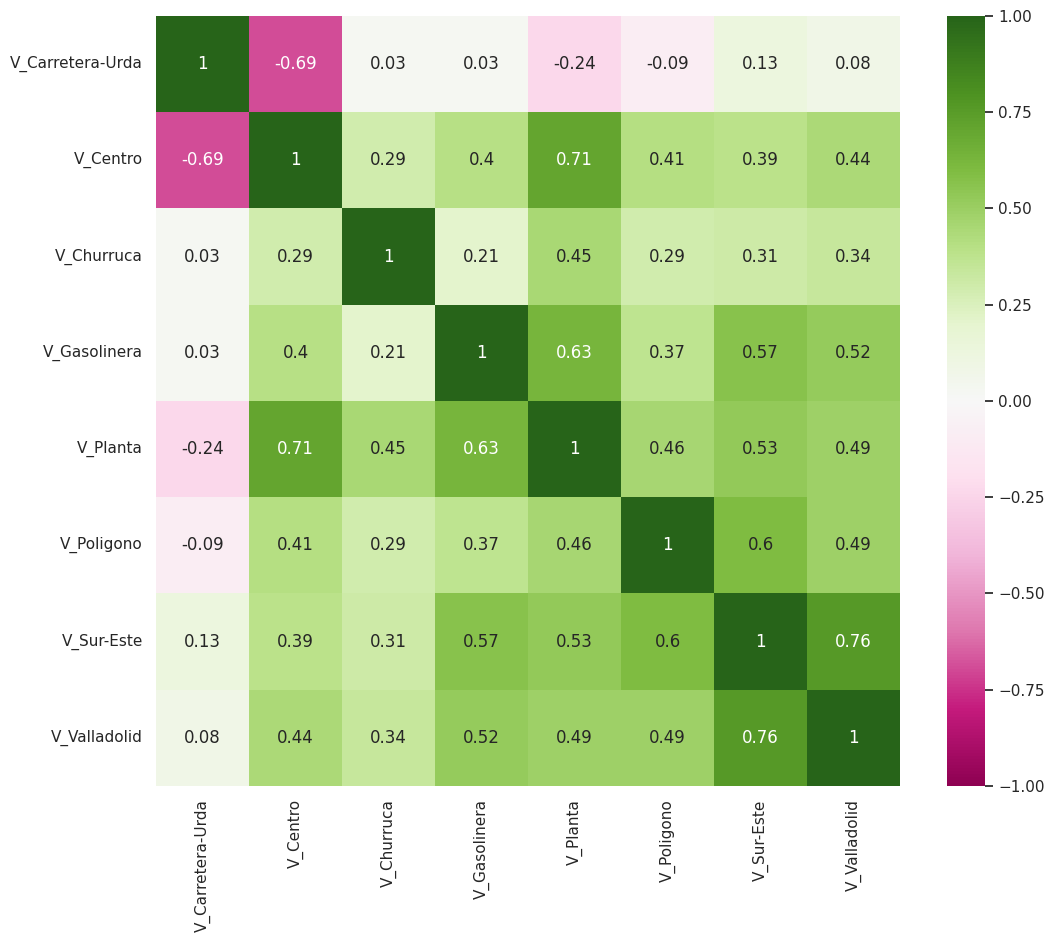

In [259]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(9,17))
df_corr =df_1mins[df_1mins['V_Churruca'].notna()].iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<ipython-input-260-79f591bba2b0>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot:>

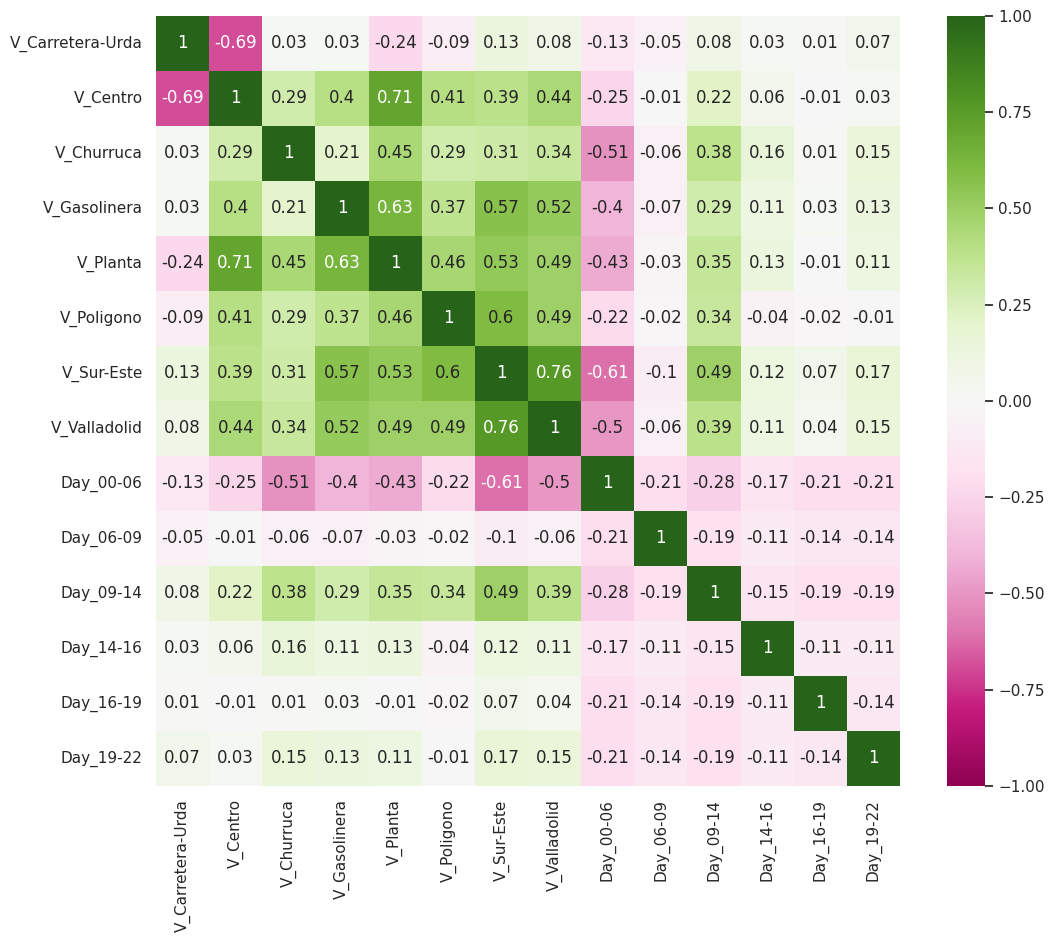

In [260]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(9,24))
df_corr =df_1mins[df_1mins['V_Churruca'].notna()].iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [261]:
'''
cols = list(range(9,17))
df_pp = df_1mins.iloc[:,cols].copy()
sns.pairplot(df_pp, height = 2)
plt.show()
'''

'\ncols = list(range(9,17))\ndf_pp = df_1mins.iloc[:,cols].copy()\nsns.pairplot(df_pp, height = 2)\nplt.show()\n'

In [262]:
#df_1mins = df_1mins.drop(['C_Poligono', 'V_Poligono'], axis=1)

<AxesSubplot:>

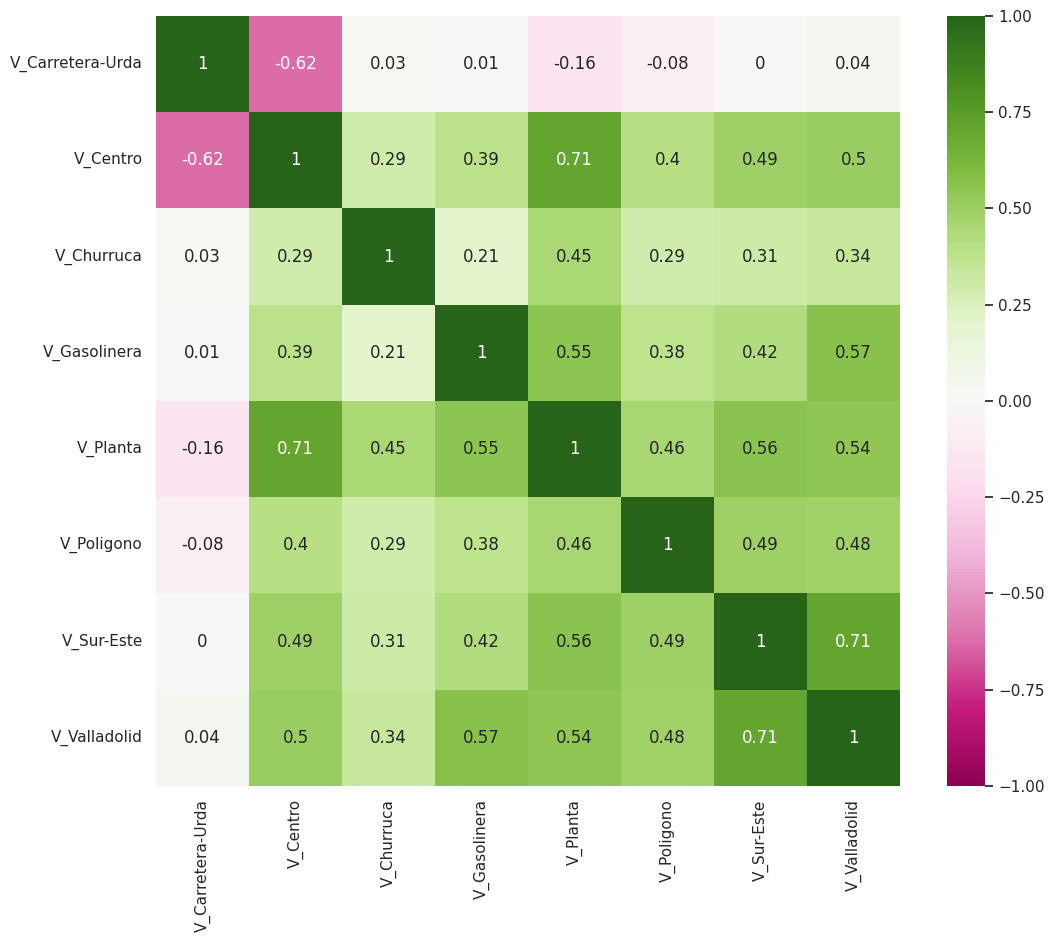

In [263]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(9,17))
df_corr = df_1mins.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [264]:
df_1mins[df_1mins['V_Churruca'].isna()]['RowKey'].unique()

<DatetimeArray>
['2022-01-05 06:15:00+00:00', '2022-01-05 06:30:00+00:00',
 '2022-01-05 06:45:00+00:00', '2022-01-05 07:00:00+00:00',
 '2022-01-05 07:15:00+00:00', '2022-01-05 07:30:00+00:00',
 '2022-01-05 07:45:00+00:00', '2022-01-05 08:00:00+00:00',
 '2022-01-05 08:15:00+00:00', '2022-01-05 08:30:00+00:00',
 ...
 '2022-12-12 04:45:00+00:00', '2022-12-12 05:00:00+00:00',
 '2022-12-12 05:15:00+00:00', '2022-12-12 05:30:00+00:00',
 '2022-12-12 05:45:00+00:00', '2022-12-12 06:00:00+00:00',
 '2022-12-12 06:15:00+00:00', '2022-12-12 06:30:00+00:00',
 '2022-12-12 06:45:00+00:00', '2022-12-12 07:00:00+00:00']
Length: 13678, dtype: datetime64[ns, UTC]

In [265]:
df1[(df1['Canonical']!='TOTALIZADOR')&(df1['STA_Name']=='Churruca')]

Canonical                    RowKey    INF_Label  \
263648                  CAUDAL 2021-08-01 00:15:00+00:00  LS Churruca   
263649                  CAUDAL 2021-08-01 00:30:00+00:00  LS Churruca   
263650                  CAUDAL 2021-08-01 00:45:00+00:00  LS Churruca   
263651                  CAUDAL 2021-08-01 01:00:00+00:00  LS Churruca   
263652                  CAUDAL 2021-08-01 01:15:00+00:00  LS Churruca   
...                        ...                       ...          ...   
331957  PRESION_ENTRADA_SECTOR 2022-11-15 05:00:00+00:00  LS Churruca   
331958  PRESION_ENTRADA_SECTOR 2022-11-15 05:15:00+00:00  LS Churruca   
331959  PRESION_ENTRADA_SECTOR 2022-11-15 05:30:00+00:00  LS Churruca   
331960  PRESION_ENTRADA_SECTOR 2022-11-15 05:45:00+00:00  LS Churruca   
331961  PRESION_ENTRADA_SECTOR 2022-11-15 06:00:00+00:00  LS Churruca   

        INF_Value       STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date  \
263648      42.80  13000 Churruca    22130000    13000  Churruca  2021-08-01   
263649      39.60  13000 Churruca    22130000    13000  Churruca  2021-08-01   
263650      40.00  13000 Churruca    22130000    13000  Churruca  2021-08-01   
263651      38.40  13000 Churruca    22130000    13000  Churruca  2021-08-01   
263652      38.80  13000 Churruca    22130000    13000  Churruca  2021-08-01   
...           ...             ...         ...      ...       ...         ...   
331957       0.00  13000 Churruca    22130000    13000  Churruca  2022-11-15   
331958       0.00  13000 Churruca    22130000    13000  Churruca  2022-11-15   
331959       0.00  13000 Churruca    22130000    13000  Churruca  2022-11-15   
331960       0.00  13000 Churruca    22130000    13000  Churruca  2022-11-15   
331961       0.00  13000 Churruca    22130000    13000  Churruca  2022-11-15   

       RowKey_Time  
263648    00:15:00  
263649    00:30:00  
263650    00:45:00  
263651    01:00:00  
263652    01:15:00  
...            ...  
331957    05:00:00  
331958    05:15:00  
331959    05:30:00  
331960    05:45:00  
331961    06:00:00  

[68314 rows x 10 columns]

### Adding workday info

In [267]:
df_1mins = df_1mins[[x for x in list(df_1mins.columns) if (x.startswith('V_')==True) or (x=='RowKey') or (x.startswith('Day_')==True)]]
df_1mins

RowKey  V_Carretera-Urda  V_Centro  V_Churruca  \
0     2021-08-01 00:15:00+00:00              1.25      1.45       10.70   
1     2021-08-01 00:30:00+00:00              1.18      1.62        9.94   
2     2021-08-01 00:45:00+00:00              1.10      1.62       10.00   
3     2021-08-01 01:00:00+00:00              1.00      1.44        9.56   
4     2021-08-01 01:15:00+00:00              1.14      1.50        9.75   
...                         ...               ...       ...         ...   
47831 2022-12-12 06:00:00+00:00              0.15      1.29         NaN   
47832 2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47833 2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47834 2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47835 2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  \
0               NaN      2.74        1.45         NaN          8.60   
1               NaN      2.44        1.45         NaN          9.00   
2               NaN      2.56        1.45         NaN          8.50   
3               NaN      2.28        1.45         NaN          8.56   
4               NaN      2.34        1.46         NaN          8.31   
...             ...       ...         ...         ...           ...   
47831          0.58      1.59        0.00        6.38          7.20   
47832          0.59       NaN         NaN        6.88           NaN   
47833          0.67       NaN         NaN        7.25           NaN   
47834          0.72       NaN         NaN        8.25           NaN   
47835          0.79       NaN         NaN        8.75           NaN   

       Day_00-06  Day_06-09  Day_09-14  Day_14-16  Day_16-19  Day_19-22  \
0              0          0          0          0          0          0   
1              1          0          0          0          0          0   
2              1          0          0          0          0          0   
3              1          0          0          0          0          0   
4              1          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
47831          0          1          0          0          0          0   
47832          0          1          0          0          0          0   
47833          0          1          0          0          0          0   
47834          0          1          0          0          0          0   
47835          0          1          0          0          0          0   

       Day_22-00  
0              1  
1              0  
2              0  
3              0  
4              0  
...          ...  
47831          0  
47832          0  
47833          0  
47834          0  
47835          0  

[47836 rows x 16 columns]

In [268]:
df_1mins['RowKey_Date'] = df_1mins['RowKey'].apply(lambda x: x.date())
df_1mins['RowKey_Time'] = df_1mins['RowKey'].apply(lambda x: x.time())
df_1mins['RowKey_Time'] = df_1mins['RowKey_Time'].apply(lambda x: str(x))

In [269]:
df_1mins['RowKey_Time'].unique()

array(['00:15:00', '00:30:00', '00:45:00', '01:00:00', '01:15:00',
       '01:30:00', '01:45:00', '02:00:00', '02:15:00', '02:30:00',
       '02:45:00', '03:00:00', '03:15:00', '03:30:00', '03:45:00',
       '04:00:00', '04:15:00', '04:30:00', '04:45:00', '05:00:00',
       '05:15:00', '05:30:00', '05:45:00', '06:00:00', '06:15:00',
       '06:30:00', '06:45:00', '07:00:00', '07:15:00', '07:30:00',
       '07:45:00', '08:00:00', '08:15:00', '08:30:00', '08:45:00',
       '09:00:00', '09:15:00', '09:30:00', '09:45:00', '10:00:00',
       '10:15:00', '10:30:00', '10:45:00', '11:00:00', '11:15:00',
       '11:30:00', '11:45:00', '12:00:00', '12:15:00', '12:30:00',
       '12:45:00', '13:00:00', '13:15:00', '13:30:00', '13:45:00',
       '14:00:00', '14:15:00', '14:30:00', '14:45:00', '15:00:00',
       '15:15:00', '15:30:00', '15:45:00', '16:00:00', '16:15:00',
       '16:30:00', '16:45:00', '17:00:00', '17:15:00', '17:30:00',
       '17:45:00', '18:00:00', '18:15:00', '18:30:00', '18:45:

In [270]:
for i in range(0,df_1mins.shape[0]):
    if df_1mins.loc[i,'RowKey_Time']=='00:00:00':
        df_1mins.loc[i,'RowKey_Date'] = df_1mins.loc[i,'RowKey_Date'] - pd.DateOffset(days=1)

In [271]:
df_1mins

RowKey  V_Carretera-Urda  V_Centro  V_Churruca  \
0     2021-08-01 00:15:00+00:00              1.25      1.45       10.70   
1     2021-08-01 00:30:00+00:00              1.18      1.62        9.94   
2     2021-08-01 00:45:00+00:00              1.10      1.62       10.00   
3     2021-08-01 01:00:00+00:00              1.00      1.44        9.56   
4     2021-08-01 01:15:00+00:00              1.14      1.50        9.75   
...                         ...               ...       ...         ...   
47831 2022-12-12 06:00:00+00:00              0.15      1.29         NaN   
47832 2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47833 2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47834 2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47835 2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  \
0               NaN      2.74        1.45         NaN          8.60   
1               NaN      2.44        1.45         NaN          9.00   
2               NaN      2.56        1.45         NaN          8.50   
3               NaN      2.28        1.45         NaN          8.56   
4               NaN      2.34        1.46         NaN          8.31   
...             ...       ...         ...         ...           ...   
47831          0.58      1.59        0.00        6.38          7.20   
47832          0.59       NaN         NaN        6.88           NaN   
47833          0.67       NaN         NaN        7.25           NaN   
47834          0.72       NaN         NaN        8.25           NaN   
47835          0.79       NaN         NaN        8.75           NaN   

       Day_00-06  Day_06-09  Day_09-14  Day_14-16  Day_16-19  Day_19-22  \
0              0          0          0          0          0          0   
1              1          0          0          0          0          0   
2              1          0          0          0          0          0   
3              1          0          0          0          0          0   
4              1          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
47831          0          1          0          0          0          0   
47832          0          1          0          0          0          0   
47833          0          1          0          0          0          0   
47834          0          1          0          0          0          0   
47835          0          1          0          0          0          0   

       Day_22-00 RowKey_Date RowKey_Time  
0              1  2021-08-01    00:15:00  
1              0  2021-08-01    00:30:00  
2              0  2021-08-01    00:45:00  
3              0  2021-08-01    01:00:00  
4              0  2021-08-01    01:15:00  
...          ...         ...         ...  
47831          0  2022-12-12    06:00:00  
47832          0  2022-12-12    06:15:00  
47833          0  2022-12-12    06:30:00  
47834          0  2022-12-12    06:45:00  
47835          0  2022-12-12    07:00:00  

[47836 rows x 18 columns]

In [272]:
df_1mins = cicl_tranf_15mins(df_1mins, 'RowKey_Time')

In [273]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "RowKey_Date"
df_1mins['RowKey_Date'] = pd.to_datetime(df_1mins['RowKey_Date'])


<ipython-input-273-f9b4c0df6be3>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
<ipython-input-273-f9b4c0df6be3>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
<ipython-input-273-f9b4c0df6be3>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.


In [274]:
df_1mins7 = pd.merge(df_1mins, df7, how='left', left_on=['RowKey_Date'], right_on=['Fecha'], suffixes=('','_XXX')).drop(columns='Fecha', axis=1)
df_1mins7

RowKey  V_Carretera-Urda  V_Centro  V_Churruca  \
0     2021-08-01 00:15:00+00:00              1.25      1.45       10.70   
1     2021-08-01 00:30:00+00:00              1.18      1.62        9.94   
2     2021-08-01 00:45:00+00:00              1.10      1.62       10.00   
3     2021-08-01 01:00:00+00:00              1.00      1.44        9.56   
4     2021-08-01 01:15:00+00:00              1.14      1.50        9.75   
...                         ...               ...       ...         ...   
47831 2022-12-12 06:00:00+00:00              0.15      1.29         NaN   
47832 2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47833 2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47834 2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47835 2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  \
0               NaN      2.74        1.45         NaN          8.60   
1               NaN      2.44        1.45         NaN          9.00   
2               NaN      2.56        1.45         NaN          8.50   
3               NaN      2.28        1.45         NaN          8.56   
4               NaN      2.34        1.46         NaN          8.31   
...             ...       ...         ...         ...           ...   
47831          0.58      1.59        0.00        6.38          7.20   
47832          0.59       NaN         NaN        6.88           NaN   
47833          0.67       NaN         NaN        7.25           NaN   
47834          0.72       NaN         NaN        8.25           NaN   
47835          0.79       NaN         NaN        8.75           NaN   

       Day_00-06  ...    Clasif_Lab  Clasif_Fest  Lab_PrevioFest  \
0              0  ...  No Laborable   No Festivo               0   
1              1  ...  No Laborable   No Festivo               0   
2              1  ...  No Laborable   No Festivo               0   
3              1  ...  No Laborable   No Festivo               0   
4              1  ...  No Laborable   No Festivo               0   
...          ...  ...           ...          ...             ...   
47831          0  ...     Laborable   No Festivo               0   
47832          0  ...     Laborable   No Festivo               0   
47833          0  ...     Laborable   No Festivo               0   
47834          0  ...     Laborable   No Festivo               0   
47835          0  ...     Laborable   No Festivo               0   

       Lab_PostFest  DiaSem_SIN  DiaSem_COS Dia_SIN Dia_COS  Mes_SIN  Mes_COS  
0                 0       -0.78        0.62    0.00    1.00    -0.50    -0.87  
1                 0       -0.78        0.62    0.00    1.00    -0.50    -0.87  
2                 0       -0.78        0.62    0.00    1.00    -0.50    -0.87  
3                 0       -0.78        0.62    0.00    1.00    -0.50    -0.87  
4                 0       -0.78        0.62    0.00    1.00    -0.50    -0.87  
...             ...         ...         ...     ...     ...      ...      ...  
47831             0        0.00        1.00    0.79   -0.61    -0.50     0.87  
47832             0        0.00        1.00    0.79   -0.61    -0.50     0.87  
47833             0        0.00        1.00    0.79   -0.61    -0.50     0.87  
47834             0        0.00        1.00    0.79   -0.61    -0.50     0.87  
47835             0        0.00        1.00    0.79   -0.61    -0.50     0.87  

[47836 rows x 34 columns]

In [275]:
df_1mins7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47836 entries, 0 to 47835
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   RowKey            47836 non-null  datetime64[ns, UTC]
 1   V_Carretera-Urda  47742 non-null  float64            
 2   V_Centro          39844 non-null  float64            
 3   V_Churruca        34158 non-null  float64            
 4   V_Gasolinera      47326 non-null  float64            
 5   V_Planta          39428 non-null  float64            
 6   V_Poligono        45716 non-null  float64            
 7   V_Sur-Este        47324 non-null  float64            
 8   V_Valladolid      47534 non-null  float64            
 9   Day_00-06         47836 non-null  int64              
 10  Day_06-09         47836 non-null  int64              
 11  Day_09-14         47836 non-null  int64              
 12  Day_14-16         47836 non-null  int64              
 13  D

In [276]:
df_1mins7.iloc[:,range(7,24)]

V_Sur-Este  V_Valladolid  Day_00-06  Day_06-09  Day_09-14  Day_14-16  \
0             NaN          8.60          0          0          0          0   
1             NaN          9.00          1          0          0          0   
2             NaN          8.50          1          0          0          0   
3             NaN          8.56          1          0          0          0   
4             NaN          8.31          1          0          0          0   
...           ...           ...        ...        ...        ...        ...   
47831        6.38          7.20          0          1          0          0   
47832        6.88           NaN          0          1          0          0   
47833        7.25           NaN          0          1          0          0   
47834        8.25           NaN          0          1          0          0   
47835        8.75           NaN          0          1          0          0   

       Day_16-19  Day_19-22  Day_22-00 RowKey_Date RowKey_Time  Time_SIN  \
0              0          0          1  2021-08-01    00:15:00      0.00   
1              0          0          0  2021-08-01    00:30:00      0.07   
2              0          0          0  2021-08-01    00:45:00      0.13   
3              0          0          0  2021-08-01    01:00:00      0.20   
4              0          0          0  2021-08-01    01:15:00      0.26   
...          ...        ...        ...         ...         ...       ...   
47831          0          0          0  2022-12-12    06:00:00      1.00   
47832          0          0          0  2022-12-12    06:15:00      1.00   
47833          0          0          0  2022-12-12    06:30:00      1.00   
47834          0          0          0  2022-12-12    06:45:00      0.99   
47835          0          0          0  2022-12-12    07:00:00      0.98   

       Time_COS   DiaSem  N_DiaMes  N_Mes  N_Ano  
0          1.00  Domingo         1      8   2021  
1          1.00  Domingo         1      8   2021  
2          0.99  Domingo         1      8   2021  
3          0.98  Domingo         1      8   2021  
4          0.97  Domingo         1      8   2021  
...         ...      ...       ...    ...    ...  
47831      0.07    Lunes        12     12   2022  
47832      0.00    Lunes        12     12   2022  
47833     -0.07    Lunes        12     12   2022  
47834     -0.13    Lunes        12     12   2022  
47835     -0.20    Lunes        12     12   2022  

[47836 rows x 17 columns]

### Adding weather data

In [277]:
df6

wdir  temp  maxt  visibility  wspd  solarenergy  mint  precip  \
0   247.13 24.00 30.30       14.80 10.60        24.40 14.20    0.00   
1   205.26 25.80 33.00       14.60 12.40        24.70 15.30    0.00   
2   264.83 27.30 33.00       14.80 16.20        25.30 21.20    0.00   
3   261.25 28.40 35.10       14.80 20.50        25.30 19.60    0.00   
4   253.96 28.60 34.90       14.80 29.70        25.50 22.20    0.00   
..     ...   ...   ...         ...   ...          ...   ...     ...   
493 144.00 10.80 13.20        9.50 11.40         2.80  8.90   11.80   
494 214.13 11.00 14.00       14.30 19.60         6.20  9.90    7.00   
495 255.22 10.50 13.00       14.30 21.50         4.30  8.90    0.60   
496 220.58 12.00 15.70       11.40 28.60         4.10  8.40   31.60   
497 240.63 14.50 16.90       12.70 28.40         3.10 12.60    3.40   

     solarradiation  sealevelpressure   dew  humidity  precipcover  \
0            452.70          1,014.10  3.80     27.87         0.00   
1            456.50          1,015.10  7.70     35.15         0.00   
2            468.30          1,014.60  8.00     30.15         0.00   
3            468.40          1,014.80  5.50     25.73         0.00   
4            471.70          1,010.70  5.80     25.60         0.00   
..              ...               ...   ...       ...          ...   
493           77.40          1,005.20  9.90     94.11        41.67   
494          172.40          1,001.80  9.50     90.65        20.83   
495          119.00          1,009.80  8.40     87.26        13.04   
496          114.90          1,007.30 10.60     91.03        37.50   
497           87.40          1,009.80 12.10     86.12        12.50   

    datetimeStr_Date  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0         2021-08-02                      1           0          0   
1         2021-08-03                      1           0          0   
2         2021-08-04                      0           1          0   
3         2021-08-05                      0           1          0   
4         2021-08-06                      0           1          0   
..               ...                    ...         ...        ...   
493       2022-12-08                      1           0          1   
494       2022-12-09                      1           0          1   
495       2022-12-10                      1           0          1   
496       2022-12-11                      0           0          1   
497       2022-12-12                      0           0          1   

     cond_Overcast  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
493              0  
494              0  
495              0  
496              1  
497              1  

[498 rows x 18 columns]

In [283]:
sel_cols = ['datetimeStr_Date', 'temp','maxt', 'solarenergy', 'mint', 'solarradiation', 'sealevelpressure', 'dew', 'humidity']

In [284]:
df_1mins76 = pd.merge(df_1mins7, df6[sel_cols], how='inner', left_on=['RowKey_Date'], right_on=['datetimeStr_Date'], suffixes=('','_XXX')).drop(columns='datetimeStr_Date', axis=1)
df_1mins76

RowKey  V_Carretera-Urda  V_Centro  V_Churruca  \
0     2021-08-02 00:15:00+00:00              1.10      1.59       11.19   
1     2021-08-02 00:30:00+00:00              1.23      1.66       10.38   
2     2021-08-02 00:45:00+00:00              1.11      1.62       10.00   
3     2021-08-02 01:00:00+00:00              1.13      1.69        9.12   
4     2021-08-02 01:15:00+00:00              1.13      1.44        8.31   
...                         ...               ...       ...         ...   
47735 2022-12-12 06:00:00+00:00              0.15      1.29         NaN   
47736 2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47737 2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47738 2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47739 2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  \
0               NaN      2.80        1.48         NaN          9.69   
1               NaN      2.72        1.48         NaN          9.69   
2               NaN      2.73        1.48         NaN          9.19   
3               NaN      2.25        1.48         NaN          8.81   
4               NaN      1.94        1.48         NaN          8.81   
...             ...       ...         ...         ...           ...   
47735          0.58      1.59        0.00        6.38          7.20   
47736          0.59       NaN         NaN        6.88           NaN   
47737          0.67       NaN         NaN        7.25           NaN   
47738          0.72       NaN         NaN        8.25           NaN   
47739          0.79       NaN         NaN        8.75           NaN   

       Day_00-06  ...  Mes_SIN  Mes_COS  temp  maxt  solarenergy  mint  \
0              0  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
1              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
2              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
3              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
4              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
...          ...  ...      ...      ...   ...   ...          ...   ...   
47735          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47736          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47737          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47738          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47739          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   

      solarradiation sealevelpressure   dew  humidity  
0             452.70         1,014.10  3.80     27.87  
1             452.70         1,014.10  3.80     27.87  
2             452.70         1,014.10  3.80     27.87  
3             452.70         1,014.10  3.80     27.87  
4             452.70         1,014.10  3.80     27.87  
...              ...              ...   ...       ...  
47735          87.40         1,009.80 12.10     86.12  
47736          87.40         1,009.80 12.10     86.12  
47737          87.40         1,009.80 12.10     86.12  
47738          87.40         1,009.80 12.10     86.12  
47739          87.40         1,009.80 12.10     86.12  

[47740 rows x 42 columns]

In [286]:
#file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (DayTime NOT IMPUTED).csv"
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins76 (DayTime NOT IMPUTED).csv"

In [287]:
#df_1mins76.to_csv(file_path, index=False)

### Missing values imputation (Miss Forest)

In [13]:
file_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (DayTime NOT IMPUTED).csv'

In [14]:
df_1mins7 = pd.read_csv(file_path)
df_1mins7

RowKey  V_Carretera-Urda  V_Centro  V_Churruca  \
0      2021-08-02 00:15:00+00:00              1.10      1.59       11.19   
1      2021-08-02 00:30:00+00:00              1.23      1.66       10.38   
2      2021-08-02 00:45:00+00:00              1.11      1.62       10.00   
3      2021-08-02 01:00:00+00:00              1.13      1.69        9.12   
4      2021-08-02 01:15:00+00:00              1.13      1.44        8.31   
...                          ...               ...       ...         ...   
47735  2022-12-12 06:00:00+00:00              0.15      1.29         NaN   
47736  2022-12-12 06:15:00+00:00               NaN       NaN         NaN   
47737  2022-12-12 06:30:00+00:00               NaN       NaN         NaN   
47738  2022-12-12 06:45:00+00:00               NaN       NaN         NaN   
47739  2022-12-12 07:00:00+00:00               NaN       NaN         NaN   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  \
0               NaN      2.80        1.48         NaN          9.69   
1               NaN      2.72        1.48         NaN          9.69   
2               NaN      2.73        1.48         NaN          9.19   
3               NaN      2.25        1.48         NaN          8.81   
4               NaN      1.94        1.48         NaN          8.81   
...             ...       ...         ...         ...           ...   
47735          0.58      1.59        0.00        6.38          7.20   
47736          0.59       NaN         NaN        6.88           NaN   
47737          0.67       NaN         NaN        7.25           NaN   
47738          0.72       NaN         NaN        8.25           NaN   
47739          0.79       NaN         NaN        8.75           NaN   

       Day_00-06  ...  Mes_SIN  Mes_COS  temp  maxt  solarenergy  mint  \
0              0  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
1              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
2              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
3              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
4              1  ...    -0.50    -0.87 24.00 30.30        24.40 14.20   
...          ...  ...      ...      ...   ...   ...          ...   ...   
47735          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47736          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47737          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47738          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   
47739          0  ...    -0.50     0.87 14.50 16.90         3.10 12.60   

      solarradiation sealevelpressure   dew  humidity  
0             452.70         1,014.10  3.80     27.87  
1             452.70         1,014.10  3.80     27.87  
2             452.70         1,014.10  3.80     27.87  
3             452.70         1,014.10  3.80     27.87  
4             452.70         1,014.10  3.80     27.87  
...              ...              ...   ...       ...  
47735          87.40         1,009.80 12.10     86.12  
47736          87.40         1,009.80 12.10     86.12  
47737          87.40         1,009.80 12.10     86.12  
47738          87.40         1,009.80 12.10     86.12  
47739          87.40         1,009.80 12.10     86.12  

[47740 rows x 42 columns]

In [15]:
df_1mins7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowKey            47740 non-null  object 
 1   V_Carretera-Urda  47646 non-null  float64
 2   V_Centro          39748 non-null  float64
 3   V_Churruca        34062 non-null  float64
 4   V_Gasolinera      47326 non-null  float64
 5   V_Planta          39332 non-null  float64
 6   V_Poligono        45620 non-null  float64
 7   V_Sur-Este        47324 non-null  float64
 8   V_Valladolid      47438 non-null  float64
 9   Day_00-06         47740 non-null  int64  
 10  Day_06-09         47740 non-null  int64  
 11  Day_09-14         47740 non-null  int64  
 12  Day_14-16         47740 non-null  int64  
 13  Day_16-19         47740 non-null  int64  
 14  Day_19-22         47740 non-null  int64  
 15  Day_22-00         47740 non-null  int64  
 16  RowKey_Date       47740 non-null  object

In [16]:
miss_info(df_1mins7)

col_name   dtypes    nan  perc_nan  not_nan  perc_not_nan  \
0             RowKey   object      0      0.00    47740        100.00   
1   V_Carretera-Urda  float64     94      0.20    47646         99.80   
2           V_Centro  float64   7992     16.74    39748         83.26   
3         V_Churruca  float64  13678     28.65    34062         71.35   
4       V_Gasolinera  float64    414      0.87    47326         99.13   
5           V_Planta  float64   8408     17.61    39332         82.39   
6         V_Poligono  float64   2120      4.44    45620         95.56   
7         V_Sur-Este  float64    416      0.87    47324         99.13   
8       V_Valladolid  float64    302      0.63    47438         99.37   
9          Day_00-06    int64      0      0.00    47740        100.00   
10         Day_06-09    int64      0      0.00    47740        100.00   
11         Day_09-14    int64      0      0.00    47740        100.00   
12         Day_14-16    int64      0      0.00    47740        100.00   
13         Day_16-19    int64      0      0.00    47740        100.00   
14         Day_19-22    int64      0      0.00    47740        100.00   
15         Day_22-00    int64      0      0.00    47740        100.00   
16       RowKey_Date   object      0      0.00    47740        100.00   
17       RowKey_Time   object      0      0.00    47740        100.00   
18          Time_SIN  float64      0      0.00    47740        100.00   
19          Time_COS  float64      0      0.00    47740        100.00   
20            DiaSem   object      0      0.00    47740        100.00   
21          N_DiaMes    int64      0      0.00    47740        100.00   
22             N_Mes    int64      0      0.00    47740        100.00   
23             N_Ano    int64      0      0.00    47740        100.00   
24        Clasif_Lab   object      0      0.00    47740        100.00   
25       Clasif_Fest   object      0      0.00    47740        100.00   
26    Lab_PrevioFest    int64      0      0.00    47740        100.00   
27      Lab_PostFest    int64      0      0.00    47740        100.00   
28        DiaSem_SIN  float64      0      0.00    47740        100.00   
29        DiaSem_COS  float64      0      0.00    47740        100.00   
30           Dia_SIN  float64      0      0.00    47740        100.00   
31           Dia_COS  float64      0      0.00    47740        100.00   
32           Mes_SIN  float64      0      0.00    47740        100.00   
33           Mes_COS  float64      0      0.00    47740        100.00   
34              temp  float64      0      0.00    47740        100.00   
35              maxt  float64      0      0.00    47740        100.00   
36       solarenergy  float64      0      0.00    47740        100.00   
37              mint  float64      0      0.00    47740        100.00   
38    solarradiation  float64      0      0.00    47740        100.00   
39  sealevelpressure  float64      0      0.00    47740        100.00   
40               dew  float64      0      0.00    47740        100.00   
41          humidity  float64      0      0.00    47740        100.00   

    zero_values  unique_values neg_values  
0          0.00          47740         NA  
1      2,519.00           1541          0  
2      7,390.00           4734          0  
3      2,627.00            749          0  
4      1,319.00            684          0  
5      3,648.00           7789          0  
6         52.00           1393          0  
7         34.00            533          0  
8      2,006.00           1502          0  
9     36,784.00              2         NA  
10    41,771.00              2         NA  
11    37,800.00              2         NA  
12    43,764.00              2         NA  
13    41,776.00              2         NA  
14    41,776.00              2         NA  
15    42,769.00              2         NA  
16         0.00            498         NA  
17         0.00             96         NA  
18       498.00             88      

In [17]:
cat_vars = list(df_1mins7.select_dtypes(exclude=["number"]).columns)
cat_vars

['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest']

In [18]:
num_vars = list(df_1mins7.select_dtypes(include=["number"]).columns)
num_vars

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid',
 'Day_00-06',
 'Day_06-09',
 'Day_09-14',
 'Day_14-16',
 'Day_16-19',
 'Day_19-22',
 'Day_22-00',
 'Time_SIN',
 'Time_COS',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'temp',
 'maxt',
 'solarenergy',
 'mint',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity']

In [19]:
df_1mins7.columns

Index(['RowKey', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera',
       'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid', 'Day_00-06',
       'Day_06-09', 'Day_09-14', 'Day_14-16', 'Day_16-19', 'Day_19-22',
       'Day_22-00', 'RowKey_Date', 'RowKey_Time', 'Time_SIN', 'Time_COS',
       'DiaSem', 'N_DiaMes', 'N_Mes', 'N_Ano', 'Clasif_Lab', 'Clasif_Fest',
       'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN',
       'Dia_COS', 'Mes_SIN', 'Mes_COS', 'temp', 'maxt', 'solarenergy', 'mint',
       'solarradiation', 'sealevelpressure', 'dew', 'humidity'],
      dtype='object')

In [20]:
cat_cols = df_1mins7[cat_vars]
cat_cols = cat_cols.drop(columns=['RowKey','RowKey_Date','RowKey_Time'], axis=1)
cat_cols.head()

DiaSem Clasif_Lab Clasif_Fest
0  Lunes  Laborable  No Festivo
1  Lunes  Laborable  No Festivo
2  Lunes  Laborable  No Festivo
3  Lunes  Laborable  No Festivo
4  Lunes  Laborable  No Festivo

In [21]:
num_cols = df_1mins7[num_vars]
num_cols.head()

V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  \
0              1.10      1.59       11.19           NaN      2.80        1.48   
1              1.23      1.66       10.38           NaN      2.72        1.48   
2              1.11      1.62       10.00           NaN      2.73        1.48   
3              1.13      1.69        9.12           NaN      2.25        1.48   
4              1.13      1.44        8.31           NaN      1.94        1.48   

   V_Sur-Este  V_Valladolid  Day_00-06  Day_06-09  ...  Mes_SIN  Mes_COS  \
0         NaN          9.69          0          0  ...    -0.50    -0.87   
1         NaN          9.69          1          0  ...    -0.50    -0.87   
2         NaN          9.19          1          0  ...    -0.50    -0.87   
3         NaN          8.81          1          0  ...    -0.50    -0.87   
4         NaN          8.81          1          0  ...    -0.50    -0.87   

   temp  maxt  solarenergy  mint  solarradiation  sealevelpressure  dew  \
0 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
1 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
2 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
3 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
4 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   

   humidity  
0     27.87  
1     27.87  
2     27.87  
3     27.87  
4     27.87  

[5 rows x 36 columns]

In [22]:
ohe = OneHotEncoder(sparse=False)

In [23]:
ohe.fit(cat_cols)

OneHotEncoder(sparse=False)

In [24]:
cat_cols_values = ohe.transform(cat_cols)

In [25]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc

0    1    2    3    4    5    6    7    8    9    10
0     0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
1     0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
2     0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
3     0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
4     0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
47735 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
47736 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
47737 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
47738 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
47739 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00

[47740 rows x 11 columns]

In [26]:
df_1mins7_enc = cat_cols_enc.join(num_cols)
df_1mins7_enc.head()

0    1    2    3    4    5    6    7    8    9  ...  Mes_SIN  Mes_COS  \
0 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
1 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
2 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
3 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
4 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   

   temp  maxt  solarenergy  mint  solarradiation  sealevelpressure  dew  \
0 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
1 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
2 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
3 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
4 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   

   humidity  
0     27.87  
1     27.87  
2     27.87  
3     27.87  
4     27.87  

[5 rows x 47 columns]

In [27]:
#Miss Forest
imputer = MissForest(random_state=0)

In [28]:
# Make an instance and perform the imputation
df_1mins7_imp = imputer.fit_transform(X=df_1mins7_enc)

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 0


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 1


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 2


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 3


In [29]:
df_1mins7_imp

array([[0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0141e+03, 3.8000e+00,
        2.7870e+01],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0141e+03, 3.8000e+00,
        2.7870e+01],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0141e+03, 3.8000e+00,
        2.7870e+01],
       ...,
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0098e+03, 1.2100e+01,
        8.6120e+01],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0098e+03, 1.2100e+01,
        8.6120e+01],
       [0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0098e+03, 1.2100e+01,
        8.6120e+01]])

In [30]:
df_1mins7_imp = pd.DataFrame(df_1mins7_imp, columns=df_1mins7_enc.columns)
df_1mins7_imp.head()

0    1    2    3    4    5    6    7    8    9  ...  Mes_SIN  Mes_COS  \
0 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
1 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
2 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
3 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   
4 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...    -0.50    -0.87   

   temp  maxt  solarenergy  mint  solarradiation  sealevelpressure  dew  \
0 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
1 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
2 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
3 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   
4 24.00 30.30        24.40 14.20          452.70          1,014.10 3.80   

   humidity  
0     27.87  
1     27.87  
2     27.87  
3     27.87  
4     27.87  

[5 rows x 47 columns]

In [31]:
list(df_1mins7_imp.columns)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 'V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid',
 'Day_00-06',
 'Day_06-09',
 'Day_09-14',
 'Day_14-16',
 'Day_16-19',
 'Day_19-22',
 'Day_22-00',
 'Time_SIN',
 'Time_COS',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'temp',
 'maxt',
 'solarenergy',
 'mint',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity']

In [32]:
sel_cols = [x for x in list(df_1mins7_imp.columns) if type(x)!=int]
sel_cols

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid',
 'Day_00-06',
 'Day_06-09',
 'Day_09-14',
 'Day_14-16',
 'Day_16-19',
 'Day_19-22',
 'Day_22-00',
 'Time_SIN',
 'Time_COS',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'temp',
 'maxt',
 'solarenergy',
 'mint',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity']

In [33]:
df_1mins7_imp = df_1mins7_imp[sel_cols]

In [34]:
df_1mins7_imp = cat_cols.join(df_1mins7_imp)
df_1mins7_imp = df_1mins7[['RowKey','RowKey_Date','RowKey_Time']].join(df_1mins7_imp)
df_1mins7_imp.head()

RowKey RowKey_Date RowKey_Time DiaSem Clasif_Lab  \
0  2021-08-02 00:15:00+00:00  2021-08-02    00:15:00  Lunes  Laborable   
1  2021-08-02 00:30:00+00:00  2021-08-02    00:30:00  Lunes  Laborable   
2  2021-08-02 00:45:00+00:00  2021-08-02    00:45:00  Lunes  Laborable   
3  2021-08-02 01:00:00+00:00  2021-08-02    01:00:00  Lunes  Laborable   
4  2021-08-02 01:15:00+00:00  2021-08-02    01:15:00  Lunes  Laborable   

  Clasif_Fest  V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  ...  \
0  No Festivo              1.10      1.59       11.19          1.35  ...   
1  No Festivo              1.23      1.66       10.38          1.35  ...   
2  No Festivo              1.11      1.62       10.00          1.32  ...   
3  No Festivo              1.13      1.69        9.12          1.30  ...   
4  No Festivo              1.13      1.44        8.31          1.26  ...   

   Mes_SIN  Mes_COS  temp  maxt  solarenergy  mint  solarradiation  \
0    -0.50    -0.87 24.00 30.30        24.40 14.20          452.70   
1    -0.50    -0.87 24.00 30.30        24.40 14.20          452.70   
2    -0.50    -0.87 24.00 30.30        24.40 14.20          452.70   
3    -0.50    -0.87 24.00 30.30        24.40 14.20          452.70   
4    -0.50    -0.87 24.00 30.30        24.40 14.20          452.70   

   sealevelpressure  dew  humidity  
0          1,014.10 3.80     27.87  
1          1,014.10 3.80     27.87  
2          1,014.10 3.80     27.87  
3          1,014.10 3.80     27.87  
4          1,014.10 3.80     27.87  

[5 rows x 42 columns]

In [35]:
miss_info(df_1mins7_imp)

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0             RowKey   object    0      0.00    47740        100.00   
1        RowKey_Date   object    0      0.00    47740        100.00   
2        RowKey_Time   object    0      0.00    47740        100.00   
3             DiaSem   object    0      0.00    47740        100.00   
4         Clasif_Lab   object    0      0.00    47740        100.00   
5        Clasif_Fest   object    0      0.00    47740        100.00   
6   V_Carretera-Urda  float64    0      0.00    47740        100.00   
7           V_Centro  float64    0      0.00    47740        100.00   
8         V_Churruca  float64    0      0.00    47740        100.00   
9       V_Gasolinera  float64    0      0.00    47740        100.00   
10          V_Planta  float64    0      0.00    47740        100.00   
11        V_Poligono  float64    0      0.00    47740        100.00   
12        V_Sur-Este  float64    0      0.00    47740        100.00   
13      V_Valladolid  float64    0      0.00    47740        100.00   
14         Day_00-06  float64    0      0.00    47740        100.00   
15         Day_06-09  float64    0      0.00    47740        100.00   
16         Day_09-14  float64    0      0.00    47740        100.00   
17         Day_14-16  float64    0      0.00    47740        100.00   
18         Day_16-19  float64    0      0.00    47740        100.00   
19         Day_19-22  float64    0      0.00    47740        100.00   
20         Day_22-00  float64    0      0.00    47740        100.00   
21          Time_SIN  float64    0      0.00    47740        100.00   
22          Time_COS  float64    0      0.00    47740        100.00   
23          N_DiaMes  float64    0      0.00    47740        100.00   
24             N_Mes  float64    0      0.00    47740        100.00   
25             N_Ano  float64    0      0.00    47740        100.00   
26    Lab_PrevioFest  float64    0      0.00    47740        100.00   
27      Lab_PostFest  float64    0      0.00    47740        100.00   
28        DiaSem_SIN  float64    0      0.00    47740        100.00   
29        DiaSem_COS  float64    0      0.00    47740        100.00   
30           Dia_SIN  float64    0      0.00    47740        100.00   
31           Dia_COS  float64    0      0.00    47740        100.00   
32           Mes_SIN  float64    0      0.00    47740        100.00   
33           Mes_COS  float64    0      0.00    47740        100.00   
34              temp  float64    0      0.00    47740        100.00   
35              maxt  float64    0      0.00    47740        100.00   
36       solarenergy  float64    0      0.00    47740        100.00   
37              mint  float64    0      0.00    47740        100.00   
38    solarradiation  float64    0      0.00    47740        100.00   
39  sealevelpressure  float64    0      0.00    47740        100.00   
40               dew  float64    0      0.00    47740        100.00   
41          humidity  float64    0      0.00    47740        100.00   

    zero_values  unique_values neg_values  
0          0.00          47740         NA  
1          0.00            498         NA  
2          0.00             96         NA  
3          0.00              7         NA  
4          0.00              2         NA  
5          0.00              2         NA  
6      2,519.00           1634          0  
7      9,834.00          10280          0  
8     10,483.00           4520          0  
9      1,319.00           1092          0  
10     4,048.00          15115          0  
11        52.00           3441          0  
12        34.00            948          0  
13     2,006.00           1802          0  
14    36,784.00              2          0  
15    41,771.00              2          0  
16    37,800.00              2          0  
17    43,764.00              2          0  
18    41,776.00              2          0  
19    41,776.00              2          0  
20    42,769.00              2    

In [36]:
file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (DayTime IMPUTED).csv"

In [37]:
#df_1mins7_imp.to_csv(file_path, index=False)

## DATASET 1 PREPARATION: 'Daily volume'



### Obtaining 'Daily volume'

In [ ]:
df1[(df1['RowKey_Date']=='2021-08-20')&(df1['RowKey_Time']=='00:00:00')]

Canonical                    RowKey  \
1823                      CAUDAL 2021-08-20 00:00:00+00:00   
49565     PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
97306                TOTALIZADOR 2021-08-20 00:00:00+00:00   
143243            VOLUMEN_DIARIO 2021-08-20 00:00:00+00:00   
145524                    CAUDAL 2021-08-20 00:00:00+00:00   
185368    PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
225212               TOTALIZADOR 2021-08-20 00:00:00+00:00   
263251            VOLUMEN_DIARIO 2021-08-20 00:00:00+00:00   
265471                    CAUDAL 2021-08-20 00:00:00+00:00   
299629    PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
333785               TOTALIZADOR 2021-08-20 00:00:00+00:00   
366690                  DEPOSITO 2021-08-20 00:00:00+00:00   
413765    DEPOSITO_CAUDAL_SALIDA 2021-08-20 00:00:00+00:00   
459840           DEPOSITO_METROS 2021-08-20 00:00:00+00:00   
504363   DEPOSITO_VOLUMEN_SALIDA 2021-08-20 00:00:00+00:00   
514404                    CAUDAL 2021-08-20 00:00:00+00:00   
562663                    CAUDAL 2021-08-20 00:00:00+00:00   
602092    PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
642521               TOTALIZADOR 2021-08-20 00:00:00+00:00   
681145            VOLUMEN_DIARIO 2021-08-20 00:00:00+00:00   
681982                    CAUDAL 2021-08-20 00:00:00+00:00   
692974                   VOLUMEN 2021-08-20 00:00:00+00:00   
694816                    CAUDAL 2021-08-20 00:00:00+00:00   
741142    PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
788468     PRESION_SALIDA_SECTOR 2021-08-20 00:00:00+00:00   
834794               TOTALIZADOR 2021-08-20 00:00:00+00:00   
883053                    CAUDAL 2021-08-20 00:00:00+00:00   
930587    PRESION_ENTRADA_SECTOR 2021-08-20 00:00:00+00:00   
978120               TOTALIZADOR 2021-08-20 00:00:00+00:00   
1023749           VOLUMEN_DIARIO 2021-08-20 00:00:00+00:00   

                    INF_Label  INF_Value             STA_Label Sector_Neta  \
1823                  LS Urda       2.28  11000 Carretera Urda    22110000   
49565                 LS Urda       4.07  11000 Carretera Urda    22110000   
97306                 LS Urda   5,447.44  11000 Carretera Urda    22110000   
143243                LS Urda      70.95  11000 Carretera Urda    22110000   
145524              LS Centro       7.56          13210 Centro    22132100   
185368              LS Centro       1.79          13210 Centro    22132100   
225212              LS Centro 400,581.19          13210 Centro    22132100   
263251              LS Centro     206.17          13210 Centro    22132100   
265471            LS Churruca      46.80        13000 Churruca    22130000   
299629            LS Churruca       0.03        13000 Churruca    22130000   
333785            LS Churruca 973,821.50        13000 Churruca    22130000   
366690    CO:Nivel Deposito %      98.24        88001 Deposito    22880010   
413765          Caudal Salida     120.00        88001 Deposito    22880010   
459840   AI: Nivel Deposito m       3.83        88001 Deposito    22880010   
504363         Volumen Salida   3,447.00        88001 Deposito    22880010   
514404          LS Gasolinera       4.96      12100 Gasolinera    22121000   
562663              LS Planta      10.92          13100 Planta    22131000   
602092              LS Planta       0.01          13100 Planta    22131000   
642521              LS Planta 263,555.91          13100 Planta    22131000   
681145              LS Planta     340.49          13100 Planta    22131000   
681982            LS Poligono       5.93        12210 Poligono    22122100   
692974            LS Poligono     157.13        12210 Poligono    22122100   
694816           LS-V Sureste      20.16        12200 Sur Este    22122000   
741142           LS-V Sureste       0.18        12200 Sur Este    22122000   
788468           LS-V Sureste       3.63        12200 Sur Este    22122000   
834794           LS-V Sureste 798,732.62        12200 Sur Este    221220

In [ ]:
df1[((df1['RowKey_Time']=='00:00:00')|(df1['RowKey_Time']=='00:15:00'))].head()

Canonical                    RowKey INF_Label  INF_Value  \
0      CAUDAL 2021-08-01 00:15:00+00:00   LS Urda       5.00   
95     CAUDAL 2021-08-02 00:00:00+00:00   LS Urda       4.84   
96     CAUDAL 2021-08-02 00:15:00+00:00   LS Urda       4.40   
191    CAUDAL 2021-08-03 00:00:00+00:00   LS Urda       4.16   
192    CAUDAL 2021-08-03 00:15:00+00:00   LS Urda       4.24   

                STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
0    11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-02   
96   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-02   
191  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-03   
192  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-03   

    RowKey_Time  
0      00:15:00  
95     00:00:00  
96     00:15:00  
191    00:00:00  
192    00:15:00

In [ ]:
df_out = df1.copy()

In [ ]:
df1[((df1['RowKey_Time']=='00:00:00')|(df1['RowKey_Time']=='00:15:00'))].head()

Canonical                    RowKey INF_Label  INF_Value  \
0      CAUDAL 2021-08-01 00:15:00+00:00   LS Urda       5.00   
95     CAUDAL 2021-08-02 00:00:00+00:00   LS Urda       4.84   
96     CAUDAL 2021-08-02 00:15:00+00:00   LS Urda       4.40   
191    CAUDAL 2021-08-03 00:00:00+00:00   LS Urda       4.16   
192    CAUDAL 2021-08-03 00:15:00+00:00   LS Urda       4.24   

                STA_Label Sector_Neta STA_Code        STA_Name RowKey_Date  \
0    11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
95   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-01   
96   11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-02   
191  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-02   
192  11000 Carretera Urda    22110000    11000  Carretera Urda  2021-08-03   

    RowKey_Time  
0      00:15:00  
95     00:00:00  
96     00:15:00  
191    00:00:00  
192    00:15:00

In [ ]:
df_out[(df_out['RowKey_Date']=='2021-08-20')&(df_out['RowKey_Time']=='00:00:00')]

Canonical                    RowKey  \
1919                      CAUDAL 2021-08-21 00:00:00+00:00   
49661     PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
97402                TOTALIZADOR 2021-08-21 00:00:00+00:00   
143244            VOLUMEN_DIARIO 2021-08-21 00:00:00+00:00   
145620                    CAUDAL 2021-08-21 00:00:00+00:00   
185464    PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
225308               TOTALIZADOR 2021-08-21 00:00:00+00:00   
263252            VOLUMEN_DIARIO 2021-08-21 00:00:00+00:00   
265567                    CAUDAL 2021-08-21 00:00:00+00:00   
299725    PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
333881               TOTALIZADOR 2021-08-21 00:00:00+00:00   
366786                  DEPOSITO 2021-08-21 00:00:00+00:00   
413861    DEPOSITO_CAUDAL_SALIDA 2021-08-21 00:00:00+00:00   
459936           DEPOSITO_METROS 2021-08-21 00:00:00+00:00   
504364   DEPOSITO_VOLUMEN_SALIDA 2021-08-21 00:00:00+00:00   
514500                    CAUDAL 2021-08-21 00:00:00+00:00   
562774                    CAUDAL 2021-08-21 00:00:00+00:00   
602188    PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
642617               TOTALIZADOR 2021-08-21 00:00:00+00:00   
681146            VOLUMEN_DIARIO 2021-08-21 00:00:00+00:00   
682006                    CAUDAL 2021-08-21 00:00:00+00:00   
692975                   VOLUMEN 2021-08-21 00:00:00+00:00   
694912                    CAUDAL 2021-08-21 00:00:00+00:00   
741238    PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
788564     PRESION_SALIDA_SECTOR 2021-08-21 00:00:00+00:00   
834890               TOTALIZADOR 2021-08-21 00:00:00+00:00   
883149                    CAUDAL 2021-08-21 00:00:00+00:00   
930683    PRESION_ENTRADA_SECTOR 2021-08-21 00:00:00+00:00   
978216               TOTALIZADOR 2021-08-21 00:00:00+00:00   
1023750           VOLUMEN_DIARIO 2021-08-21 00:00:00+00:00   

                    INF_Label  INF_Value             STA_Label Sector_Neta  \
1919                  LS Urda       1.96  11000 Carretera Urda    22110000   
49661                 LS Urda       3.93  11000 Carretera Urda    22110000   
97402                 LS Urda   5,503.56  11000 Carretera Urda    22110000   
143244                LS Urda      56.12  11000 Carretera Urda    22110000   
145620              LS Centro       7.84          13210 Centro    22132100   
185464              LS Centro       1.08          13210 Centro    22132100   
225308              LS Centro 400,802.91          13210 Centro    22132100   
263252              LS Centro     221.70          13210 Centro    22132100   
265567            LS Churruca      42.80        13000 Churruca    22130000   
299725            LS Churruca       0.04        13000 Churruca    22130000   
333881            LS Churruca 975,339.12        13000 Churruca    22130000   
366786    CO:Nivel Deposito %      91.11        88001 Deposito    22880010   
413861          Caudal Salida     120.00        88001 Deposito    22880010   
459936   AI: Nivel Deposito m       3.55        88001 Deposito    22880010   
504364         Volumen Salida   3,739.00        88001 Deposito    22880010   
514500          LS Gasolinera       4.68      12100 Gasolinera    22121000   
562774              LS Planta      10.12          13100 Planta    22131000   
602188              LS Planta       0.01          13100 Planta    22131000   
642617              LS Planta 263,976.97          13100 Planta    22131000   
681146              LS Planta     421.05          13100 Planta    22131000   
682006            LS Poligono       6.06        12210 Poligono    22122100   
692975            LS Poligono     182.10        12210 Poligono    22122100   
694912           LS-V Sureste      21.64        12200 Sur Este    22122000   
741238           LS-V Sureste       0.18        12200 Sur Este    22122000   
788564           LS-V Sureste       3.64        12200 Sur Este    22122000   
834890           LS-V Sureste 799,411.50        12200 Sur Este    221220

In [ ]:
'''
CREAR FUNCIÓN QUE EXTRAIGA:
 - VOLUMEN_DIARIO -> Hay algunos sectores de los q se puede extraer directamente "VOLUMEN_DIARIO", otros filtrando "VOLUMEN"+"00:00:00", otros hay q calcularlo con el "TOTALIZADOR"+"00:00:00"
                     (si "TOTALIZADOR"=0 entonces "VOLUMEN_DIARIO"=0)
 - CAUDAL_MEDIO -> Calcular el caudal medio del día o coger el de las "00:00:00" ("CAUDAL")
 - PRESIÓN ENTRADA_MEDIA -> Calcular la presión de entrada media o coger la de las "00:00:00" ("PRESION_ENTRADA_SECTOR")
 - PRESIÓN_SALIDA_MEDIA -> Calcular la presión de entrada media o coger la de las "00:00:00" ("PRESION_SALIDA_SECTOR")

 - DATOS DE DEPÓSITO -> Estudiar como podemos utilizar los datos del depósito para las predicciones
      DEPOSITO (CO:Nivel Deposito %) -> MEDIDA CADA 15 mins
      DEPOSITO_CAUDAL_SALIDA (Caudal Salida) -> MEDIDA CADA 15 mins
      DEPOSITO_METROS (AI: Nivel Deposito m) -> MEDIDA CADA 15 mins
      DEPOSITO_VOLUMEN_SALIDA (Volumen Salida) -> 1 MEDIDA DIARIA
'''

'\nCREAR FUNCIÓN QUE EXTRAIGA:\n - VOLUMEN_DIARIO -> Hay algunos sectores de los q se puede extraer directamente "VOLUMEN_DIARIO", otros filtrando "VOLUMEN"+"00:00:00", otros hay q calcularlo con el "TOTALIZADOR"+"00:00:00"\n                     (si "TOTALIZADOR"=0 entonces "VOLUMEN_DIARIO"=0)\n - CAUDAL_MEDIO -> Calcular el caudal medio del día o coger el de las "00:00:00" ("CAUDAL")\n - PRESIÓN ENTRADA_MEDIA -> Calcular la presión de entrada media o coger la de las "00:00:00" ("PRESION_ENTRADA_SECTOR")\n - PRESIÓN_SALIDA_MEDIA -> Calcular la presión de entrada media o coger la de las "00:00:00" ("PRESION_SALIDA_SECTOR")\n\n - DATOS DE DEPÓSITO -> Estudiar como podemos utilizar los datos del depósito para las predicciones\n      DEPOSITO (CO:Nivel Deposito %) -> MEDIDA CADA 15 mins\n      DEPOSITO_CAUDAL_SALIDA (Caudal Salida) -> MEDIDA CADA 15 mins\n      DEPOSITO_METROS (AI: Nivel Deposito m) -> MEDIDA CADA 15 mins\n      DEPOSITO_VOLUMEN_SALIDA (Volumen Salida) -> 1 MEDIDA DIARIA\n

In [ ]:
df_struct = pd.DataFrame()

start_date = dt.date(2021, 8, 2)
end_date = dt.date(2022, 12, 12)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

i = 0
for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  df_struct.loc[i, 'RowKey_Date'] = day
  i += 1

df_struct

RowKey_Date
0    2021-08-02
1    2021-08-03
2    2021-08-04
3    2021-08-05
4    2021-08-06
..          ...
493  2022-12-08
494  2022-12-09
495  2022-12-10
496  2022-12-11
497  2022-12-12

[498 rows x 1 columns]

In [ ]:
sectors_list = list(df1['STA_Name'].unique())
#sectors_list = [x.replace(' ', '-') for x in sectors_list]
sectors_list.remove('Deposito')
#sectors_list.insert(len(sectors_list), 'Deposito')
sectors_list

['Carretera Urda',
 'Centro',
 'Churruca',
 'Gasolinera',
 'Planta',
 'Poligono',
 'Sur Este',
 'Valladolid']

In [ ]:
for x in sectors_list:

  column_name = 'VD_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'C_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'PE_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  if x == 'Sur Este':
    column_name = 'PS_' + x.replace(' ', '-')
    df_struct[column_name] = np.nan

df_struct['NP-1_Deposito'] = np.nan
df_struct['CS-1_Deposito'] = np.nan
df_struct['NM-1_Deposito'] = np.nan
df_struct['VS-1_Deposito'] = np.nan


In [ ]:
df_struct

RowKey_Date  VD_Carretera-Urda  C_Carretera-Urda  PE_Carretera-Urda  \
0    2021-08-02                NaN               NaN                NaN   
1    2021-08-03                NaN               NaN                NaN   
2    2021-08-04                NaN               NaN                NaN   
3    2021-08-05                NaN               NaN                NaN   
4    2021-08-06                NaN               NaN                NaN   
..          ...                ...               ...                ...   
493  2022-12-08                NaN               NaN                NaN   
494  2022-12-09                NaN               NaN                NaN   
495  2022-12-10                NaN               NaN                NaN   
496  2022-12-11                NaN               NaN                NaN   
497  2022-12-12                NaN               NaN                NaN   

     VD_Centro  C_Centro  PE_Centro  VD_Churruca  C_Churruca  PE_Churruca  \
0          NaN       NaN        NaN          NaN         NaN          NaN   
1          NaN       NaN        NaN          NaN         NaN          NaN   
2          NaN       NaN        NaN          NaN         NaN          NaN   
3          NaN       NaN        NaN          NaN         NaN          NaN   
4          NaN       NaN        NaN          NaN         NaN          NaN   
..         ...       ...        ...          ...         ...          ...   
493        NaN       NaN        NaN          NaN         NaN          NaN   
494        NaN       NaN        NaN          NaN         NaN          NaN   
495        NaN       NaN        NaN          NaN         NaN          NaN   
496        NaN       NaN        NaN          NaN         NaN          NaN   
497        NaN       NaN        NaN          NaN         NaN          NaN   

     ...  C_Sur-Este  PE_Sur-Este  PS_Sur-Este  VD_Valladolid  C_Valladolid  \
0    ...         NaN          NaN          NaN            NaN           NaN   
1    ...         NaN          NaN          NaN            NaN           NaN   
2    ...         NaN          NaN          NaN            NaN           NaN   
3    ...         NaN          NaN          NaN            NaN           NaN   
4    ...         NaN          NaN          NaN            NaN           NaN   
..   ...         ...          ...          ...            ...           ...   
493  ...         NaN          NaN          NaN            NaN           NaN   
494  ...         NaN          NaN          NaN            NaN           NaN   
495  ...         NaN          NaN          NaN            NaN           NaN   
496  ...         NaN          NaN          NaN            NaN           NaN   
497  ...         NaN          NaN          NaN            NaN           NaN   

     PE_Valladolid  NP-1_Deposito  CS-1_Deposito  NM-1_Deposito  VS-1_Deposito  
0              NaN            NaN            NaN            NaN            NaN  
1              NaN            NaN            NaN            NaN            NaN  
2              NaN            NaN            NaN            NaN            NaN  
3              NaN            NaN            NaN            NaN            NaN  
4              NaN            NaN            NaN            NaN            NaN  
..             ...            ...            ...            ...            ...  
493            NaN            NaN            NaN            NaN            NaN  
494            NaN            NaN            NaN            NaN            NaN  
495            NaN            NaN            NaN            NaN            NaN  
496            NaN            NaN            NaN            NaN            NaN  
497            NaN            NaN            NaN            NaN            NaN  

[498 rows x 30 columns]

In [ ]:


for i in range(0,df_struct.shape[0]):
  i_date = str(df_struct.loc[i,'RowKey_Date'])
  i_prevdate = str(df_struct.loc[i,'RowKey_Date'] - pd.DateOffset(days=1))
  print('\n')
  print('#'*80)
  print(i_date)

  # DATOS SECTORES (datos del día, i_date)
  for n_sector in sectors_list:

    ### VOLUMEN_DIARIO (total diario)
    column_name = 'VD_' + n_sector.replace(' ', '-')
    vol_diario = np.nan
    tot_date = np.nan
    tot_prevdate = np.nan
    print('_'*40)
    print(column_name)

    if n_sector == 'Poligono':
      vol_diario = df_out[(df_out['Canonical']=='VOLUMEN')&(df_out['RowKey_Date']==i_date)&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
      if np.isnan(vol_diario)==False and (0 <= vol_diario <= 10000):
        df_struct.loc[i,column_name] = round(vol_diario, 6)
      print('VOLUMEN -> ' + str(vol_diario))

    else:
      vol_diario = df_out[(df_out['Canonical']=='VOLUMEN_DIARIO')&(df_out['RowKey_Date']==i_date)&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
      if np.isnan(vol_diario)==False and (0 <= vol_diario <= 10000):
        df_struct.loc[i,column_name] = round(vol_diario, 6)
        print('VOLUMEN_DIARIO -> ' + str(vol_diario))

      else:
        tot_date = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_date)&(df_out['RowKey_Time']=='00:00:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
        tot_prevdate = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_prevdate)&(df_out['RowKey_Time']=='00:00:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
        vol_diario = tot_date - tot_prevdate
        if np.isnan(tot_date)==False and np.isnan(tot_prevdate)==False and (0 <= vol_diario <= 10000):
          df_struct.loc[i,column_name] = round(vol_diario, 6)
          print('np.isnan(tot_date)==False & np.isnan(tot_prevdate)==False -> ' + str(vol_diario))
        #'''
        elif np.isnan(tot_date)==True and np.isnan(tot_prevdate)==True:
          tot_date = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_date)&(df_out['RowKey_Time']=='00:15:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
          tot_prevdate = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_prevdate)&(df_out['RowKey_Time']=='00:15:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
          vol_diario = tot_date - tot_prevdate
          if np.isnan(vol_diario)==False and (0 <= vol_diario <= 10000):
            df_struct.loc[i,column_name] = round(vol_diario, 6)
            print('np.isnan(tot_date)==True & np.isnan(tot_prevdate)==True -> ' + str(vol_diario))
          else:
            print('np.isnan(tot_date)==True & np.isnan(tot_prevdate)==True -> nan')
        elif np.isnan(tot_date)==True:
          tot_date = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_date)&(df_out['RowKey_Time']=='00:15:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
          vol_diario = tot_date - tot_prevdate
          if np.isnan(vol_diario)==False and (0 <= vol_diario <= 10000):
            df_struct.loc[i,column_name] = round(vol_diario, 6)
            print('np.isnan(tot_date)==True -> ' + str(vol_diario))
          else:
            print('np.isnan(tot_date)==True -> nan')
        elif np.isnan(tot_prevdate)==True:
          tot_prevdate = df_out[(df_out['Canonical']=='TOTALIZADOR')&(df_out['RowKey_Date']==i_prevdate)&(df_out['RowKey_Time']=='00:15:00')&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
          vol_diario = tot_date - tot_prevdate
          if np.isnan(vol_diario)==False and (0 <= vol_diario <= 10000):
            df_struct.loc[i,column_name] = round(vol_diario, 6)
            print('np.isnan(tot_prevdate)==True -> ' + str(vol_diario))
          else:
            print('np.isnan(tot_prevdate)==True -> nan')
        #'''
        else:
          print('VOLUMEN_DIARIO* -> nan')


    ### CAUDAL (media diaria)
    column_name = 'C_' + n_sector.replace(' ', '-')

    caudal = df_out[(df_out['Canonical']=='CAUDAL')&(df_out['RowKey_Date']==i_date)&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
    df_struct.loc[i,column_name] = round(caudal, 6)
    caudal = np.nan

    ### PRESION_ENTRADA_SECTOR (media diaria)
    column_name = 'PE_' + n_sector.replace(' ', '-')

    pres_entrada = df_out[(df_out['Canonical']=='PRESION_ENTRADA_SECTOR')&(df_out['RowKey_Date']==i_date)&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
    df_struct.loc[i,column_name] = round(pres_entrada, 6)
    pres_entrada = np.nan

    ### PRESION_SALIDA_SECTOR (media diaria)
    if n_sector == 'Sur Este':
      column_name = 'PS_' + n_sector.replace(' ', '-')

      pres_salida = df_out[(df_out['Canonical']=='PRESION_SALIDA_SECTOR')&(df_out['RowKey_Date']==i_date)&(df_out['STA_Name']==n_sector)]['INF_Value'].mean()
      df_struct.loc[i,column_name] = round(pres_salida, 6)
      pres_salida = np.nan


  # DATOS DEPÓSITO (datos del día anterior, i_prevdate)

  ### DEPOSITO (CO:Nivel Deposito %) -> NP-1_Deposito
  NP_Deposito = df_out[(df_out['Canonical']=='DEPOSITO')&(df_out['RowKey_Date']==i_prevdate)&(df_out['STA_Name']=='Deposito')]['INF_Value'].mean()
  if np.isnan(NP_Deposito)==False and (0 <= NP_Deposito <= 10000):
    df_struct.loc[i,'NP-1_Deposito'] = round(NP_Deposito, 6)
    NP_Deposito = np.nan

  ### DEPOSITO_CAUDAL_SALIDA (Caudal Salida) -> CS-1_Deposito
  CS_Deposito = df_out[(df_out['Canonical']=='DEPOSITO_CAUDAL_SALIDA')&(df_out['RowKey_Date']==i_prevdate)&(df_out['STA_Name']=='Deposito')]['INF_Value'].mean()
  if np.isnan(CS_Deposito)==False and (0 <= CS_Deposito <= 10000):
    df_struct.loc[i,'CS-1_Deposito'] = round(CS_Deposito, 6)
    CS_Deposito = np.nan

  ### DEPOSITO_METROS (AI: Nivel Deposito m) -> NM-1_Deposito
  NM_Deposito = df_out[(df_out['Canonical']=='DEPOSITO_METROS')&(df_out['RowKey_Date']==i_prevdate)&(df_out['STA_Name']=='Deposito')]['INF_Value'].mean()
  if np.isnan(NM_Deposito)==False and (0 <= NM_Deposito <= 10000):
    df_struct.loc[i,'NM-1_Deposito'] = round(NM_Deposito, 6)
    NM_Deposito = np.nan

  ### DEPOSITO_VOLUMEN_SALIDA (Volumen Salida) -> VS-1_Deposito, 1 MEDIDA DIARIA
  VS_Deposito = df_out[(df_out['Canonical']=='DEPOSITO_VOLUMEN_SALIDA')&(df_out['RowKey_Date']==i_prevdate)&(df_out['STA_Name']=='Deposito')]['INF_Value'].mean()
  if np.isnan(VS_Deposito)==False and (0 <= VS_Deposito <= 10000):
    df_struct.loc[i,'VS-1_Deposito'] = round(VS_Deposito, 6)
    VS_Deposito = np.nan



Se han truncado las últimas 5000 líneas del flujo de salida.

################################################################################
2022-06-12
________________________________________
VD_Carretera-Urda
VOLUMEN_DIARIO -> 77.66
________________________________________
VD_Centro
VOLUMEN_DIARIO -> 233.94
________________________________________
VD_Churruca
np.isnan(tot_date)==False & np.isnan(tot_prevdate)==False -> 1342.5
________________________________________
VD_Gasolinera
VOLUMEN_DIARIO -> 192.24999570287764
________________________________________
VD_Planta
VOLUMEN_DIARIO -> 374.89
________________________________________
VD_Poligono
VOLUMEN -> 82.53
________________________________________
VD_Sur-Este
VOLUMEN_DIARIO -> 612.9499862994999
________________________________________
VD_Valladolid
VOLUMEN_DIARIO -> 1097.0


################################################################################
2022-06-13
________________________________________
VD_Carretera-Urda
VOLUME

In [ ]:
for n_sector in sectors_list:
  column_name = 'VD_' + n_sector.replace(' ','-')
  nr_nans = df_struct[df_struct[column_name].isna()].loc[:,['RowKey_Date', column_name]].shape[0]
  print('_'*30)
  print(n_sector + f' ({nr_nans} nans)')
  print('\n')
  print(df_struct[df_struct[column_name].isna()].loc[:,['RowKey_Date', column_name]])
  print('\n')

______________________________
Carretera Urda (2 nans)


    RowKey_Date  VD_Carretera-Urda
177  2022-01-26                NaN
497  2022-12-12                NaN


______________________________
Centro (84 nans)


    RowKey_Date  VD_Centro
94   2021-11-04        NaN
95   2021-11-05        NaN
96   2021-11-06        NaN
97   2021-11-07        NaN
98   2021-11-08        NaN
..          ...        ...
173  2022-01-22        NaN
174  2022-01-23        NaN
175  2022-01-24        NaN
176  2022-01-25        NaN
497  2022-12-12        NaN

[84 rows x 2 columns]


______________________________
Churruca (157 nans)


    RowKey_Date  VD_Churruca
156  2022-01-05          NaN
157  2022-01-06          NaN
158  2022-01-07          NaN
159  2022-01-08          NaN
160  2022-01-09          NaN
..          ...          ...
493  2022-12-08          NaN
494  2022-12-09          NaN
495  2022-12-10          NaN
496  2022-12-11          NaN
497  2022-12-12          NaN

[157 rows x 2 columns]


__________

In [ ]:
sel_cols = [x for x in list(df_struct.columns) if not x.startswith('C_') and not x.startswith('PE_') and not x.startswith('PS_')]

In [ ]:
df_struct[sel_cols].describe()

VD_Carretera-Urda  VD_Centro  VD_Churruca  VD_Gasolinera  VD_Planta  \
count             496.00     414.00       341.00         493.00     420.00   
mean               46.57     170.19     1,077.77         145.27     316.04   
std                61.26      87.00       345.63          84.31     142.33   
min                 0.13       0.00         0.00           0.00       0.00   
25%                11.11     173.22       989.00          87.00     302.44   
50%                20.91     205.03     1,111.75         134.14     359.87   
75%                42.31     223.46     1,281.75         168.84     402.28   
max               217.07     292.38     1,579.94         585.98     518.26   

       VD_Poligono  VD_Sur-Este  VD_Valladolid  NP-1_Deposito  CS-1_Deposito  \
count       475.00       494.00         495.00         497.00         485.00   
mean         99.36       642.45         907.21          82.81         120.67   
std          49.24       155.71         309.53           7.03          21.66   
min          40.04        11.97           0.00          48.81          87.12   
25%          60.16       527.96         742.40          78.28         101.08   
50%          78.08       585.77         824.50          82.06         118.00   
75%         141.47       765.49       1,165.50          86.99         139.71   
max         232.84       973.55       1,528.40          99.50         204.00   

       NM-1_Deposito  VS-1_Deposito  
count         486.00         475.00  
mean            3.23       2,897.22  
std             0.28         506.59  
min             1.90       1,303.00  
25%             3.06       2,436.50  
50%             3.20       2,860.00  
75%             3.39       3,357.50  
max             4.02       3,861.00

In [ ]:
'''
VD_Churruca
VD_Gasolinera
VD_Planta
VD_Sur-Este
'''

'\nVD_Churruca\nVD_Gasolinera\nVD_Planta\nVD_Sur-Este\n'

In [ ]:
df_out[((df_out['Canonical']=='TOTALIZADOR')|(df_out['Canonical']=='VOLUMEN_DIARIO')|(df_out['Canonical']=='VOLUMEN'))&((df_out['RowKey_Date']=='2022-12-11')|(df_out['RowKey_Date']=='2022-12-12'))&(df_out['STA_Name']=='Poligono')&((df_out['RowKey_Time']=='00:00:00')|(df_out['RowKey_Time']=='00:15:00')|(df_out['RowKey_Time']=='00:30:00'))]

Canonical                    RowKey    INF_Label  INF_Value  \
693431   VOLUMEN 2022-12-12 00:00:00+00:00  LS Poligono      44.60   

             STA_Label Sector_Neta STA_Code  STA_Name RowKey_Date RowKey_Time  
693431  12210 Poligono    22122100    12210  Poligono  2022-12-11    00:00:00

In [ ]:
df_out[(df_out['Canonical']=='VOLUMEN_DIARIO')&(df_out['INF_Value']>3000)]

Canonical                    RowKey      INF_Label  INF_Value  \
560346  VOLUMEN_DIARIO 2021-08-06 07:00:00+00:00  LS Gasolinera 238,847.27   
681305  VOLUMEN_DIARIO 2022-05-05 00:00:00+00:00      LS Planta 551,503.66   
880736  VOLUMEN_DIARIO 2021-08-06 07:00:00+00:00   LS-V Sureste 789,426.85   

               STA_Label Sector_Neta STA_Code    STA_Name RowKey_Date  \
560346  12100 Gasolinera    22121000    12100  Gasolinera  2021-08-06   
681305      13100 Planta    22131000    13100      Planta  2022-05-04   
880736    12200 Sur Este    22122000    12200    Sur Este  2021-08-06   

       RowKey_Time  
560346    07:00:00  
681305    00:00:00  
880736    07:00:00

In [ ]:
df_struct[df_struct['VD_Churruca']>0]['VD_Churruca']

0     1,461.88
1     1,440.94
2     1,449.69
3     1,470.19
4     1,396.38
        ...   
325   1,235.12
326   1,259.62
327   1,351.00
328   1,294.50
329   1,306.50
Name: VD_Churruca, Length: 317, dtype: float64

In [ ]:
df_struct[df_struct['VD_Gasolinera']>3000][['RowKey_Date', 'VD_Gasolinera']]

Empty DataFrame
Columns: [RowKey_Date, VD_Gasolinera]
Index: []

In [ ]:
df_struct[df_struct['VD_Planta']>3000][['RowKey_Date', 'VD_Planta']]

Empty DataFrame
Columns: [RowKey_Date, VD_Planta]
Index: []

In [ ]:
df_struct[df_struct['VD_Sur-Este']>3000][['RowKey_Date', 'VD_Sur-Este']]

Empty DataFrame
Columns: [RowKey_Date, VD_Sur-Este]
Index: []

### Missing values analysis

In [ ]:
df_1day = df_struct.copy()

In [ ]:
df_aux =  miss_info(df_1day)
df_aux

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0         RowKey_Date   object    0      0.00      498        100.00   
1   VD_Carretera-Urda  float64    1      0.20      497         99.80   
2    C_Carretera-Urda  float64    0      0.00      498        100.00   
3   PE_Carretera-Urda  float64    0      0.00      498        100.00   
4           VD_Centro  float64   82     16.47      416         83.53   
5            C_Centro  float64   82     16.47      416         83.53   
6           PE_Centro  float64   82     16.47      416         83.53   
7         VD_Churruca  float64  152     30.52      346         69.48   
8          C_Churruca  float64  138     27.71      360         72.29   
9         PE_Churruca  float64  138     27.71      360         72.29   
10      VD_Gasolinera  float64    5      1.00      493         99.00   
11       C_Gasolinera  float64    3      0.60      495         99.40   
12      PE_Gasolinera  float64  498    100.00        0          0.00   
13          VD_Planta  float64   76     15.26      422         84.74   
14           C_Planta  float64   85     17.07      413         82.93   
15          PE_Planta  float64   75     15.06      423         84.94   
16        VD_Poligono  float64   23      4.62      475         95.38   
17         C_Poligono  float64   21      4.22      477         95.78   
18        PE_Poligono  float64  498    100.00        0          0.00   
19        VD_Sur-Este  float64    4      0.80      494         99.20   
20         C_Sur-Este  float64   13      2.61      485         97.39   
21        PE_Sur-Este  float64    3      0.60      495         99.40   
22        PS_Sur-Este  float64   13      2.61      485         97.39   
23      VD_Valladolid  float64    1      0.20      497         99.80   
24       C_Valladolid  float64    1      0.20      497         99.80   
25      PE_Valladolid  float64    1      0.20      497         99.80   
26      NP-1_Deposito  float64    1      0.20      497         99.80   
27      CS-1_Deposito  float64   13      2.61      485         97.39   
28      NM-1_Deposito  float64   12      2.41      486         97.59   
29      VS-1_Deposito  float64   23      4.62      475         95.38   

    unique_values neg_values  
0             498         NA  
1             479          0  
2             476          0  
3             496          0  
4             332          0  
5             333          0  
6             346          0  
7             309          0  
8             323          0  
9             109          0  
10            470          0  
11            476          0  
12              1          0  
13            384          0  
14            385          0  
15            309          0  
16            464          0  
17            464          0  
18              1          0  
19            491          0  
20            482          0  
21            261          0  
22            485          0  
23            470          0  
24            470          0  
25            493          0  
26            498          0  
27            422          0  
28            487          0  
29            411          0

In [ ]:
df_aux[df_aux['perc_nan']==100]

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  \
12  PE_Gasolinera  float64  498    100.00        0          0.00   
18    PE_Poligono  float64  498    100.00        0          0.00   

    unique_values neg_values  
12              1          0  
18              1          0

In [ ]:
# PRESION_ENTRADA_SECTOR - SECTOR "Gasolinera"
df_out[(df_out['Canonical']=='PRESION_ENTRADA_SECTOR')&(df_out['STA_Name']=='Gasolinera')]

Empty DataFrame
Columns: [Canonical, RowKey, INF_Label, INF_Value, STA_Label, Sector_Neta, STA_Code, STA_Name, RowKey_Date, RowKey_Time]
Index: []

In [ ]:
# PRESION_ENTRADA_SECTOR - SECTOR "Poligono"
df_out[(df_out['Canonical']=='PRESION_ENTRADA_SECTOR')&(df_out['STA_Name']=='Poligono')]

Empty DataFrame
Columns: [Canonical, RowKey, INF_Label, INF_Value, STA_Label, Sector_Neta, STA_Code, STA_Name, RowKey_Date, RowKey_Time]
Index: []

In [ ]:
df_1day.drop(['PE_Gasolinera', 'PE_Poligono'], axis=1, inplace=True)

### Adding workday info

In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "RowKey_Date"
df_1day['RowKey_Date'] = pd.to_datetime(df_1day['RowKey_Date'])


In [ ]:
df_1day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RowKey_Date        498 non-null    datetime64[ns]
 1   VD_Carretera-Urda  497 non-null    float64       
 2   C_Carretera-Urda   498 non-null    float64       
 3   PE_Carretera-Urda  498 non-null    float64       
 4   VD_Centro          416 non-null    float64       
 5   C_Centro           416 non-null    float64       
 6   PE_Centro          416 non-null    float64       
 7   VD_Churruca        346 non-null    float64       
 8   C_Churruca         360 non-null    float64       
 9   PE_Churruca        360 non-null    float64       
 10  VD_Gasolinera      493 non-null    float64       
 11  C_Gasolinera       495 non-null    float64       
 12  VD_Planta          422 non-null    float64       
 13  C_Planta           413 non-null    float64       
 14  PE_Planta 

In [ ]:
df_1day7 = pd.merge(df_1day, df7, how='left', left_on=['RowKey_Date'], right_on=['Fecha'], suffixes=('','_XXX')).drop(columns='Fecha', axis=1)
df_1day7

RowKey_Date  VD_Carretera-Urda  C_Carretera-Urda  PE_Carretera-Urda  \
0    2021-08-02             110.09              4.59               3.54   
1    2021-08-03             106.67              4.44               3.56   
2    2021-08-04              74.18              3.09               3.61   
3    2021-08-05              14.48              0.60               3.64   
4    2021-08-06              21.05              0.88               3.65   
..          ...                ...               ...                ...   
493  2022-12-08              19.87              0.83               3.82   
494  2022-12-09              19.79              0.82               3.81   
495  2022-12-10              20.62              0.86               3.78   
496  2022-12-11              21.38              0.89               3.81   
497  2022-12-12               0.15              0.63               3.97   

     VD_Centro  C_Centro  PE_Centro  VD_Churruca  C_Churruca  PE_Churruca  \
0       212.88      8.87       1.21     1,461.88       60.91         0.03   
1       181.24      7.55       1.28     1,440.94       60.04         0.02   
2       179.96      7.50       1.30     1,449.69       60.40         0.03   
3       201.64      8.40       1.20     1,470.19       61.26         0.03   
4       196.12      8.17       1.21     1,396.38       58.18         0.03   
..         ...       ...        ...          ...         ...          ...   
493     168.52      7.02       1.90          NaN         NaN          NaN   
494     167.96      7.00       1.89          NaN         NaN          NaN   
495     178.30      7.43       1.89          NaN         NaN          NaN   
496     176.99      7.37       1.93          NaN         NaN          NaN   
497       1.52      5.10       1.99          NaN         NaN          NaN   

     ...    Clasif_Lab  Clasif_Fest  Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  \
0    ...     Laborable   No Festivo               0             0        0.00   
1    ...     Laborable   No Festivo               0             0        0.78   
2    ...     Laborable   No Festivo               0             0        0.97   
3    ...     Laborable   No Festivo               0             0        0.43   
4    ...     Laborable   No Festivo               0             0       -0.43   
..   ...           ...          ...             ...           ...         ...   
493  ...     Laborable      Festivo               0             0        0.43   
494  ...     Laborable   No Festivo               0             1       -0.43   
495  ...  No Laborable   No Festivo               0             0       -0.97   
496  ...  No Laborable   No Festivo               0             0       -0.78   
497  ...     Laborable   No Festivo               0             0        0.00   

     DiaSem_COS  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0          1.00     0.20     0.98    -0.50    -0.87  
1          0.62     0.39     0.92    -0.50    -0.87  
2         -0.22     0.57     0.82    -0.50    -0.87  
3         -0.90     0.72     0.69    -0.50    -0.87  
4         -0.90     0.85     0.53    -0.50    -0.87  
..          ...      ...      ...      ...      ...  
493       -0.90     0.99     0.15    -0.50     0.87  
494       -0.90     1.00    -0.05    -0.50     0.87  
495       -0.22     0.97    -0.25    -0.50     0.87  
496        0.62     0.90    -0.44    -0.50     0.87  
497        1.00     0.79    -0.61    -0.50     0.87  

[498 rows x 42 columns]

In [ ]:
df_1day7.iloc[:,range(25,42)]

CS-1_Deposito  NM-1_Deposito  VS-1_Deposito     DiaSem  N_DiaMes  N_Mes  \
0           153.94           3.42       3,768.00      Lunes         2      8   
1           172.76           2.96       3,746.00     Martes         3      8   
2           149.17           3.19       3,752.00  Miercoles         4      8   
3           173.14           3.74       3,735.00     Jueves         5      8   
4           149.12           3.63       3,659.00    Viernes         6      8   
..             ...            ...            ...        ...       ...    ...   
493         114.83           3.62       2,756.00     Jueves         8     12   
494         116.79           3.70       2,803.00    Viernes         9     12   
495         116.17           3.60       2,788.00     Sabado        10     12   
496         120.00           3.48       2,880.00    Domingo        11     12   
497         115.25           3.40       2,766.00      Lunes        12     12   

     N_Ano    Clasif_Lab Clasif_Fest  Lab_PrevioFest  Lab_PostFest  \
0     2021     Laborable  No Festivo               0             0   
1     2021     Laborable  No Festivo               0             0   
2     2021     Laborable  No Festivo               0             0   
3     2021     Laborable  No Festivo               0             0   
4     2021     Laborable  No Festivo               0             0   
..     ...           ...         ...             ...           ...   
493   2022     Laborable     Festivo               0             0   
494   2022     Laborable  No Festivo               0             1   
495   2022  No Laborable  No Festivo               0             0   
496   2022  No Laborable  No Festivo               0             0   
497   2022     Laborable  No Festivo               0             0   

     DiaSem_SIN  DiaSem_COS  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0          0.00        1.00     0.20     0.98    -0.50    -0.87  
1          0.78        0.62     0.39     0.92    -0.50    -0.87  
2          0.97       -0.22     0.57     0.82    -0.50    -0.87  
3          0.43       -0.90     0.72     0.69    -0.50    -0.87  
4         -0.43       -0.90     0.85     0.53    -0.50    -0.87  
..          ...         ...      ...      ...      ...      ...  
493        0.43       -0.90     0.99     0.15    -0.50     0.87  
494       -0.43       -0.90     1.00    -0.05    -0.50     0.87  
495       -0.97       -0.22     0.97    -0.25    -0.50     0.87  
496       -0.78        0.62     0.90    -0.44    -0.50     0.87  
497        0.00        1.00     0.79    -0.61    -0.50     0.87  

[498 rows x 17 columns]

In [ ]:
df_1day7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RowKey_Date        498 non-null    datetime64[ns]
 1   VD_Carretera-Urda  497 non-null    float64       
 2   C_Carretera-Urda   498 non-null    float64       
 3   PE_Carretera-Urda  498 non-null    float64       
 4   VD_Centro          416 non-null    float64       
 5   C_Centro           416 non-null    float64       
 6   PE_Centro          416 non-null    float64       
 7   VD_Churruca        346 non-null    float64       
 8   C_Churruca         360 non-null    float64       
 9   PE_Churruca        360 non-null    float64       
 10  VD_Gasolinera      493 non-null    float64       
 11  C_Gasolinera       495 non-null    float64       
 12  VD_Planta          422 non-null    float64       
 13  C_Planta           413 non-null    float64       
 14  PE_Planta 

In [ ]:
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1day7 (NOT IMPUTED).csv"

In [ ]:
#df_1day7.to_csv(file_path, index=False)

### Missing values imputation (Miss Forest)

In [ ]:
file_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1day7 (NOT IMPUTED).csv'

In [ ]:
df_1day7 = pd.read_csv(file_path)
df_1day7

RowKey_Date  VD_Carretera-Urda  C_Carretera-Urda  PE_Carretera-Urda  \
0    2021-08-02             110.09              4.59               3.54   
1    2021-08-03             106.67              4.44               3.56   
2    2021-08-04              74.18              3.09               3.61   
3    2021-08-05              14.48              0.60               3.64   
4    2021-08-06              21.05              0.88               3.65   
..          ...                ...               ...                ...   
493  2022-12-08              19.87              0.83               3.82   
494  2022-12-09              19.79              0.82               3.81   
495  2022-12-10              20.62              0.86               3.78   
496  2022-12-11              21.38              0.89               3.81   
497  2022-12-12               0.15              0.63               3.97   

     VD_Centro  C_Centro  PE_Centro  VD_Churruca  C_Churruca  PE_Churruca  \
0       212.88      8.87       1.21     1,461.88       60.91         0.03   
1       181.24      7.55       1.28     1,440.94       60.04         0.02   
2       179.96      7.50       1.30     1,449.69       60.40         0.03   
3       201.64      8.40       1.20     1,470.19       61.26         0.03   
4       196.12      8.17       1.21     1,396.38       58.18         0.03   
..         ...       ...        ...          ...         ...          ...   
493     168.52      7.02       1.90          NaN         NaN          NaN   
494     167.96      7.00       1.89          NaN         NaN          NaN   
495     178.30      7.43       1.89          NaN         NaN          NaN   
496     176.99      7.37       1.93          NaN         NaN          NaN   
497       1.52      5.10       1.99          NaN         NaN          NaN   

     ...    Clasif_Lab  Clasif_Fest  Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  \
0    ...     Laborable   No Festivo               0             0        0.00   
1    ...     Laborable   No Festivo               0             0        0.78   
2    ...     Laborable   No Festivo               0             0        0.97   
3    ...     Laborable   No Festivo               0             0        0.43   
4    ...     Laborable   No Festivo               0             0       -0.43   
..   ...           ...          ...             ...           ...         ...   
493  ...     Laborable      Festivo               0             0        0.43   
494  ...     Laborable   No Festivo               0             1       -0.43   
495  ...  No Laborable   No Festivo               0             0       -0.97   
496  ...  No Laborable   No Festivo               0             0       -0.78   
497  ...     Laborable   No Festivo               0             0        0.00   

     DiaSem_COS  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0          1.00     0.20     0.98    -0.50    -0.87  
1          0.62     0.39     0.92    -0.50    -0.87  
2         -0.22     0.57     0.82    -0.50    -0.87  
3         -0.90     0.72     0.69    -0.50    -0.87  
4         -0.90     0.85     0.53    -0.50    -0.87  
..          ...      ...      ...      ...      ...  
493       -0.90     0.99     0.15    -0.50     0.87  
494       -0.90     1.00    -0.05    -0.50     0.87  
495       -0.22     0.97    -0.25    -0.50     0.87  
496        0.62     0.90    -0.44    -0.50     0.87  
497        1.00     0.79    -0.61    -0.50     0.87  

[498 rows x 42 columns]

In [ ]:
df_1day7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowKey_Date        498 non-null    object 
 1   VD_Carretera-Urda  497 non-null    float64
 2   C_Carretera-Urda   498 non-null    float64
 3   PE_Carretera-Urda  498 non-null    float64
 4   VD_Centro          416 non-null    float64
 5   C_Centro           416 non-null    float64
 6   PE_Centro          416 non-null    float64
 7   VD_Churruca        346 non-null    float64
 8   C_Churruca         360 non-null    float64
 9   PE_Churruca        360 non-null    float64
 10  VD_Gasolinera      493 non-null    float64
 11  C_Gasolinera       495 non-null    float64
 12  VD_Planta          422 non-null    float64
 13  C_Planta           413 non-null    float64
 14  PE_Planta          423 non-null    float64
 15  VD_Poligono        475 non-null    float64
 16  C_Poligono         477 non

In [ ]:
miss_info(df_1day7)

col_name   dtypes  nan  perc_nan  not_nan  perc_not_nan  \
0         RowKey_Date   object    0      0.00      498        100.00   
1   VD_Carretera-Urda  float64    1      0.20      497         99.80   
2    C_Carretera-Urda  float64    0      0.00      498        100.00   
3   PE_Carretera-Urda  float64    0      0.00      498        100.00   
4           VD_Centro  float64   82     16.47      416         83.53   
5            C_Centro  float64   82     16.47      416         83.53   
6           PE_Centro  float64   82     16.47      416         83.53   
7         VD_Churruca  float64  152     30.52      346         69.48   
8          C_Churruca  float64  138     27.71      360         72.29   
9         PE_Churruca  float64  138     27.71      360         72.29   
10      VD_Gasolinera  float64    5      1.00      493         99.00   
11       C_Gasolinera  float64    3      0.60      495         99.40   
12          VD_Planta  float64   76     15.26      422         84.74   
13           C_Planta  float64   85     17.07      413         82.93   
14          PE_Planta  float64   75     15.06      423         84.94   
15        VD_Poligono  float64   23      4.62      475         95.38   
16         C_Poligono  float64   21      4.22      477         95.78   
17        VD_Sur-Este  float64    4      0.80      494         99.20   
18         C_Sur-Este  float64   13      2.61      485         97.39   
19        PE_Sur-Este  float64    3      0.60      495         99.40   
20        PS_Sur-Este  float64   13      2.61      485         97.39   
21      VD_Valladolid  float64    1      0.20      497         99.80   
22       C_Valladolid  float64    1      0.20      497         99.80   
23      PE_Valladolid  float64    1      0.20      497         99.80   
24      NP-1_Deposito  float64    1      0.20      497         99.80   
25      CS-1_Deposito  float64   13      2.61      485         97.39   
26      NM-1_Deposito  float64   12      2.41      486         97.59   
27      VS-1_Deposito  float64   23      4.62      475         95.38   
28             DiaSem   object    0      0.00      498        100.00   
29           N_DiaMes    int64    0      0.00      498        100.00   
30              N_Mes    int64    0      0.00      498        100.00   
31              N_Ano    int64    0      0.00      498        100.00   
32         Clasif_Lab   object    0      0.00      498        100.00   
33        Clasif_Fest   object    0      0.00      498        100.00   
34     Lab_PrevioFest    int64    0      0.00      498        100.00   
35       Lab_PostFest    int64    0      0.00      498        100.00   
36         DiaSem_SIN  float64    0      0.00      498        100.00   
37         DiaSem_COS  float64    0      0.00      498        100.00   
38            Dia_SIN  float64    0      0.00      498        100.00   
39            Dia_COS  float64    0      0.00      498        100.00   
40            Mes_SIN  float64    0      0.00      498        100.00   
41            Mes_COS  float64    0      0.00      498        100.00   

    unique_values neg_values  
0             498         NA  
1             479          0  
2             476          0  
3             496          0  
4             332          0  
5             333          0  
6             346          0  
7             309          0  
8             323          0  
9             109          0  
10            470          0  
11            476          0  
12            384          0  
13            385          0  
14            309          0  
15            464          0  
16            464          0  
17            491          0  
18            482          0  
19            261          0  
20            485          0  
21            470          0  
22            470          0  
23            493          0  
24            498          0  
25            422          0  
26            487          0  
27            411          0  
28              7

In [ ]:
cat_vars = list(df_1day7.select_dtypes(exclude=["number"]).columns)
cat_vars

['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest']

In [ ]:
num_vars = list(df_1day7.select_dtypes(include=["number"]).columns)
num_vars

['VD_Carretera-Urda',
 'C_Carretera-Urda',
 'PE_Carretera-Urda',
 'VD_Centro',
 'C_Centro',
 'PE_Centro',
 'VD_Churruca',
 'C_Churruca',
 'PE_Churruca',
 'VD_Gasolinera',
 'C_Gasolinera',
 'VD_Planta',
 'C_Planta',
 'PE_Planta',
 'VD_Poligono',
 'C_Poligono',
 'VD_Sur-Este',
 'C_Sur-Este',
 'PE_Sur-Este',
 'PS_Sur-Este',
 'VD_Valladolid',
 'C_Valladolid',
 'PE_Valladolid',
 'NP-1_Deposito',
 'CS-1_Deposito',
 'NM-1_Deposito',
 'VS-1_Deposito',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS']

In [ ]:
df_1day7.columns

Index(['RowKey_Date', 'VD_Carretera-Urda', 'C_Carretera-Urda',
       'PE_Carretera-Urda', 'VD_Centro', 'C_Centro', 'PE_Centro',
       'VD_Churruca', 'C_Churruca', 'PE_Churruca', 'VD_Gasolinera',
       'C_Gasolinera', 'VD_Planta', 'C_Planta', 'PE_Planta', 'VD_Poligono',
       'C_Poligono', 'VD_Sur-Este', 'C_Sur-Este', 'PE_Sur-Este', 'PS_Sur-Este',
       'VD_Valladolid', 'C_Valladolid', 'PE_Valladolid', 'NP-1_Deposito',
       'CS-1_Deposito', 'NM-1_Deposito', 'VS-1_Deposito', 'DiaSem', 'N_DiaMes',
       'N_Mes', 'N_Ano', 'Clasif_Lab', 'Clasif_Fest', 'Lab_PrevioFest',
       'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS',
       'Mes_SIN', 'Mes_COS'],
      dtype='object')

In [ ]:
cat_cols = df_1day7[cat_vars]
cat_cols = cat_cols.drop(columns=['RowKey_Date'], axis=1)
cat_cols.head()

DiaSem Clasif_Lab Clasif_Fest
0      Lunes  Laborable  No Festivo
1     Martes  Laborable  No Festivo
2  Miercoles  Laborable  No Festivo
3     Jueves  Laborable  No Festivo
4    Viernes  Laborable  No Festivo

In [ ]:
num_cols = df_1day7[num_vars]
num_cols.head()

VD_Carretera-Urda  C_Carretera-Urda  PE_Carretera-Urda  VD_Centro  \
0             110.09              4.59               3.54     212.88   
1             106.67              4.44               3.56     181.24   
2              74.18              3.09               3.61     179.96   
3              14.48              0.60               3.64     201.64   
4              21.05              0.88               3.65     196.12   

   C_Centro  PE_Centro  VD_Churruca  C_Churruca  PE_Churruca  VD_Gasolinera  \
0      8.87       1.21     1,461.88       60.91         0.03            NaN   
1      7.55       1.28     1,440.94       60.04         0.02            NaN   
2      7.50       1.30     1,449.69       60.40         0.03            NaN   
3      8.40       1.20     1,470.19       61.26         0.03            NaN   
4      8.17       1.21     1,396.38       58.18         0.03            NaN   

   ...  N_Mes  N_Ano  Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  DiaSem_COS  \
0  ...      8   2021               0             0        0.00        1.00   
1  ...      8   2021               0             0        0.78        0.62   
2  ...      8   2021               0             0        0.97       -0.22   
3  ...      8   2021               0             0        0.43       -0.90   
4  ...      8   2021               0             0       -0.43       -0.90   

   Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0     0.20     0.98    -0.50    -0.87  
1     0.39     0.92    -0.50    -0.87  
2     0.57     0.82    -0.50    -0.87  
3     0.72     0.69    -0.50    -0.87  
4     0.85     0.53    -0.50    -0.87  

[5 rows x 38 columns]

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
ohe.fit(cat_cols)

OneHotEncoder(sparse=False)

In [ ]:
cat_cols_values = ohe.transform(cat_cols)

In [ ]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc

0    1    2    3    4    5    6    7    8    9    10
0   0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
1   0.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
2   0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 0.00 1.00
3   0.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00
4   0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.00 1.00
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
493 0.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00 0.00
494 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.00 1.00
495 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 1.00
496 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 1.00
497 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00

[498 rows x 11 columns]

In [ ]:
df_1day7_enc = cat_cols_enc.join(num_cols)
df_1day7_enc.head()

0    1    2    3    4    5    6    7    8    9  ...  N_Mes  N_Ano  \
0 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...      8   2021   
1 0.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00  ...      8   2021   
2 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 0.00  ...      8   2021   
3 0.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...      8   2021   
4 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.00  ...      8   2021   

   Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  DiaSem_COS  Dia_SIN  Dia_COS  \
0               0             0        0.00        1.00     0.20     0.98   
1               0             0        0.78        0.62     0.39     0.92   
2               0             0        0.97       -0.22     0.57     0.82   
3               0             0        0.43       -0.90     0.72     0.69   
4               0             0       -0.43       -0.90     0.85     0.53   

   Mes_SIN  Mes_COS  
0    -0.50    -0.87  
1    -0.50    -0.87  
2    -0.50    -0.87  
3    -0.50    -0.87  
4    -0.50    -0.87  

[5 rows x 49 columns]

In [ ]:
#Miss Forest
imputer = MissForest(random_state=0)

In [ ]:
# Make an instance and perform the imputation
df_1day7_imp = imputer.fit_transform(X=df_1day7_enc)

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 0


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 1


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 2


C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
C:\MEDS\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Iteration: 3


In [ ]:
df_1day7_imp

array([[ 0.        ,  0.        ,  1.        , ...,  0.97952994,
        -0.5       , -0.8660254 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.91895781,
        -0.5       , -0.8660254 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.82076344,
        -0.5       , -0.8660254 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.25065253,
        -0.5       ,  0.8660254 ],
       [ 1.        ,  0.        ,  0.        , ..., -0.44039415,
        -0.5       ,  0.8660254 ],
       [ 0.        ,  0.        ,  1.        , ..., -0.61210598,
        -0.5       ,  0.8660254 ]])

In [ ]:
df_1day7_imp = pd.DataFrame(df_1day7_imp, columns=df_1day7_enc.columns)
df_1day7_imp.head()

0    1    2    3    4    5    6    7    8    9  ...  N_Mes    N_Ano  \
0 0.00 0.00 1.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...   8.00 2,021.00   
1 0.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00  ...   8.00 2,021.00   
2 0.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00 0.00 0.00  ...   8.00 2,021.00   
3 0.00 1.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00  ...   8.00 2,021.00   
4 0.00 0.00 0.00 0.00 0.00 0.00 1.00 1.00 0.00 0.00  ...   8.00 2,021.00   

   Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  DiaSem_COS  Dia_SIN  Dia_COS  \
0            0.00          0.00        0.00        1.00     0.20     0.98   
1            0.00          0.00        0.78        0.62     0.39     0.92   
2            0.00          0.00        0.97       -0.22     0.57     0.82   
3            0.00          0.00        0.43       -0.90     0.72     0.69   
4            0.00          0.00       -0.43       -0.90     0.85     0.53   

   Mes_SIN  Mes_COS  
0    -0.50    -0.87  
1    -0.50    -0.87  
2    -0.50    -0.87  
3    -0.50    -0.87  
4    -0.50    -0.87  

[5 rows x 49 columns]

In [ ]:
list(df_1day7_imp.columns)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 'VD_Carretera-Urda',
 'C_Carretera-Urda',
 'PE_Carretera-Urda',
 'VD_Centro',
 'C_Centro',
 'PE_Centro',
 'VD_Churruca',
 'C_Churruca',
 'PE_Churruca',
 'VD_Gasolinera',
 'C_Gasolinera',
 'VD_Planta',
 'C_Planta',
 'PE_Planta',
 'VD_Poligono',
 'C_Poligono',
 'VD_Sur-Este',
 'C_Sur-Este',
 'PE_Sur-Este',
 'PS_Sur-Este',
 'VD_Valladolid',
 'C_Valladolid',
 'PE_Valladolid',
 'NP-1_Deposito',
 'CS-1_Deposito',
 'NM-1_Deposito',
 'VS-1_Deposito',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS']

In [ ]:
sel_cols = [x for x in list(df_1day7_imp.columns) if type(x)!=int]
sel_cols

['VD_Carretera-Urda',
 'C_Carretera-Urda',
 'PE_Carretera-Urda',
 'VD_Centro',
 'C_Centro',
 'PE_Centro',
 'VD_Churruca',
 'C_Churruca',
 'PE_Churruca',
 'VD_Gasolinera',
 'C_Gasolinera',
 'VD_Planta',
 'C_Planta',
 'PE_Planta',
 'VD_Poligono',
 'C_Poligono',
 'VD_Sur-Este',
 'C_Sur-Este',
 'PE_Sur-Este',
 'PS_Sur-Este',
 'VD_Valladolid',
 'C_Valladolid',
 'PE_Valladolid',
 'NP-1_Deposito',
 'CS-1_Deposito',
 'NM-1_Deposito',
 'VS-1_Deposito',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS']

In [ ]:
df_1day7_imp = df_1day7_imp[sel_cols]

In [ ]:
df_1day7_imp = cat_cols.join(df_1day7_imp)
df_1day7_imp = df_1day7[['RowKey_Date']].join(df_1day7_imp)
df_1day7_imp.head()

In [ ]:
miss_info(df_1day7_imp)

In [ ]:
file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1day7 (IMPUTED).csv"

In [ ]:
#df_1day7_imp.to_csv(file_path, index=False)

In [ ]:
'''
profile = ProfileReport(df_1mins7_imp, title="Profile_1mins7 (IMPUTED)")
profile.to_notebook_iframe()
profile.to_file("your_report.html")
'''

## MERGING ALL DATASETS

For this task, assume you have a prediction model that effectively forecasts
water consumption for the upcoming 7 days. Your task is to determine how to
apply this model in a business case and how it can bring value to the
company. The proposed challenge involves developing a predictive model to estimate water consumption by sector in the city of Villarubia for the ensuing 7-day period. The output file should adhere to the same format as 'caudales.csv'. Please be mindful of the frequency of measurements/predictions.

Remember: The models submitted will be evaluated based on three chosen metrics: MAPE, RMSE and MAE. The superior predictive model will exhibit the smallest values across all the three metrics.

### Datasets: 2, 3, 4 & 5

In [ ]:
df_45 = pd.merge(df4, df5, how='inner', left_on=['COD_CONTADOR_ACT'], right_on=['COD_CONTADOR_ACT'], suffixes=('','_XXX')).drop(columns='cod_concesion_XXX', axis=1).drop_duplicates()
df_45

cod_concesion cod_tipo_sujeto COD_SUMINISTRO SECTOR  \
0                 VR             PER        1000002      2   
1                 VR             PER        1000003      0   
2                 VR             PER        1000004    3.2   
3                 VR             SOC         981003    3.2   
710               VR             PER        1000573    NaN   
...              ...             ...            ...    ...   
506454            VR             PER         999992  3.2.1   
506455            VR             PER         999994      0   
506456            VR             PER         999996    3.1   
506457            VR             PER         999997    3.2   
506458            VR             PER         999998    3.2   

       COD_TIPO_SUMINISTRO COD_CONTADOR_ACT  CALIBRE  
0                     CONT     Q18EA019889G    13.00  
1                     CONT     J14LA719590L    13.00  
2                     CONT        991150195    13.00  
3                 SIN_CONT              NaN      NaN  
710               SIN_CONT              NaN      NaN  
...                    ...              ...      ...  
506454                CONT     Q21GA045952U    13.00  
506455                CONT     Q19GA023797T    13.00  
506456                CONT     Q18GA043158V    13.00  
506457                CONT     Q19GA023965R    13.00  
506458                CONT     Q18GA037964C    13.00  

[7053 rows x 7 columns]

In [ ]:
df_345 = pd.merge(df3, df_45, how='inner', left_on=['COD_SUMINISTRO'], right_on=['COD_SUMINISTRO'], suffixes=('','_XXX')).drop(columns=['cod_concesion','SECTOR_XXX','COD_TIPO_SUMINISTRO_XXX'], axis=1)#.drop_duplicates()
df_345

COD_CONCESION SECTOR COD_SUMINISTRO FECHA_ALTA_SUMINISTRO  \
0               VR      2        1000002            2009-08-13   
1               VR      0        1000003            2009-08-17   
2               VR    3.2        1000004            2009-08-28   
3               VR    NaN        1000005            2009-08-21   
4               VR      2        1000006            2009-08-13   
...            ...    ...            ...                   ...   
7048            VR      0         999994            2009-08-17   
7049            VR    2.2         999995            2009-09-10   
7050            VR    3.1         999996            2009-08-17   
7051            VR    3.2         999997            2009-09-01   
7052            VR    3.2         999998            2009-08-27   

     FECHA_BAJA_SUMINISTRO COD_TIPO_SUMINISTRO  NUM_VIVIENDAS  NUM_PERSONAS  \
0                      NaT                CONT           1.00          3.00   
1                      NaT                CONT           1.00          3.00   
2                      NaT                CONT           1.00          3.00   
3               2011-11-09                CONT           0.00          0.00   
4                      NaT                CONT           1.00          3.00   
...                    ...                 ...            ...           ...   
7048                   NaT                CONT           1.00          3.00   
7049                   NaT            SIN_CONT           1.00          3.00   
7050                   NaT                CONT           1.00          3.00   
7051                   NaT                CONT           1.00          3.00   
7052                   NaT                CONT           1.00          3.00   

     cod_tipo_sujeto COD_CONTADOR_ACT  CALIBRE  
0                PER     Q18EA019889G    13.00  
1                PER     J14LA719590L    13.00  
2                PER        991150195    13.00  
3                PER          1107103    13.00  
4                PER     D12TA089625E    13.00  
...              ...              ...      ...  
7048             PER     Q19GA023797T    13.00  
7049             PER              NaN      NaN  
7050             PER     Q18GA043158V    13.00  
7051             PER     Q19GA023965R    13.00  
7052             PER     Q18GA037964C    13.00  

[7053 rows x 11 columns]

In [ ]:
df_2345 = pd.merge(df2, df_345, how='right', left_on=['bissioCode'], right_on=['SECTOR'], suffixes=('','_XXX')).drop(columns=['bissioCode','service'], axis=1)#.drop_duplicates()
df_2345

oid      code parentCode        name COD_CONCESION SECTOR  \
0     VR22120000  22120000   22100000  Valladolid            VR      2   
1     VR22119000  22119000   22100000  Diferencia            VR      0   
2     VR22132000  22132000   22130000   Sur Oeste            VR    3.2   
3            NaN       NaN        NaN         NaN            VR    NaN   
4     VR22120000  22120000   22100000  Valladolid            VR      2   
...          ...       ...        ...         ...           ...    ...   
7048  VR22119000  22119000   22100000  Diferencia            VR      0   
7049  VR22122000  22122000   22120000    Sur Este            VR    2.2   
7050  VR22131000  22131000   22130000      Planta            VR    3.1   
7051  VR22132000  22132000   22130000   Sur Oeste            VR    3.2   
7052  VR22132000  22132000   22130000   Sur Oeste            VR    3.2   

     COD_SUMINISTRO FECHA_ALTA_SUMINISTRO FECHA_BAJA_SUMINISTRO  \
0           1000002            2009-08-13                   NaT   
1           1000003            2009-08-17                   NaT   
2           1000004            2009-08-28                   NaT   
3           1000005            2009-08-21            2011-11-09   
4           1000006            2009-08-13                   NaT   
...             ...                   ...                   ...   
7048         999994            2009-08-17                   NaT   
7049         999995            2009-09-10                   NaT   
7050         999996            2009-08-17                   NaT   
7051         999997            2009-09-01                   NaT   
7052         999998            2009-08-27                   NaT   

     COD_TIPO_SUMINISTRO  NUM_VIVIENDAS  NUM_PERSONAS cod_tipo_sujeto  \
0                   CONT           1.00          3.00             PER   
1                   CONT           1.00          3.00             PER   
2                   CONT           1.00          3.00             PER   
3                   CONT           0.00          0.00             PER   
4                   CONT           1.00          3.00             PER   
...                  ...            ...           ...             ...   
7048                CONT           1.00          3.00             PER   
7049            SIN_CONT           1.00          3.00             PER   
7050                CONT           1.00          3.00             PER   
7051                CONT           1.00          3.00             PER   
7052                CONT           1.00          3.00             PER   

     COD_CONTADOR_ACT  CALIBRE  
0        Q18EA019889G    13.00  
1        J14LA719590L    13.00  
2           991150195    13.00  
3             1107103    13.00  
4        D12TA089625E    13.00  
...               ...      ...  
7048     Q19GA023797T    13.00  
7049              NaN      NaN  
7050     Q18GA043158V    13.00  
7051     Q19GA023965R    13.00  
7052     Q18GA037964C    13.00  

[7053 rows x 15 columns]

In [ ]:
df_2345['name'] = df_2345['name'].apply(lambda x: x.replace('Polígono', 'Poligono'))
df_2345['name'] = df_2345['name'].apply(lambda x: x.replace('Carretera de Urda', 'Carretera Urda'))

In [ ]:
list(df_2345['name'].unique())

['Valladolid',
 'Diferencia',
 'Sur Oeste',
 nan,
 'Sur Este',
 'Planta',
 'Centro',
 'Gasolinera',
 'Churruca',
 'Poligono',
 'Carretera Urda']

In [ ]:
'''
profile = ProfileReport(df_2345, title="Profile_DF-2345")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-2345.html')
'''

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_aux = df_2345.groupby(['name']).sum()

<ipython-input-95-9acd99443d49>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_aux = df_2345.groupby(['name']).sum()


In [ ]:
df_aux[['NUM_VIVIENDAS','NUM_PERSONAS']]

NUM_VIVIENDAS  NUM_PERSONAS
name                                           
Carretera de Urda           63.00        154.00
Centro                     771.00      2,193.00
Churruca                   530.00      1,435.00
Churruca Virtual             0.00          0.00
Diferencia                 832.00      2,381.00
Gasolinera                 370.00      1,086.00
General                      0.00          0.00
Planta                   1,016.00      2,848.00
Polígono                    63.00        133.00
Sur Este                 1,204.00      3,487.00
Sur Este Virtual             0.00          0.00
Sur Oeste                  983.00      2,849.00
Sur Oeste Virtual            0.00          0.00
Valladolid                 655.00      1,898.00
Valladolid Virtual           0.00          0.00

In [ ]:
df_aux = df_2345.groupby(['name', 'CALIBRE']).count()

In [ ]:
df_aux[df_aux['oid']>10]['oid']

name               CALIBRE
Carretera de Urda  13.00        48
Centro             13.00       669
Churruca           13.00       480
Diferencia         13.00       804
Gasolinera         13.00       338
Planta             13.00       941
Polígono           13.00        44
Sur Este           13.00      1117
Sur Oeste          13.00       918
Valladolid         13.00       604
Name: oid, dtype: int64

In [ ]:
df_aux = df_2345.groupby(['name', 'COD_TIPO_SUMINISTRO']).count()

In [ ]:
df_aux[df_aux['oid']!=0]['oid']

name               COD_TIPO_SUMINISTRO
Carretera de Urda  CONT                     48
                   SIN_CONT                 19
Centro             CONT                    664
                   SIN_CONT                107
Churruca           CONT                    472
                   SIN_CONT                 59
Diferencia         CONT                    786
                   SIN_CONT                 46
Gasolinera         CONT                    336
                   SIN_CONT                 33
Planta             CONT                    949
                   SIN_CONT                 68
Polígono           CONT                     52
                   SIN_CONT                 11
Sur Este           CONT                   1119
                   SIN_CONT                 85
Sur Oeste          CONT                    925
                   SIN_CONT                 58
Valladolid         CONT                    599
                   SIN_CONT                 56
Name: oid, dtype: int

In [ ]:
df_aux = df_2345.groupby(['name', 'cod_tipo_sujeto']).count()

In [ ]:
df_aux[df_aux['oid']!=0]['oid'].reset_index()

name cod_tipo_sujeto   oid
0   Carretera de Urda             PER    64
1   Carretera de Urda             SOC     3
2              Centro             CON    15
3              Centro             ENP    13
4              Centro             PER   685
5              Centro             SOC    58
6            Churruca             CON     7
7            Churruca             ENP    13
8            Churruca             PER   477
9            Churruca             SOC    34
10         Diferencia             CON     3
11         Diferencia             ENP     2
12         Diferencia             PER   801
13         Diferencia             SOC    26
14         Gasolinera             ENP     3
15         Gasolinera             PER   345
16         Gasolinera             SOC    22
17             Planta             CON    16
18             Planta             ENP    16
19             Planta             PER   962
20             Planta             SOC    23
21           Polígono             ENP     7
22           Polígono             PER    31
23           Polígono             SOC    25
24           Sur Este             CON     3
25           Sur Este             ENP    21
26           Sur Este             PER  1139
27           Sur Este             SOC    41
28          Sur Oeste             CON    18
29          Sur Oeste             ENP    11
30          Sur Oeste             PER   910
31          Sur Oeste             SOC    44
32         Valladolid             ENP     3
33         Valladolid             PER   639
34         Valladolid             SOC    13

In [ ]:
sectors_list = list(df1['STA_Name'].unique())
#sectors_list = [x.replace(' ', '-') for x in sectors_list]
sectors_list.remove('Deposito')
#sectors_list.insert(len(sectors_list), 'Deposito')
sectors_list

['Carretera Urda',
 'Centro',
 'Churruca',
 'Gasolinera',
 'Planta',
 'Poligono',
 'Sur Este',
 'Valladolid']

In [ ]:
df_struct = pd.DataFrame()

start_date = dt.date(2021, 8, 2)
end_date = dt.date(2022, 12, 12)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

i = 0
for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  df_struct.loc[i, 'RowKey_Date'] = day
  i += 1

df_struct

RowKey_Date
0    2021-08-02
1    2021-08-03
2    2021-08-04
3    2021-08-05
4    2021-08-06
..          ...
493  2022-12-08
494  2022-12-09
495  2022-12-10
496  2022-12-11
497  2022-12-12

[498 rows x 1 columns]

In [ ]:
for x in sectors_list:

  # COD_TIPO_SUMINISTRO
  column_name = 'TipSumCONT_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'TipSumSINCONT_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  # NUM_VIVIENDAS
  column_name = 'NumViv_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  # NUM_PERSONAS
  column_name = 'NumPer_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  # cod_tipo_sujeto
  column_name = 'TipSujCON_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'TipSujENP_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'TipSujPER_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

  column_name = 'TipSujSOC_' + x.replace(' ', '-')
  df_struct[column_name] = np.nan

df_struct

RowKey_Date  TipSumCONT_Carretera-Urda  TipSumSINCONT_Carretera-Urda  \
0    2021-08-02                        NaN                           NaN   
1    2021-08-03                        NaN                           NaN   
2    2021-08-04                        NaN                           NaN   
3    2021-08-05                        NaN                           NaN   
4    2021-08-06                        NaN                           NaN   
..          ...                        ...                           ...   
493  2022-12-08                        NaN                           NaN   
494  2022-12-09                        NaN                           NaN   
495  2022-12-10                        NaN                           NaN   
496  2022-12-11                        NaN                           NaN   
497  2022-12-12                        NaN                           NaN   

     NumViv_Carretera-Urda  NumPer_Carretera-Urda  TipSujCON_Carretera-Urda  \
0                      NaN                    NaN                       NaN   
1                      NaN                    NaN                       NaN   
2                      NaN                    NaN                       NaN   
3                      NaN                    NaN                       NaN   
4                      NaN                    NaN                       NaN   
..                     ...                    ...                       ...   
493                    NaN                    NaN                       NaN   
494                    NaN                    NaN                       NaN   
495                    NaN                    NaN                       NaN   
496                    NaN                    NaN                       NaN   
497                    NaN                    NaN                       NaN   

     TipSujENP_Carretera-Urda  TipSujPER_Carretera-Urda  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       NaN   
4                         NaN                       NaN   
..                        ...                       ...   
493                       NaN                       NaN   
494                       NaN                       NaN   
495                       NaN                       NaN   
496                       NaN                       NaN   
497                       NaN                       NaN   

     TipSujSOC_Carretera-Urda  TipSumCONT_Centro  ...  TipSujPER_Sur-Este  \
0                         NaN                NaN  ...                 NaN   
1                         NaN                NaN  ...                 NaN   
2                         NaN                NaN  ...                 NaN   
3                         NaN                NaN  ...                 NaN   
4                         NaN                NaN  ...                 NaN   
..                        ...                ...  ...                 ...   
493                       NaN                NaN  ...                 NaN   
494                       NaN                NaN  ...                 NaN   
495                       NaN                NaN  ...                 NaN   
496                       NaN                NaN  ...                 NaN   
497                       NaN                NaN  ...                 NaN   

     TipSujSOC_Sur-Este  TipSumCONT_Valladolid  TipSumSINCONT_Valladolid  \
0                   NaN                    NaN                       NaN   
1                   NaN                    NaN                       NaN   
2                   NaN                    NaN                       NaN   
3                   NaN                    NaN                       NaN   
4                   NaN                    NaN                       NaN   
..                  ...                    ...      

In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_struct['RowKey_Date'] = pd.to_datetime(df_struct['RowKey_Date'])

In [ ]:
df_struct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   RowKey_Date                   498 non-null    datetime64[ns]
 1   TipSumCONT_Carretera-Urda     0 non-null      float64       
 2   TipSumSINCONT_Carretera-Urda  0 non-null      float64       
 3   NumViv_Carretera-Urda         0 non-null      float64       
 4   NumPer_Carretera-Urda         0 non-null      float64       
 5   TipSujCON_Carretera-Urda      0 non-null      float64       
 6   TipSujENP_Carretera-Urda      0 non-null      float64       
 7   TipSujPER_Carretera-Urda      0 non-null      float64       
 8   TipSujSOC_Carretera-Urda      0 non-null      float64       
 9   TipSumCONT_Centro             0 non-null      float64       
 10  TipSumSINCONT_Centro          0 non-null      float64       
 11  NumViv_Centro                 0 

In [ ]:
df_groupby = df_aux.groupby(['name', 'COD_TIPO_SUMINISTRO']).count()['oid'].reset_index()
# ['name'] -> Sector + ['COD_TIPO_SUMINISTRO'] -> CONT/SIN_CONT + ['oid']

In [ ]:
df_groupby = df_aux.groupby(['name']).sum()['NUM_VIVIENDAS'].reset_index()
# ['name'] -> Sector + ['NUM_VIVIENDAS']

In [ ]:
df_groupby = df_aux.groupby(['name']).sum()['NUM_PERSONAS'].reset_index()
# ['name'] -> Sector + ['NUM_PERSONAS']

In [ ]:
df_groupby = df_aux.groupby(['name', 'cod_tipo_sujeto']).count()['oid'].reset_index()
# ['name'] -> Sector + ['cod_tipo_sujeto'] -> CON/ENP/PER/SOC + ['oid']

In [ ]:
'''

 1   TipSumCONT_Carretera-Urda - CONT
 2   TipSumSINCONT_Carretera-Urda - SIN_CONT

 3   NumViv_Carretera-Urda - number
 4   NumPer_Carretera-Urda - number

 5   TipSujCON_Carretera-Urda - CON
 6   TipSujENP_Carretera-Urda - ENP
 7   TipSujPER_Carretera-Urda - PER
 8   TipSujSOC_Carretera-Urda - SOC

 '''

### Datasets: 1mins, 6 and 7

In [ ]:
file_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins7 (IMPUTED).csv'
#file_path = '/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins7 (IMPUTED).csv'

In [ ]:
df_1mins7 = pd.read_csv(file_path)
df_1mins7

RowKey RowKey_Date RowKey_Time   DiaSem  \
0      2021-08-01 00:15:00+00:00  2021-08-01    00:15:00  Domingo   
1      2021-08-01 00:30:00+00:00  2021-08-01    00:30:00  Domingo   
2      2021-08-01 00:45:00+00:00  2021-08-01    00:45:00  Domingo   
3      2021-08-01 01:00:00+00:00  2021-08-01    01:00:00  Domingo   
4      2021-08-01 01:15:00+00:00  2021-08-01    01:15:00  Domingo   
...                          ...         ...         ...      ...   
47831  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00    Lunes   
47832  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00    Lunes   
47833  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00    Lunes   
47834  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00    Lunes   
47835  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00    Lunes   

         Clasif_Lab Clasif_Fest  V_Carretera-Urda  V_Centro  V_Churruca  \
0      No Laborable  No Festivo              1.25      1.45       10.70   
1      No Laborable  No Festivo              1.18      1.62        9.94   
2      No Laborable  No Festivo              1.10      1.62       10.00   
3      No Laborable  No Festivo              1.00      1.44        9.56   
4      No Laborable  No Festivo              1.14      1.50        9.75   
...             ...         ...               ...       ...         ...   
47831     Laborable  No Festivo              0.15      1.29        0.80   
47832     Laborable  No Festivo              0.16      1.23        0.53   
47833     Laborable  No Festivo              0.16      1.27        0.53   
47834     Laborable  No Festivo              0.16      1.26        1.47   
47835     Laborable  No Festivo              0.16      1.26        1.76   

       V_Gasolinera  ...  N_Mes    N_Ano  Lab_PrevioFest  Lab_PostFest  \
0              1.48  ...   8.00 2,021.00            0.00          0.00   
1              1.48  ...   8.00 2,021.00            0.00          0.00   
2              1.46  ...   8.00 2,021.00            0.00          0.00   
3              1.44  ...   8.00 2,021.00            0.00          0.00   
4              1.43  ...   8.00 2,021.00            0.00          0.00   
...             ...  ...    ...      ...             ...           ...   
47831          0.58  ...  12.00 2,022.00            0.00          0.00   
47832          0.59  ...  12.00 2,022.00            0.00          0.00   
47833          0.67  ...  12.00 2,022.00            0.00          0.00   
47834          0.72  ...  12.00 2,022.00            0.00          0.00   
47835          0.79  ...  12.00 2,022.00            0.00          0.00   

       DiaSem_SIN  DiaSem_COS  Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0           -0.78        0.62     0.00     1.00    -0.50    -0.87  
1           -0.78        0.62     0.00     1.00    -0.50    -0.87  
2           -0.78        0.62     0.00     1.00    -0.50    -0.87  
3           -0.78        0.62     0.00     1.00    -0.50    -0.87  
4           -0.78        0.62     0.00     1.00    -0.50    -0.87  
...           ...         ...      ...      ...      ...      ...  
47831        0.00        1.00     0.79    -0.61    -0.50     0.87  
47832        0.00        1.00     0.79    -0.61    -0.50     0.87  
47833        0.00        1.00     0.79    -0.61    -0.50     0.87  
47834        0.00        1.00     0.79    -0.61    -0.50     0.87  
47835        0.00        1.00     0.79    -0.61    -0.50     0.87  

[47836 rows x 27 columns]

In [ ]:
df_1mins7.columns

Index(['RowKey', 'RowKey_Date', 'RowKey_Time', 'DiaSem', 'Clasif_Lab',
       'Clasif_Fest', 'V_Carretera-Urda', 'V_Centro', 'V_Churruca',
       'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid',
       'Time_SIN', 'Time_COS', 'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
       'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS',
       'Mes_SIN', 'Mes_COS'],
      dtype='object')

In [ ]:
#sel_cols = [x for x in list(df_1prep7.columns) if not x.startswith('C_') and not x.startswith('PE_') and not x.startswith('PS_')]

selcols_order = ['RowKey','RowKey_Date','RowKey_Time', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest',
                 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera', 'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid']

In [ ]:
df_1mins7 = df_1mins7[selcols_order].copy()
df_1mins7

RowKey RowKey_Date RowKey_Time   DiaSem  \
0      2021-08-01 00:15:00+00:00  2021-08-01    00:15:00  Domingo   
1      2021-08-01 00:30:00+00:00  2021-08-01    00:30:00  Domingo   
2      2021-08-01 00:45:00+00:00  2021-08-01    00:45:00  Domingo   
3      2021-08-01 01:00:00+00:00  2021-08-01    01:00:00  Domingo   
4      2021-08-01 01:15:00+00:00  2021-08-01    01:15:00  Domingo   
...                          ...         ...         ...      ...   
47831  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00    Lunes   
47832  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00    Lunes   
47833  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00    Lunes   
47834  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00    Lunes   
47835  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00    Lunes   

         Clasif_Lab Clasif_Fest  N_DiaMes  N_Mes    N_Ano  Lab_PrevioFest  \
0      No Laborable  No Festivo      1.00   8.00 2,021.00            0.00   
1      No Laborable  No Festivo      1.00   8.00 2,021.00            0.00   
2      No Laborable  No Festivo      1.00   8.00 2,021.00            0.00   
3      No Laborable  No Festivo      1.00   8.00 2,021.00            0.00   
4      No Laborable  No Festivo      1.00   8.00 2,021.00            0.00   
...             ...         ...       ...    ...      ...             ...   
47831     Laborable  No Festivo     12.00  12.00 2,022.00            0.00   
47832     Laborable  No Festivo     12.00  12.00 2,022.00            0.00   
47833     Laborable  No Festivo     12.00  12.00 2,022.00            0.00   
47834     Laborable  No Festivo     12.00  12.00 2,022.00            0.00   
47835     Laborable  No Festivo     12.00  12.00 2,022.00            0.00   

       ...  Mes_SIN  Mes_COS  V_Carretera-Urda  V_Centro  V_Churruca  \
0      ...    -0.50    -0.87              1.25      1.45       10.70   
1      ...    -0.50    -0.87              1.18      1.62        9.94   
2      ...    -0.50    -0.87              1.10      1.62       10.00   
3      ...    -0.50    -0.87              1.00      1.44        9.56   
4      ...    -0.50    -0.87              1.14      1.50        9.75   
...    ...      ...      ...               ...       ...         ...   
47831  ...    -0.50     0.87              0.15      1.29        0.80   
47832  ...    -0.50     0.87              0.16      1.23        0.53   
47833  ...    -0.50     0.87              0.16      1.27        0.53   
47834  ...    -0.50     0.87              0.16      1.26        1.47   
47835  ...    -0.50     0.87              0.16      1.26        1.76   

       V_Gasolinera  V_Planta  V_Poligono  V_Sur-Este  V_Valladolid  
0              1.48      2.74        1.67        4.75          8.60  
1              1.48      2.44        1.67        4.86          9.00  
2              1.46      2.56        1.42        4.27          8.50  
3              1.44      2.28        1.45        4.25          8.56  
4              1.43      2.34        1.44        4.20          8.31  
...             ...       ...         ...         ...           ...  
47831          0.58      1.59        0.00        6.38          7.20  
47832          0.59      1.64        0.36        6.88          7.46  
47833          0.67      1.75        0.47        7.25          8.12  
47834          0.72      1.90        0.52        8.25          9.30  
47835          0.79      2.12        0.69        8.75         10.01  

[47836 rows x 25 columns]

In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1mins7['RowKey_Date'] = pd.to_datetime(df_1mins7['RowKey_Date'])


In [ ]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1mins7['DiaSem']
df_1mins7['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1mins7['Clasif_Lab']
df_1mins7['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1mins7['Clasif_Fest']
df_1mins7['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1mins7['N_DiaMes'] = df_1mins7['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1mins7['N_Mes'] = df_1mins7['N_Mes'].astype('int64')

# Column "N_Ano"
df_1mins7['N_Ano'] = df_1mins7['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1mins7['Lab_PrevioFest'] = df_1mins7['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1mins7['Lab_PostFest'] = df_1mins7['Lab_PostFest'].astype('int64')


In [ ]:
df_1mins7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47836 entries, 0 to 47835
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   RowKey            47836 non-null  object        
 1   RowKey_Date       47836 non-null  datetime64[ns]
 2   RowKey_Time       47836 non-null  object        
 3   DiaSem            47836 non-null  category      
 4   Clasif_Lab        47836 non-null  category      
 5   Clasif_Fest       47836 non-null  category      
 6   N_DiaMes          47836 non-null  int64         
 7   N_Mes             47836 non-null  int64         
 8   N_Ano             47836 non-null  int64         
 9   Lab_PrevioFest    47836 non-null  int64         
 10  Lab_PostFest      47836 non-null  int64         
 11  DiaSem_SIN        47836 non-null  float64       
 12  DiaSem_COS        47836 non-null  float64       
 13  Dia_SIN           47836 non-null  float64       
 14  Dia_COS           4783

In [ ]:
df_1mins7.head(3)

RowKey RowKey_Date RowKey_Time   DiaSem    Clasif_Lab  \
0  2021-08-01 00:15:00+00:00  2021-08-01    00:15:00  Domingo  No Laborable   
1  2021-08-01 00:30:00+00:00  2021-08-01    00:30:00  Domingo  No Laborable   
2  2021-08-01 00:45:00+00:00  2021-08-01    00:45:00  Domingo  No Laborable   

  Clasif_Fest  N_DiaMes  N_Mes  N_Ano  Lab_PrevioFest  ...  Mes_SIN  Mes_COS  \
0  No Festivo         1      8   2021               0  ...    -0.50    -0.87   
1  No Festivo         1      8   2021               0  ...    -0.50    -0.87   
2  No Festivo         1      8   2021               0  ...    -0.50    -0.87   

   V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  V_Poligono  \
0              1.25      1.45       10.70          1.48      2.74        1.67   
1              1.18      1.62        9.94          1.48      2.44        1.67   
2              1.10      1.62       10.00          1.46      2.56        1.42   

   V_Sur-Este  V_Valladolid  
0        4.75          8.60  
1        4.86          9.00  
2        4.27          8.50  

[3 rows x 25 columns]

In [ ]:
df6.head(3)

wdir  temp  maxt  visibility  wspd  solarenergy  mint  precip  \
0 247.13 24.00 30.30       14.80 10.60        24.40 14.20    0.00   
1 205.26 25.80 33.00       14.60 12.40        24.70 15.30    0.00   
2 264.83 27.30 33.00       14.80 16.20        25.30 21.20    0.00   

   solarradiation  sealevelpressure  dew  humidity  precipcover  \
0          452.70          1,014.10 3.80     27.87         0.00   
1          456.50          1,015.10 7.70     35.15         0.00   
2          468.30          1,014.60 8.00     30.15         0.00   

  datetimeStr_Date  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0       2021-08-02                      1           0          0   
1       2021-08-03                      1           0          0   
2       2021-08-04                      0           1          0   

   cond_Overcast  
0              0  
1              0  
2              0

In [ ]:
df_1mins76 = pd.merge(df_1mins7, df6, how='inner', left_on=['RowKey_Date'], right_on=['datetimeStr_Date'], suffixes=('','_XXX')).drop(columns='datetimeStr_Date', axis=1)
df_1mins76

RowKey RowKey_Date RowKey_Time DiaSem Clasif_Lab  \
0      2021-08-02 00:15:00+00:00  2021-08-02    00:15:00  Lunes  Laborable   
1      2021-08-02 00:30:00+00:00  2021-08-02    00:30:00  Lunes  Laborable   
2      2021-08-02 00:45:00+00:00  2021-08-02    00:45:00  Lunes  Laborable   
3      2021-08-02 01:00:00+00:00  2021-08-02    01:00:00  Lunes  Laborable   
4      2021-08-02 01:15:00+00:00  2021-08-02    01:15:00  Lunes  Laborable   
...                          ...         ...         ...    ...        ...   
47735  2022-12-12 06:00:00+00:00  2022-12-12    06:00:00  Lunes  Laborable   
47736  2022-12-12 06:15:00+00:00  2022-12-12    06:15:00  Lunes  Laborable   
47737  2022-12-12 06:30:00+00:00  2022-12-12    06:30:00  Lunes  Laborable   
47738  2022-12-12 06:45:00+00:00  2022-12-12    06:45:00  Lunes  Laborable   
47739  2022-12-12 07:00:00+00:00  2022-12-12    07:00:00  Lunes  Laborable   

      Clasif_Fest  N_DiaMes  N_Mes  N_Ano  Lab_PrevioFest  ...  precip  \
0      No Festivo         2      8   2021               0  ...    0.00   
1      No Festivo         2      8   2021               0  ...    0.00   
2      No Festivo         2      8   2021               0  ...    0.00   
3      No Festivo         2      8   2021               0  ...    0.00   
4      No Festivo         2      8   2021               0  ...    0.00   
...           ...       ...    ...    ...             ...  ...     ...   
47735  No Festivo        12     12   2022               0  ...    3.40   
47736  No Festivo        12     12   2022               0  ...    3.40   
47737  No Festivo        12     12   2022               0  ...    3.40   
47738  No Festivo        12     12   2022               0  ...    3.40   
47739  No Festivo        12     12   2022               0  ...    3.40   

       solarradiation  sealevelpressure   dew  humidity  precipcover  \
0              452.70          1,014.10  3.80     27.87         0.00   
1              452.70          1,014.10  3.80     27.87         0.00   
2              452.70          1,014.10  3.80     27.87         0.00   
3              452.70          1,014.10  3.80     27.87         0.00   
4              452.70          1,014.10  3.80     27.87         0.00   
...               ...               ...   ...       ...          ...   
47735           87.40          1,009.80 12.10     86.12        12.50   
47736           87.40          1,009.80 12.10     86.12        12.50   
47737           87.40          1,009.80 12.10     86.12        12.50   
47738           87.40          1,009.80 12.10     86.12        12.50   
47739           87.40          1,009.80 12.10     86.12        12.50   

       cond_Partially-cloudy  cond_Clear  cond_Rain  cond_Overcast  
0                          1           0          0              0  
1                          1           0          0              0  
2                          1           0          0              0  
3                          1           0          0              0  
4                          1           0          0              0  
...                      ...         ...        ...            ...  
47735                      0           0          1              1  
47736                      0           0          1              1  
47737                      0           0          1              1  
47738                      0           0          1              1  
47739                      0           0          1              1  

[47740 rows x 42 columns]

In [ ]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey                 47740 non-null  object        
 1   RowKey_Date            47740 non-null  datetime64[ns]
 2   RowKey_Time            47740 non-null  object        
 3   DiaSem                 47740 non-null  category      
 4   Clasif_Lab             47740 non-null  category      
 5   Clasif_Fest            47740 non-null  category      
 6   N_DiaMes               47740 non-null  int64         
 7   N_Mes                  47740 non-null  int64         
 8   N_Ano                  47740 non-null  int64         
 9   Lab_PrevioFest         47740 non-null  int64         
 10  Lab_PostFest           47740 non-null  int64         
 11  DiaSem_SIN             47740 non-null  float64       
 12  DiaSem_COS             47740 non-null  float64       
 13  D

In [ ]:
#file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"

In [ ]:
#df_1mins76.to_csv(file_path, index=False)

In [ ]:
df_1mins76 = pd.read_csv(file_path)
df_1mins76.head()

RowKey RowKey_Date RowKey_Time DiaSem Clasif_Lab  \
0  2021-08-02 00:15:00+00:00  2021-08-02    00:15:00  Lunes  Laborable   
1  2021-08-02 00:30:00+00:00  2021-08-02    00:30:00  Lunes  Laborable   
2  2021-08-02 00:45:00+00:00  2021-08-02    00:45:00  Lunes  Laborable   
3  2021-08-02 01:00:00+00:00  2021-08-02    01:00:00  Lunes  Laborable   
4  2021-08-02 01:15:00+00:00  2021-08-02    01:15:00  Lunes  Laborable   

  Clasif_Fest  N_DiaMes  N_Mes  N_Ano  Lab_PrevioFest  ...  precip  \
0  No Festivo         2      8   2021               0  ...    0.00   
1  No Festivo         2      8   2021               0  ...    0.00   
2  No Festivo         2      8   2021               0  ...    0.00   
3  No Festivo         2      8   2021               0  ...    0.00   
4  No Festivo         2      8   2021               0  ...    0.00   

   solarradiation  sealevelpressure  dew  humidity  precipcover  \
0          452.70          1,014.10 3.80     27.87         0.00   
1          452.70          1,014.10 3.80     27.87         0.00   
2          452.70          1,014.10 3.80     27.87         0.00   
3          452.70          1,014.10 3.80     27.87         0.00   
4          452.70          1,014.10 3.80     27.87         0.00   

   cond_Partially-cloudy  cond_Clear  cond_Rain  cond_Overcast  
0                      1           0          0              0  
1                      1           0          0              0  
2                      1           0          0              0  
3                      1           0          0              0  
4                      1           0          0              0  

[5 rows x 42 columns]

In [ ]:

profile = ProfileReport(df_1mins76, title="Profile_DF-1mins76 (IMPUTED)")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1mins76 (IMPUTED).html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
'''
profile = ProfileReport(df_1mins76, title="Profile_DF-1mins76 (IMPUTED)",minimal=True)
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1mins76 (IMPUTED).html')
'''

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
vts_sectors = ['RowKey', 'V_Carretera-Urda', 'V_Valladolid', 'V_Poligono', 'V_Planta',
               'V_Centro','V_Sur-Este', 'V_Churruca', 'V_Gasolinera']
'''
profile = ProfileReport(df_1mins76[vts_sectors], tsmode=True, sortby="RowKey", title="Time-Series EDA")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1mins76 (IMPUTED) - Time-Series EDA.html')
'''

'\nprofile = ProfileReport(df_1mins76[vts_sectors], tsmode=True, sortby="RowKey", title="Time-Series EDA")\n#profile.to_notebook_iframe()\nprofile.to_file(\'C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1mins76 (IMPUTED) - Time-Series EDA.html\')\n'

### Datasets: 1day, 6 and 7

In [ ]:
file_path = 'C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1day7 (IMPUTED).csv'
#file_path = '/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1day7 (IMPUTED).csv'

In [ ]:
df_1day7 = pd.read_csv(file_path)
df_1day7

RowKey_Date     DiaSem    Clasif_Lab Clasif_Fest  VD_Carretera-Urda  \
0    2021-08-02      Lunes     Laborable  No Festivo             110.09   
1    2021-08-03     Martes     Laborable  No Festivo             106.67   
2    2021-08-04  Miercoles     Laborable  No Festivo              74.18   
3    2021-08-05     Jueves     Laborable  No Festivo              14.48   
4    2021-08-06    Viernes     Laborable  No Festivo              21.05   
..          ...        ...           ...         ...                ...   
493  2022-12-08     Jueves     Laborable     Festivo              19.87   
494  2022-12-09    Viernes     Laborable  No Festivo              19.79   
495  2022-12-10     Sabado  No Laborable  No Festivo              20.62   
496  2022-12-11    Domingo  No Laborable  No Festivo              21.38   
497  2022-12-12      Lunes     Laborable  No Festivo               0.15   

     C_Carretera-Urda  PE_Carretera-Urda  VD_Centro  C_Centro  PE_Centro  ...  \
0                4.59               3.54     212.88      8.87       1.21  ...   
1                4.44               3.56     181.24      7.55       1.28  ...   
2                3.09               3.61     179.96      7.50       1.30  ...   
3                0.60               3.64     201.64      8.40       1.20  ...   
4                0.88               3.65     196.12      8.17       1.21  ...   
..                ...                ...        ...       ...        ...  ...   
493              0.83               3.82     168.52      7.02       1.90  ...   
494              0.82               3.81     167.96      7.00       1.89  ...   
495              0.86               3.78     178.30      7.43       1.89  ...   
496              0.89               3.81     176.99      7.37       1.93  ...   
497              0.63               3.97       1.52      5.10       1.99  ...   

     N_Mes    N_Ano  Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  DiaSem_COS  \
0     8.00 2,021.00            0.00          0.00        0.00        1.00   
1     8.00 2,021.00            0.00          0.00        0.78        0.62   
2     8.00 2,021.00            0.00          0.00        0.97       -0.22   
3     8.00 2,021.00            0.00          0.00        0.43       -0.90   
4     8.00 2,021.00            0.00          0.00       -0.43       -0.90   
..     ...      ...             ...           ...         ...         ...   
493  12.00 2,022.00            0.00          0.00        0.43       -0.90   
494  12.00 2,022.00            0.00          1.00       -0.43       -0.90   
495  12.00 2,022.00            0.00          0.00       -0.97       -0.22   
496  12.00 2,022.00            0.00          0.00       -0.78        0.62   
497  12.00 2,022.00            0.00          0.00        0.00        1.00   

     Dia_SIN  Dia_COS  Mes_SIN  Mes_COS  
0       0.20     0.98    -0.50    -0.87  
1       0.39     0.92    -0.50    -0.87  
2       0.57     0.82    -0.50    -0.87  
3       0.72     0.69    -0.50    -0.87  
4       0.85     0.53    -0.50    -0.87  
..       ...      ...      ...      ...  
493     0.99     0.15    -0.50     0.87  
494     1.00    -0.05    -0.50     0.87  
495     0.97    -0.25    -0.50     0.87  
496     0.90    -0.44    -0.50     0.87  
497     0.79    -0.61    -0.50     0.87  

[498 rows x 42 columns]

In [ ]:
df_1day7.columns

Index(['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest',
       'VD_Carretera-Urda', 'C_Carretera-Urda', 'PE_Carretera-Urda',
       'VD_Centro', 'C_Centro', 'PE_Centro', 'VD_Churruca', 'C_Churruca',
       'PE_Churruca', 'VD_Gasolinera', 'C_Gasolinera', 'VD_Planta', 'C_Planta',
       'PE_Planta', 'VD_Poligono', 'C_Poligono', 'VD_Sur-Este', 'C_Sur-Este',
       'PE_Sur-Este', 'PS_Sur-Este', 'VD_Valladolid', 'C_Valladolid',
       'PE_Valladolid', 'NP-1_Deposito', 'CS-1_Deposito', 'NM-1_Deposito',
       'VS-1_Deposito', 'N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
       'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS',
       'Mes_SIN', 'Mes_COS'],
      dtype='object')

In [ ]:
#sel_cols = [x for x in list(df_1day7.columns) if not x.startswith('C_') and not x.startswith('PE_') and not x.startswith('PS_')]

selcols_order = ['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest',
                 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid']

In [ ]:
df_1day7 = df_1day7[selcols_order].copy()
df_1day7

RowKey_Date     DiaSem    Clasif_Lab Clasif_Fest  N_DiaMes  N_Mes  \
0    2021-08-02      Lunes     Laborable  No Festivo      2.00   8.00   
1    2021-08-03     Martes     Laborable  No Festivo      3.00   8.00   
2    2021-08-04  Miercoles     Laborable  No Festivo      4.00   8.00   
3    2021-08-05     Jueves     Laborable  No Festivo      5.00   8.00   
4    2021-08-06    Viernes     Laborable  No Festivo      6.00   8.00   
..          ...        ...           ...         ...       ...    ...   
493  2022-12-08     Jueves     Laborable     Festivo      8.00  12.00   
494  2022-12-09    Viernes     Laborable  No Festivo      9.00  12.00   
495  2022-12-10     Sabado  No Laborable  No Festivo     10.00  12.00   
496  2022-12-11    Domingo  No Laborable  No Festivo     11.00  12.00   
497  2022-12-12      Lunes     Laborable  No Festivo     12.00  12.00   

       N_Ano  Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  ...  Mes_SIN  Mes_COS  \
0   2,021.00            0.00          0.00        0.00  ...    -0.50    -0.87   
1   2,021.00            0.00          0.00        0.78  ...    -0.50    -0.87   
2   2,021.00            0.00          0.00        0.97  ...    -0.50    -0.87   
3   2,021.00            0.00          0.00        0.43  ...    -0.50    -0.87   
4   2,021.00            0.00          0.00       -0.43  ...    -0.50    -0.87   
..       ...             ...           ...         ...  ...      ...      ...   
493 2,022.00            0.00          0.00        0.43  ...    -0.50     0.87   
494 2,022.00            0.00          1.00       -0.43  ...    -0.50     0.87   
495 2,022.00            0.00          0.00       -0.97  ...    -0.50     0.87   
496 2,022.00            0.00          0.00       -0.78  ...    -0.50     0.87   
497 2,022.00            0.00          0.00        0.00  ...    -0.50     0.87   

     VD_Carretera-Urda  VD_Centro  VD_Churruca  VD_Gasolinera  VD_Planta  \
0               110.09     212.88     1,461.88         216.33     446.82   
1               106.67     181.24     1,440.94         193.02     422.14   
2                74.18     179.96     1,449.69         162.08     436.42   
3                14.48     201.64     1,470.19         209.40     431.04   
4                21.05     196.12     1,396.38         212.27     411.49   
..                 ...        ...          ...            ...        ...   
493              19.87     168.52        49.02          96.83     290.74   
494              19.79     167.96        69.84          96.40     290.37   
495              20.62     178.30        40.18          95.57     313.51   
496              21.38     176.99         0.18         101.12     310.50   
497               0.15       1.52        49.65          97.93       1.88   

     VD_Poligono  VD_Sur-Este  VD_Valladolid  
0         192.36       644.48       1,307.10  
1         212.30       665.10       1,321.60  
2         215.27       665.57       1,338.00  
3         185.43       645.37       1,279.70  
4         202.91       651.12       1,274.80  
..           ...          ...            ...  
493        57.25       861.62       1,046.60  
494        60.48       874.39       1,053.50  
495        62.17       877.48       1,082.30  
496        44.60       894.31         983.30  
497        42.77       787.98           8.10  

[498 rows x 23 columns]

In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1day7['RowKey_Date'] = pd.to_datetime(df_1day7['RowKey_Date'])


In [ ]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1day7['DiaSem']
df_1day7['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1day7['Clasif_Lab']
df_1day7['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1day7['Clasif_Fest']
df_1day7['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1day7['N_DiaMes'] = df_1day7['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1day7['N_Mes'] = df_1day7['N_Mes'].astype('int64')

# Column "N_Ano"
df_1day7['N_Ano'] = df_1day7['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1day7['Lab_PrevioFest'] = df_1day7['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1day7['Lab_PostFest'] = df_1day7['Lab_PostFest'].astype('int64')


In [ ]:
df_1day7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RowKey_Date        498 non-null    datetime64[ns]
 1   DiaSem             498 non-null    category      
 2   Clasif_Lab         498 non-null    category      
 3   Clasif_Fest        498 non-null    category      
 4   N_DiaMes           498 non-null    int64         
 5   N_Mes              498 non-null    int64         
 6   N_Ano              498 non-null    int64         
 7   Lab_PrevioFest     498 non-null    int64         
 8   Lab_PostFest       498 non-null    int64         
 9   DiaSem_SIN         498 non-null    float64       
 10  DiaSem_COS         498 non-null    float64       
 11  Dia_SIN            498 non-null    float64       
 12  Dia_COS            498 non-null    float64       
 13  Mes_SIN            498 non-null    float64       
 14  Mes_COS   

In [ ]:
df_1day7.head(3)

RowKey_Date     DiaSem Clasif_Lab Clasif_Fest  N_DiaMes  N_Mes  N_Ano  \
0  2021-08-02      Lunes  Laborable  No Festivo         2      8   2021   
1  2021-08-03     Martes  Laborable  No Festivo         3      8   2021   
2  2021-08-04  Miercoles  Laborable  No Festivo         4      8   2021   

   Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  ...  Mes_SIN  Mes_COS  \
0               0             0        0.00  ...    -0.50    -0.87   
1               0             0        0.78  ...    -0.50    -0.87   
2               0             0        0.97  ...    -0.50    -0.87   

   VD_Carretera-Urda  VD_Centro  VD_Churruca  VD_Gasolinera  VD_Planta  \
0             110.09     212.88     1,461.88         216.33     446.82   
1             106.67     181.24     1,440.94         193.02     422.14   
2              74.18     179.96     1,449.69         162.08     436.42   

   VD_Poligono  VD_Sur-Este  VD_Valladolid  
0       192.36       644.48       1,307.10  
1       212.30       665.10       1,321.60  
2       215.27       665.57       1,338.00  

[3 rows x 23 columns]

In [ ]:
df6.head(3)

wdir  temp  maxt  visibility  wspd  solarenergy  mint  precip  \
0 247.13 24.00 30.30       14.80 10.60        24.40 14.20    0.00   
1 205.26 25.80 33.00       14.60 12.40        24.70 15.30    0.00   
2 264.83 27.30 33.00       14.80 16.20        25.30 21.20    0.00   

   solarradiation  sealevelpressure  dew  humidity  precipcover  \
0          452.70          1,014.10 3.80     27.87         0.00   
1          456.50          1,015.10 7.70     35.15         0.00   
2          468.30          1,014.60 8.00     30.15         0.00   

  datetimeStr_Date  cond_Partially-cloudy  cond_Clear  cond_Rain  \
0       2021-08-02                      1           0          0   
1       2021-08-03                      1           0          0   
2       2021-08-04                      0           1          0   

   cond_Overcast  
0              0  
1              0  
2              0

In [ ]:
df_1day76 = pd.merge(df_1day7, df6, how='inner', left_on=['RowKey_Date'], right_on=['datetimeStr_Date'], suffixes=('','_XXX')).drop(columns='datetimeStr_Date', axis=1)
df_1day76

RowKey_Date     DiaSem    Clasif_Lab Clasif_Fest  N_DiaMes  N_Mes  N_Ano  \
0    2021-08-02      Lunes     Laborable  No Festivo         2      8   2021   
1    2021-08-03     Martes     Laborable  No Festivo         3      8   2021   
2    2021-08-04  Miercoles     Laborable  No Festivo         4      8   2021   
3    2021-08-05     Jueves     Laborable  No Festivo         5      8   2021   
4    2021-08-06    Viernes     Laborable  No Festivo         6      8   2021   
..          ...        ...           ...         ...       ...    ...    ...   
493  2022-12-08     Jueves     Laborable     Festivo         8     12   2022   
494  2022-12-09    Viernes     Laborable  No Festivo         9     12   2022   
495  2022-12-10     Sabado  No Laborable  No Festivo        10     12   2022   
496  2022-12-11    Domingo  No Laborable  No Festivo        11     12   2022   
497  2022-12-12      Lunes     Laborable  No Festivo        12     12   2022   

     Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  ...  precip  solarradiation  \
0                 0             0        0.00  ...    0.00          452.70   
1                 0             0        0.78  ...    0.00          456.50   
2                 0             0        0.97  ...    0.00          468.30   
3                 0             0        0.43  ...    0.00          468.40   
4                 0             0       -0.43  ...    0.00          471.70   
..              ...           ...         ...  ...     ...             ...   
493               0             0        0.43  ...   11.80           77.40   
494               0             1       -0.43  ...    7.00          172.40   
495               0             0       -0.97  ...    0.60          119.00   
496               0             0       -0.78  ...   31.60          114.90   
497               0             0        0.00  ...    3.40           87.40   

     sealevelpressure   dew  humidity  precipcover  cond_Partially-cloudy  \
0            1,014.10  3.80     27.87         0.00                      1   
1            1,015.10  7.70     35.15         0.00                      1   
2            1,014.60  8.00     30.15         0.00                      0   
3            1,014.80  5.50     25.73         0.00                      0   
4            1,010.70  5.80     25.60         0.00                      0   
..                ...   ...       ...          ...                    ...   
493          1,005.20  9.90     94.11        41.67                      1   
494          1,001.80  9.50     90.65        20.83                      1   
495          1,009.80  8.40     87.26        13.04                      1   
496          1,007.30 10.60     91.03        37.50                      0   
497          1,009.80 12.10     86.12        12.50                      0   

     cond_Clear  cond_Rain  cond_Overcast  
0             0          0              0  
1             0          0              0  
2             1          0              0  
3             1          0              0  
4             1          0              0  
..          ...        ...            ...  
493           0          1              0  
494           0          1              0  
495           0          1              0  
496           0          1              1  
497           0          1              1  

[498 rows x 40 columns]

In [ ]:
df_1day76.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 497
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey_Date            498 non-null    datetime64[ns]
 1   DiaSem                 498 non-null    category      
 2   Clasif_Lab             498 non-null    category      
 3   Clasif_Fest            498 non-null    category      
 4   N_DiaMes               498 non-null    int64         
 5   N_Mes                  498 non-null    int64         
 6   N_Ano                  498 non-null    int64         
 7   Lab_PrevioFest         498 non-null    int64         
 8   Lab_PostFest           498 non-null    int64         
 9   DiaSem_SIN             498 non-null    float64       
 10  DiaSem_COS             498 non-null    float64       
 11  Dia_SIN                498 non-null    float64       
 12  Dia_COS                498 non-null    float64       
 13  Mes_S

In [ ]:
file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"
#file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1day76 (IMPUTED).csv"

In [ ]:
#df_1day76.to_csv(file_path, index=False)

In [ ]:
df_1day76 = pd.read_csv(file_path)
df_1day76

RowKey_Date     DiaSem    Clasif_Lab Clasif_Fest  N_DiaMes  N_Mes  N_Ano  \
0    2021-08-02      Lunes     Laborable  No Festivo         2      8   2021   
1    2021-08-03     Martes     Laborable  No Festivo         3      8   2021   
2    2021-08-04  Miercoles     Laborable  No Festivo         4      8   2021   
3    2021-08-05     Jueves     Laborable  No Festivo         5      8   2021   
4    2021-08-06    Viernes     Laborable  No Festivo         6      8   2021   
..          ...        ...           ...         ...       ...    ...    ...   
493  2022-12-08     Jueves     Laborable     Festivo         8     12   2022   
494  2022-12-09    Viernes     Laborable  No Festivo         9     12   2022   
495  2022-12-10     Sabado  No Laborable  No Festivo        10     12   2022   
496  2022-12-11    Domingo  No Laborable  No Festivo        11     12   2022   
497  2022-12-12      Lunes     Laborable  No Festivo        12     12   2022   

     Lab_PrevioFest  Lab_PostFest  DiaSem_SIN  ...  precip  solarradiation  \
0                 0             0        0.00  ...    0.00          452.70   
1                 0             0        0.78  ...    0.00          456.50   
2                 0             0        0.97  ...    0.00          468.30   
3                 0             0        0.43  ...    0.00          468.40   
4                 0             0       -0.43  ...    0.00          471.70   
..              ...           ...         ...  ...     ...             ...   
493               0             0        0.43  ...   11.80           77.40   
494               0             1       -0.43  ...    7.00          172.40   
495               0             0       -0.97  ...    0.60          119.00   
496               0             0       -0.78  ...   31.60          114.90   
497               0             0        0.00  ...    3.40           87.40   

     sealevelpressure   dew  humidity  precipcover  cond_Partially-cloudy  \
0            1,014.10  3.80     27.87         0.00                      1   
1            1,015.10  7.70     35.15         0.00                      1   
2            1,014.60  8.00     30.15         0.00                      0   
3            1,014.80  5.50     25.73         0.00                      0   
4            1,010.70  5.80     25.60         0.00                      0   
..                ...   ...       ...          ...                    ...   
493          1,005.20  9.90     94.11        41.67                      1   
494          1,001.80  9.50     90.65        20.83                      1   
495          1,009.80  8.40     87.26        13.04                      1   
496          1,007.30 10.60     91.03        37.50                      0   
497          1,009.80 12.10     86.12        12.50                      0   

     cond_Clear  cond_Rain  cond_Overcast  
0             0          0              0  
1             0          0              0  
2             1          0              0  
3             1          0              0  
4             1          0              0  
..          ...        ...            ...  
493           0          1              0  
494           0          1              0  
495           0          1              0  
496           0          1              1  
497           0          1              1  

[498 rows x 40 columns]

In [ ]:
'''
profile = ProfileReport(df_1day76, title="Profile_DF-1day76 (IMPUTED)")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1day76 (IMPUTED).html')
'''

'\nprofile = ProfileReport(df_1day76, title="Profile_DF-1day76 (IMPUTED)")\n#profile.to_notebook_iframe()\nprofile.to_file(\'C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1day76 (IMPUTED).html\')\n'

In [ ]:

profile = ProfileReport(df_1day76, title="Profile_DF-1day76 (IMPUTED)",minimal=True)
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1day76 (IMPUTED).html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
vts_sectors = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Valladolid', 'VD_Poligono', 'VD_Planta',
               'VD_Centro','VD_Sur-Este', 'VD_Churruca', 'VD_Gasolinera']

profile = ProfileReport(df_1day76[vts_sectors], tsmode=True, sortby="RowKey_Date", title="Time-Series EDA")
#profile.to_notebook_iframe()
profile.to_file('C:/Users/FAL/Documents/IE - Datathon 2023/03_Results/Pandas Profiling/Profile_DF-1day76 (IMPUTED) - Time-Series EDA.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\MEDS\Anaconda3\lib\site-packages\ydata_profiling\model\pandas\describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
C:\MEDS\Anaconda3\lib\site-packages\ydata_profiling\model\pandas\describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
C:\MEDS\Anaconda3\lib\site-packages\ydata_profiling\model\pandas\describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
C:\MEDS\Anaconda3\lib\site-packages\ydata_profiling\model\pandas\describe_timeseries_pandas.py:117: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## VISUALIZATION


### Data

In [ ]:
#file_path = "C:/Users/FAL/Documents/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1mins76 (IMPUTED).csv"

In [ ]:
df_1mins76 = pd.read_csv(file_path)
df_1mins76.head()

RowKey RowKey_Date RowKey_Time DiaSem Clasif_Lab  \
0  2021-08-02 00:15:00+00:00  2021-08-02    00:15:00  Lunes  Laborable   
1  2021-08-02 00:30:00+00:00  2021-08-02    00:30:00  Lunes  Laborable   
2  2021-08-02 00:45:00+00:00  2021-08-02    00:45:00  Lunes  Laborable   
3  2021-08-02 01:00:00+00:00  2021-08-02    01:00:00  Lunes  Laborable   
4  2021-08-02 01:15:00+00:00  2021-08-02    01:15:00  Lunes  Laborable   

  Clasif_Fest  N_DiaMes  N_Mes  N_Ano  Lab_PrevioFest  ...  precip  \
0  No Festivo         2      8   2021               0  ...    0.00   
1  No Festivo         2      8   2021               0  ...    0.00   
2  No Festivo         2      8   2021               0  ...    0.00   
3  No Festivo         2      8   2021               0  ...    0.00   
4  No Festivo         2      8   2021               0  ...    0.00   

   solarradiation  sealevelpressure  dew  humidity  precipcover  \
0          452.70          1,014.10 3.80     27.87         0.00   
1          452.70          1,014.10 3.80     27.87         0.00   
2          452.70          1,014.10 3.80     27.87         0.00   
3          452.70          1,014.10 3.80     27.87         0.00   
4          452.70          1,014.10 3.80     27.87         0.00   

   cond_Partially-cloudy  cond_Clear  cond_Rain  cond_Overcast  
0                      1           0          0              0  
1                      1           0          0              0  
2                      1           0          0              0  
3                      1           0          0              0  
4                      1           0          0              0  

[5 rows x 42 columns]

In [ ]:
df_1mins76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47740 entries, 0 to 47739
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey                 47740 non-null  object 
 1   RowKey_Date            47740 non-null  object 
 2   RowKey_Time            47740 non-null  object 
 3   DiaSem                 47740 non-null  object 
 4   Clasif_Lab             47740 non-null  object 
 5   Clasif_Fest            47740 non-null  object 
 6   N_DiaMes               47740 non-null  int64  
 7   N_Mes                  47740 non-null  int64  
 8   N_Ano                  47740 non-null  int64  
 9   Lab_PrevioFest         47740 non-null  int64  
 10  Lab_PostFest           47740 non-null  int64  
 11  DiaSem_SIN             47740 non-null  float64
 12  DiaSem_COS             47740 non-null  float64
 13  Dia_SIN                47740 non-null  float64
 14  Dia_COS                47740 non-null  float64
 15  Me

In [ ]:
sectors_list = list(df1['STA_Name'].unique())
#sectors_list = [x.replace(' ', '-') for x in sectors_list]
sectors_list.remove('Deposito')
#sectors_list.insert(len(sectors_list), 'Deposito')
sectors_list

['Carretera Urda',
 'Centro',
 'Churruca',
 'Gasolinera',
 'Planta',
 'Poligono',
 'Sur Este',
 'Valladolid']

In [ ]:
target_vars = ['V_'+x.replace(' ','-') for x in sectors_list]
target_vars

['V_Carretera-Urda',
 'V_Centro',
 'V_Churruca',
 'V_Gasolinera',
 'V_Planta',
 'V_Poligono',
 'V_Sur-Este',
 'V_Valladolid']

### Average Volume consumption (per 15 mins & All sectors)

In [ ]:
df_data = df_1mins76.groupby('RowKey_Time')[target_vars].mean()
df_data.reset_index(drop=False, inplace=True)
df_data.head()

RowKey_Time  V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0    00:00:00              0.43      1.29        6.90          1.18      2.01   
1    00:15:00              0.41      1.25        6.60          1.12      1.91   
2    00:30:00              0.40      1.23        6.39          1.11      1.85   
3    00:45:00              0.38      1.20        6.06          1.06      1.72   
4    01:00:00              0.37      1.16        5.86          1.04      1.65   

   V_Poligono  V_Sur-Este  V_Valladolid  
0        0.81        5.42          7.20  
1        0.73        4.62          6.33  
2        0.76        4.82          6.46  
3        0.74        4.69          6.22  
4        0.71        4.59          6.08

In [ ]:
df_viz = df_cols2rows(df_data,'RowKey_Time')
df_viz.head()

RowKey_Time  INF_Value          STA_Name
0    00:00:00       0.43  V_Carretera-Urda
1    00:15:00       0.41  V_Carretera-Urda
2    00:30:00       0.40  V_Carretera-Urda
3    00:45:00       0.38  V_Carretera-Urda
4    01:00:00       0.37  V_Carretera-Urda

In [ ]:
# Formatting column
df_viz['RowKey_Time'] = pd.to_datetime(df_viz['RowKey_Time'])

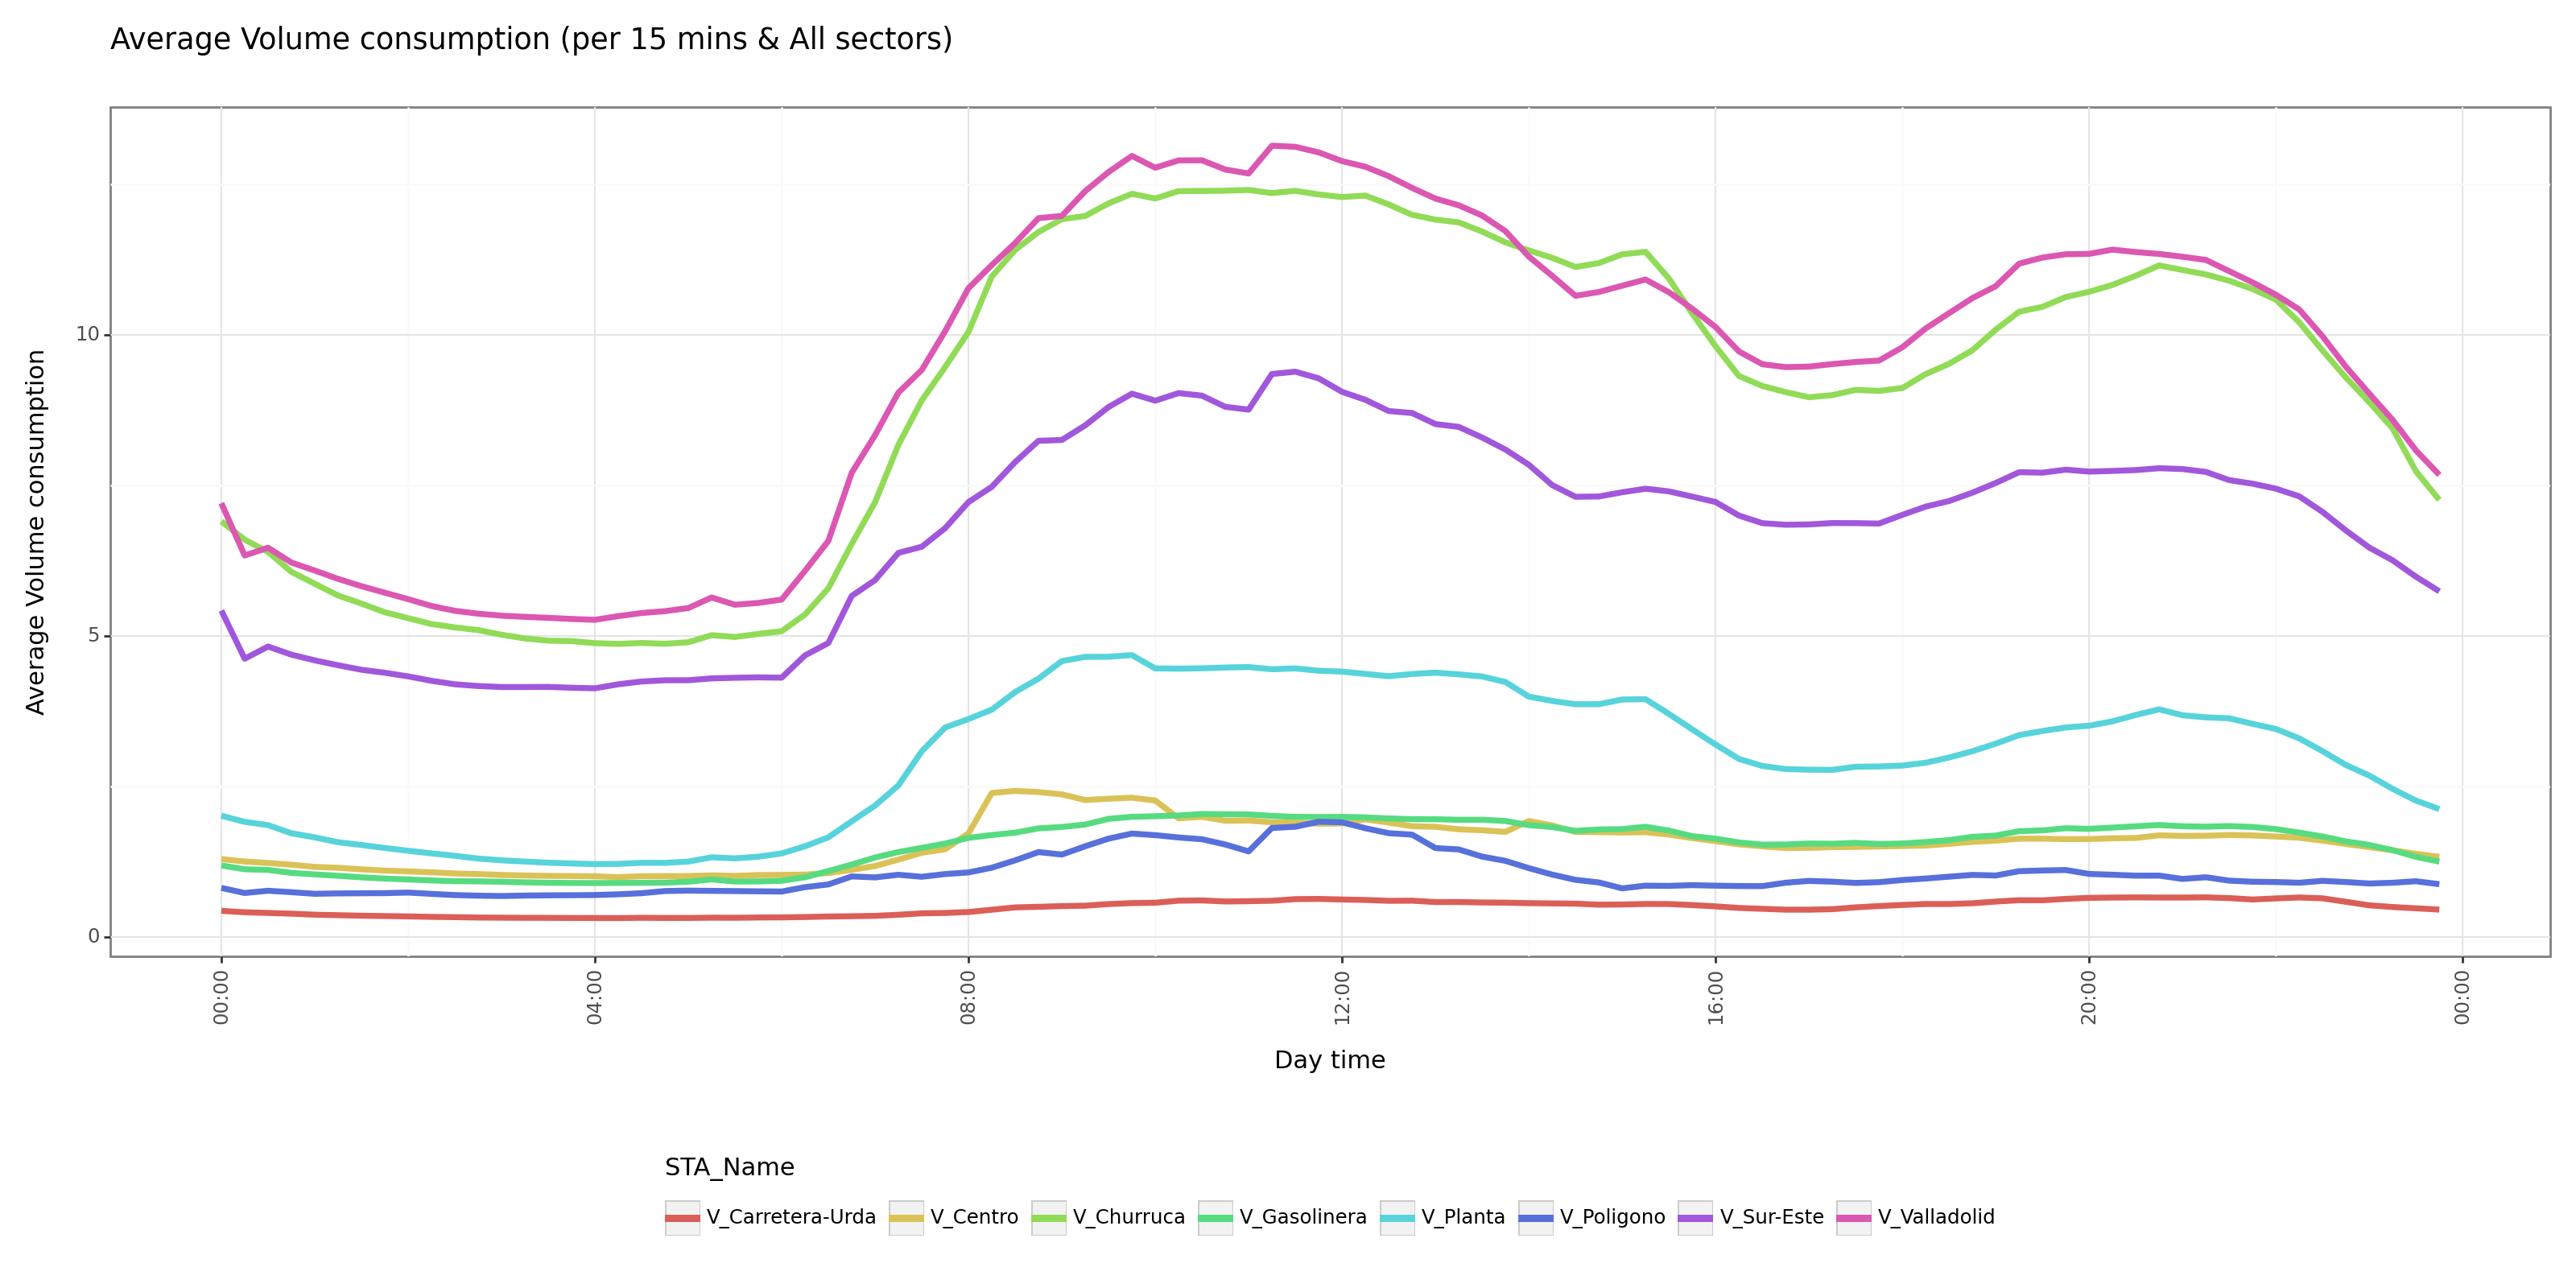

<Figure Size: (1600 x 800)>

In [ ]:
(ggplot(df_viz)
  + aes(x='RowKey_Time', y='INF_Value', group='STA_Name', color='STA_Name')
  + geom_line(size=1.5)
  + ggtitle('Average Volume consumption (per 15 mins & All sectors)')
  + xlab("Day time")
  + ylab("Average Volume consumption")
  + theme_bw()
  + guides(color=guide_legend(nrow=1, order=1, byrow=True))
  + scale_x_datetime(breaks="4 hour", labels=date_format('%H:%M'))
  + theme(legend_position='bottom', legend_box='horizontal', axis_text_x=element_text(rotation=90), figure_size=(16, 8))
)

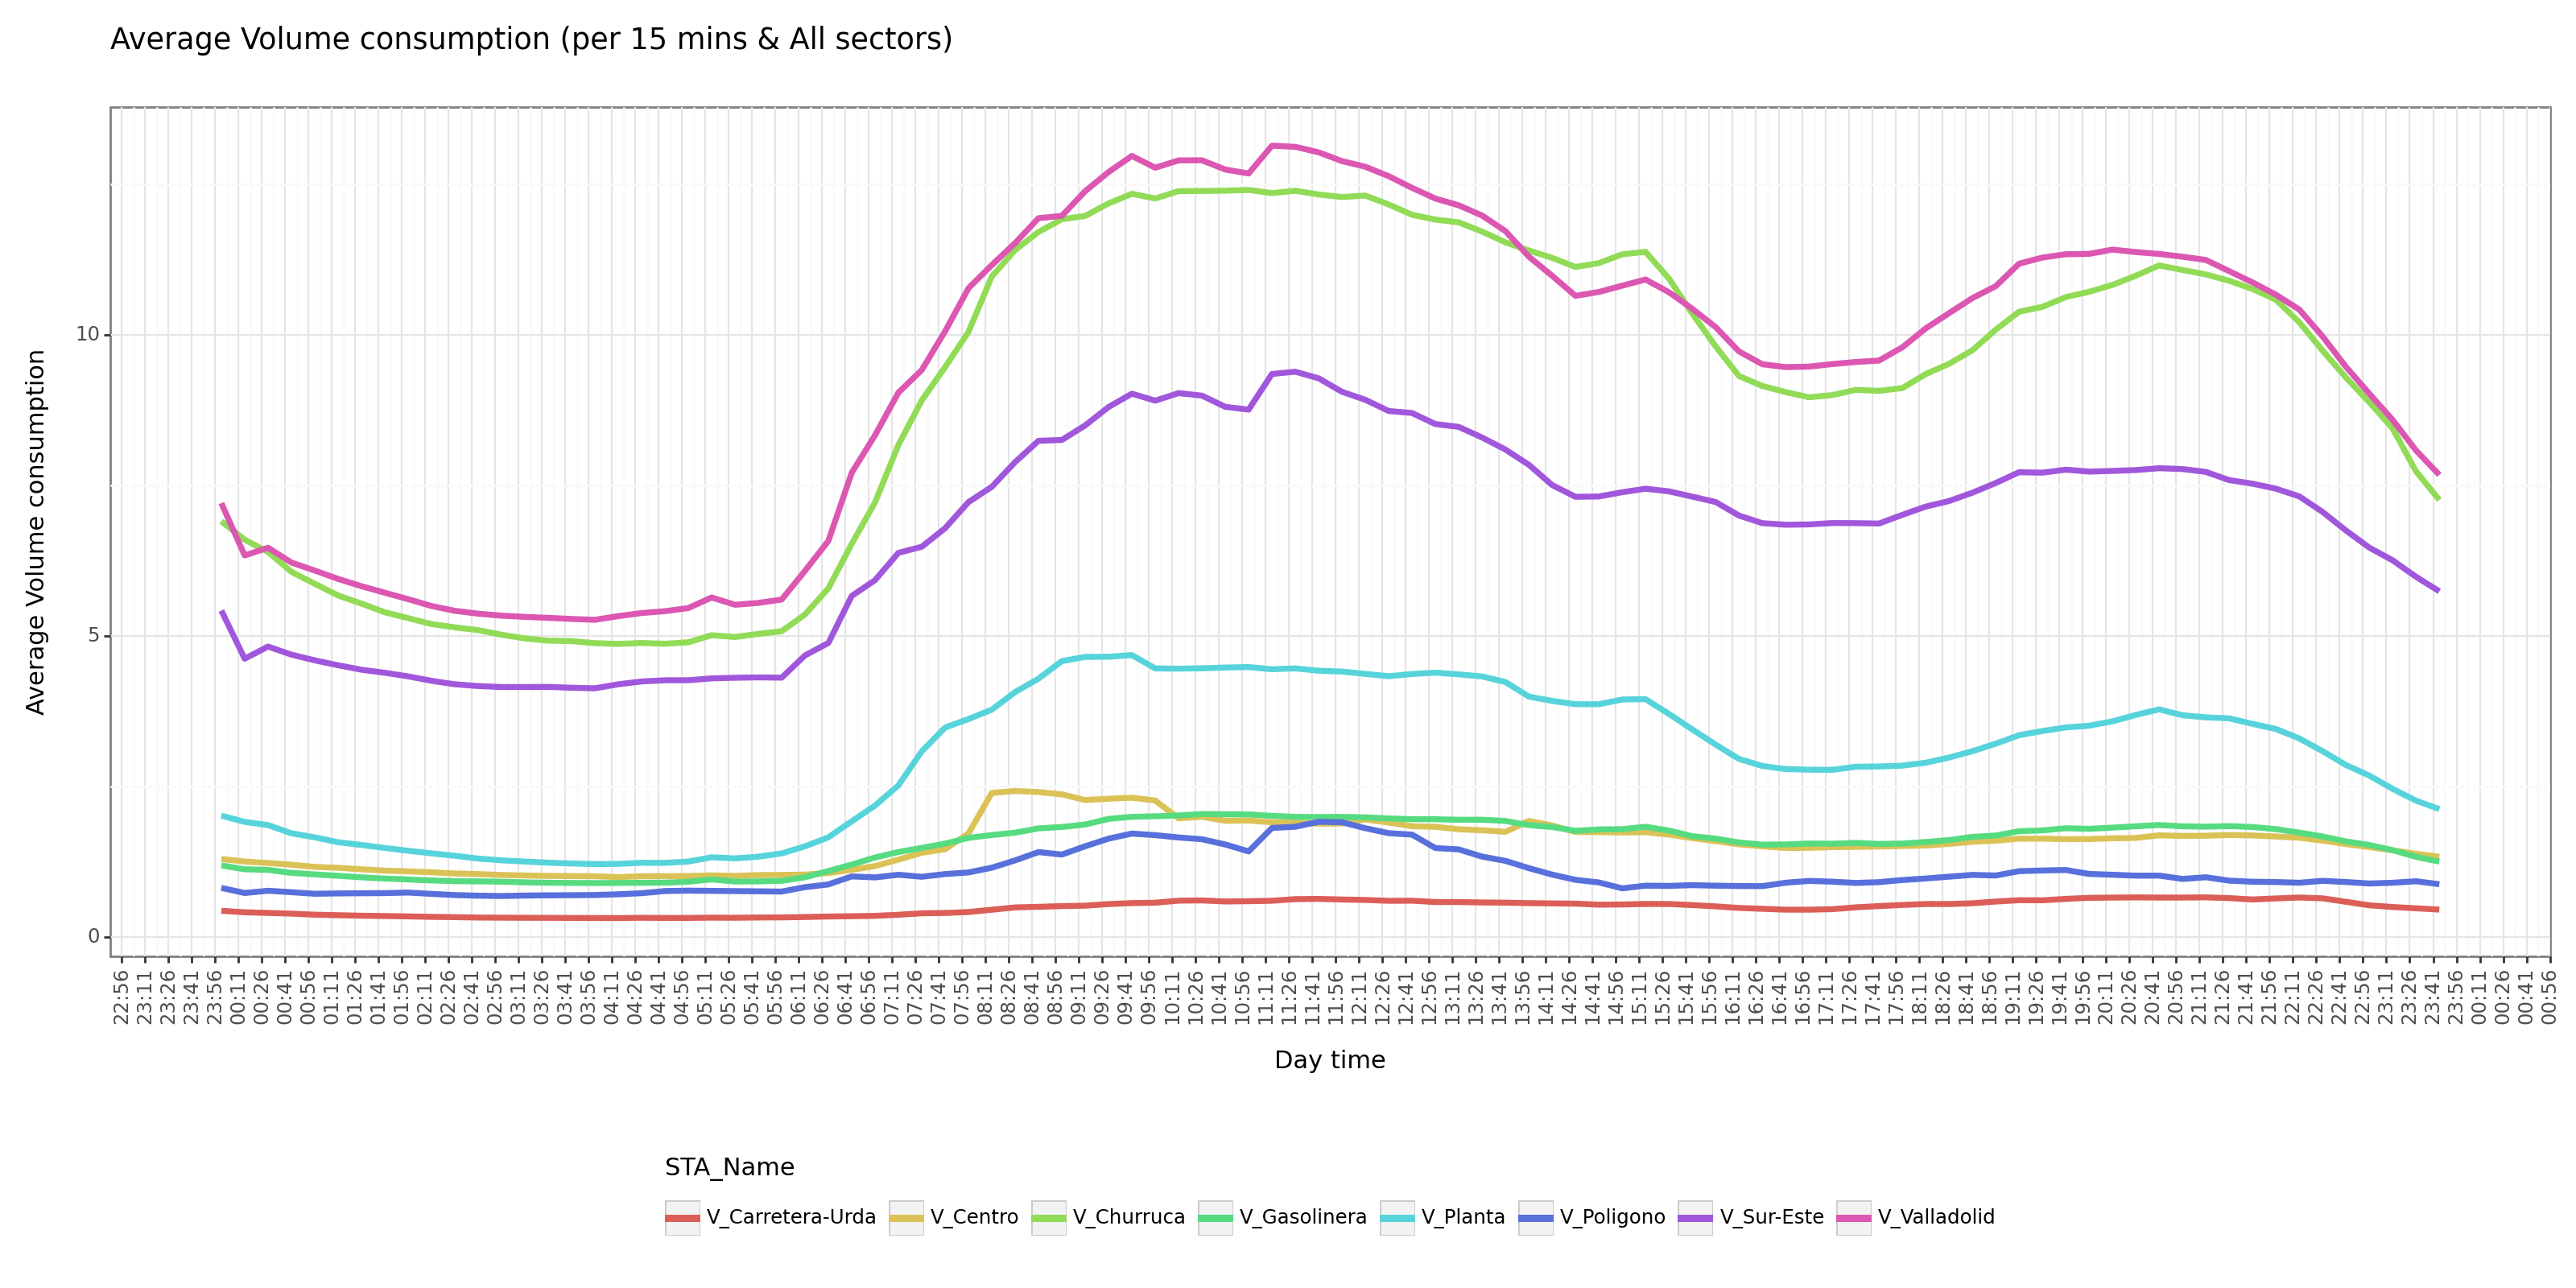

<Figure Size: (1600 x 800)>

In [ ]:
(ggplot(df_viz)
  + aes(x='RowKey_Time', y='INF_Value', group='STA_Name', color='STA_Name')
  + geom_line(size=1.5)
  + ggtitle('Average Volume consumption (per 15 mins & All sectors)')
  + xlab("Day time")
  + ylab("Average Volume consumption")
  + theme_bw()
  + guides(color=guide_legend(nrow=1, order=1, byrow=True))
  + scale_x_datetime(breaks="15 minutes", labels=date_format('%H:%M'))
  + theme(legend_position='bottom', legend_box='horizontal', axis_text_x=element_text(rotation=90), figure_size=(16, 8))
)

### Average Volume consumption (per day & All sectors)

In [ ]:
df_data = df_1mins76.groupby('DiaSem')[target_vars].mean()
df_data.reset_index(drop=False, inplace=True)
df_data.head()

DiaSem  V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0    Domingo              0.55      1.57        9.31          1.54      2.93   
1     Jueves              0.47      1.49        8.95          1.52      3.01   
2      Lunes              0.48      1.54        9.12          1.54      3.01   
3     Martes              0.46      1.52        8.98          1.50      2.97   
4  Miercoles              0.48      1.50        8.79          1.50      3.01   

   V_Poligono  V_Sur-Este  V_Valladolid  
0        0.99        6.82          9.67  
1        1.03        6.68          9.45  
2        1.02        6.67          9.44  
3        1.04        6.61          9.22  
4        1.03        6.60          9.22

In [ ]:
df_viz = df_cols2rows(df_data,'DiaSem')
df_viz.head()

DiaSem  INF_Value          STA_Name
0    Domingo       0.55  V_Carretera-Urda
1     Jueves       0.47  V_Carretera-Urda
2      Lunes       0.48  V_Carretera-Urda
3     Martes       0.46  V_Carretera-Urda
4  Miercoles       0.48  V_Carretera-Urda

In [ ]:
x = 'DiaSem'
df_viz[x] = df_viz[x].apply(lambda x: str(x))
df_viz[x].unique()

array(['Domingo', 'Jueves', 'Lunes', 'Martes', 'Miercoles', 'Sabado',
       'Viernes'], dtype=object)

In [ ]:
# Formatting column
df_viz[x] = df_viz[x].apply(lambda x: str(x))
order = ['Lunes', 'Martes', 'Miercoles', 'Jueves','Viernes', 'Sabado','Domingo']
data = df_viz[x]
df_viz[x] = pd.Categorical(data, order, ordered=True)

In [ ]:
df_viz['STA_Name'].unique()

array(['V_Carretera-Urda', 'V_Centro', 'V_Churruca', 'V_Gasolinera',
       'V_Planta', 'V_Poligono', 'V_Sur-Este', 'V_Valladolid'],
      dtype=object)

In [ ]:
'V_Churruca', 'V_Sur-Este', 'V_Valladolid'

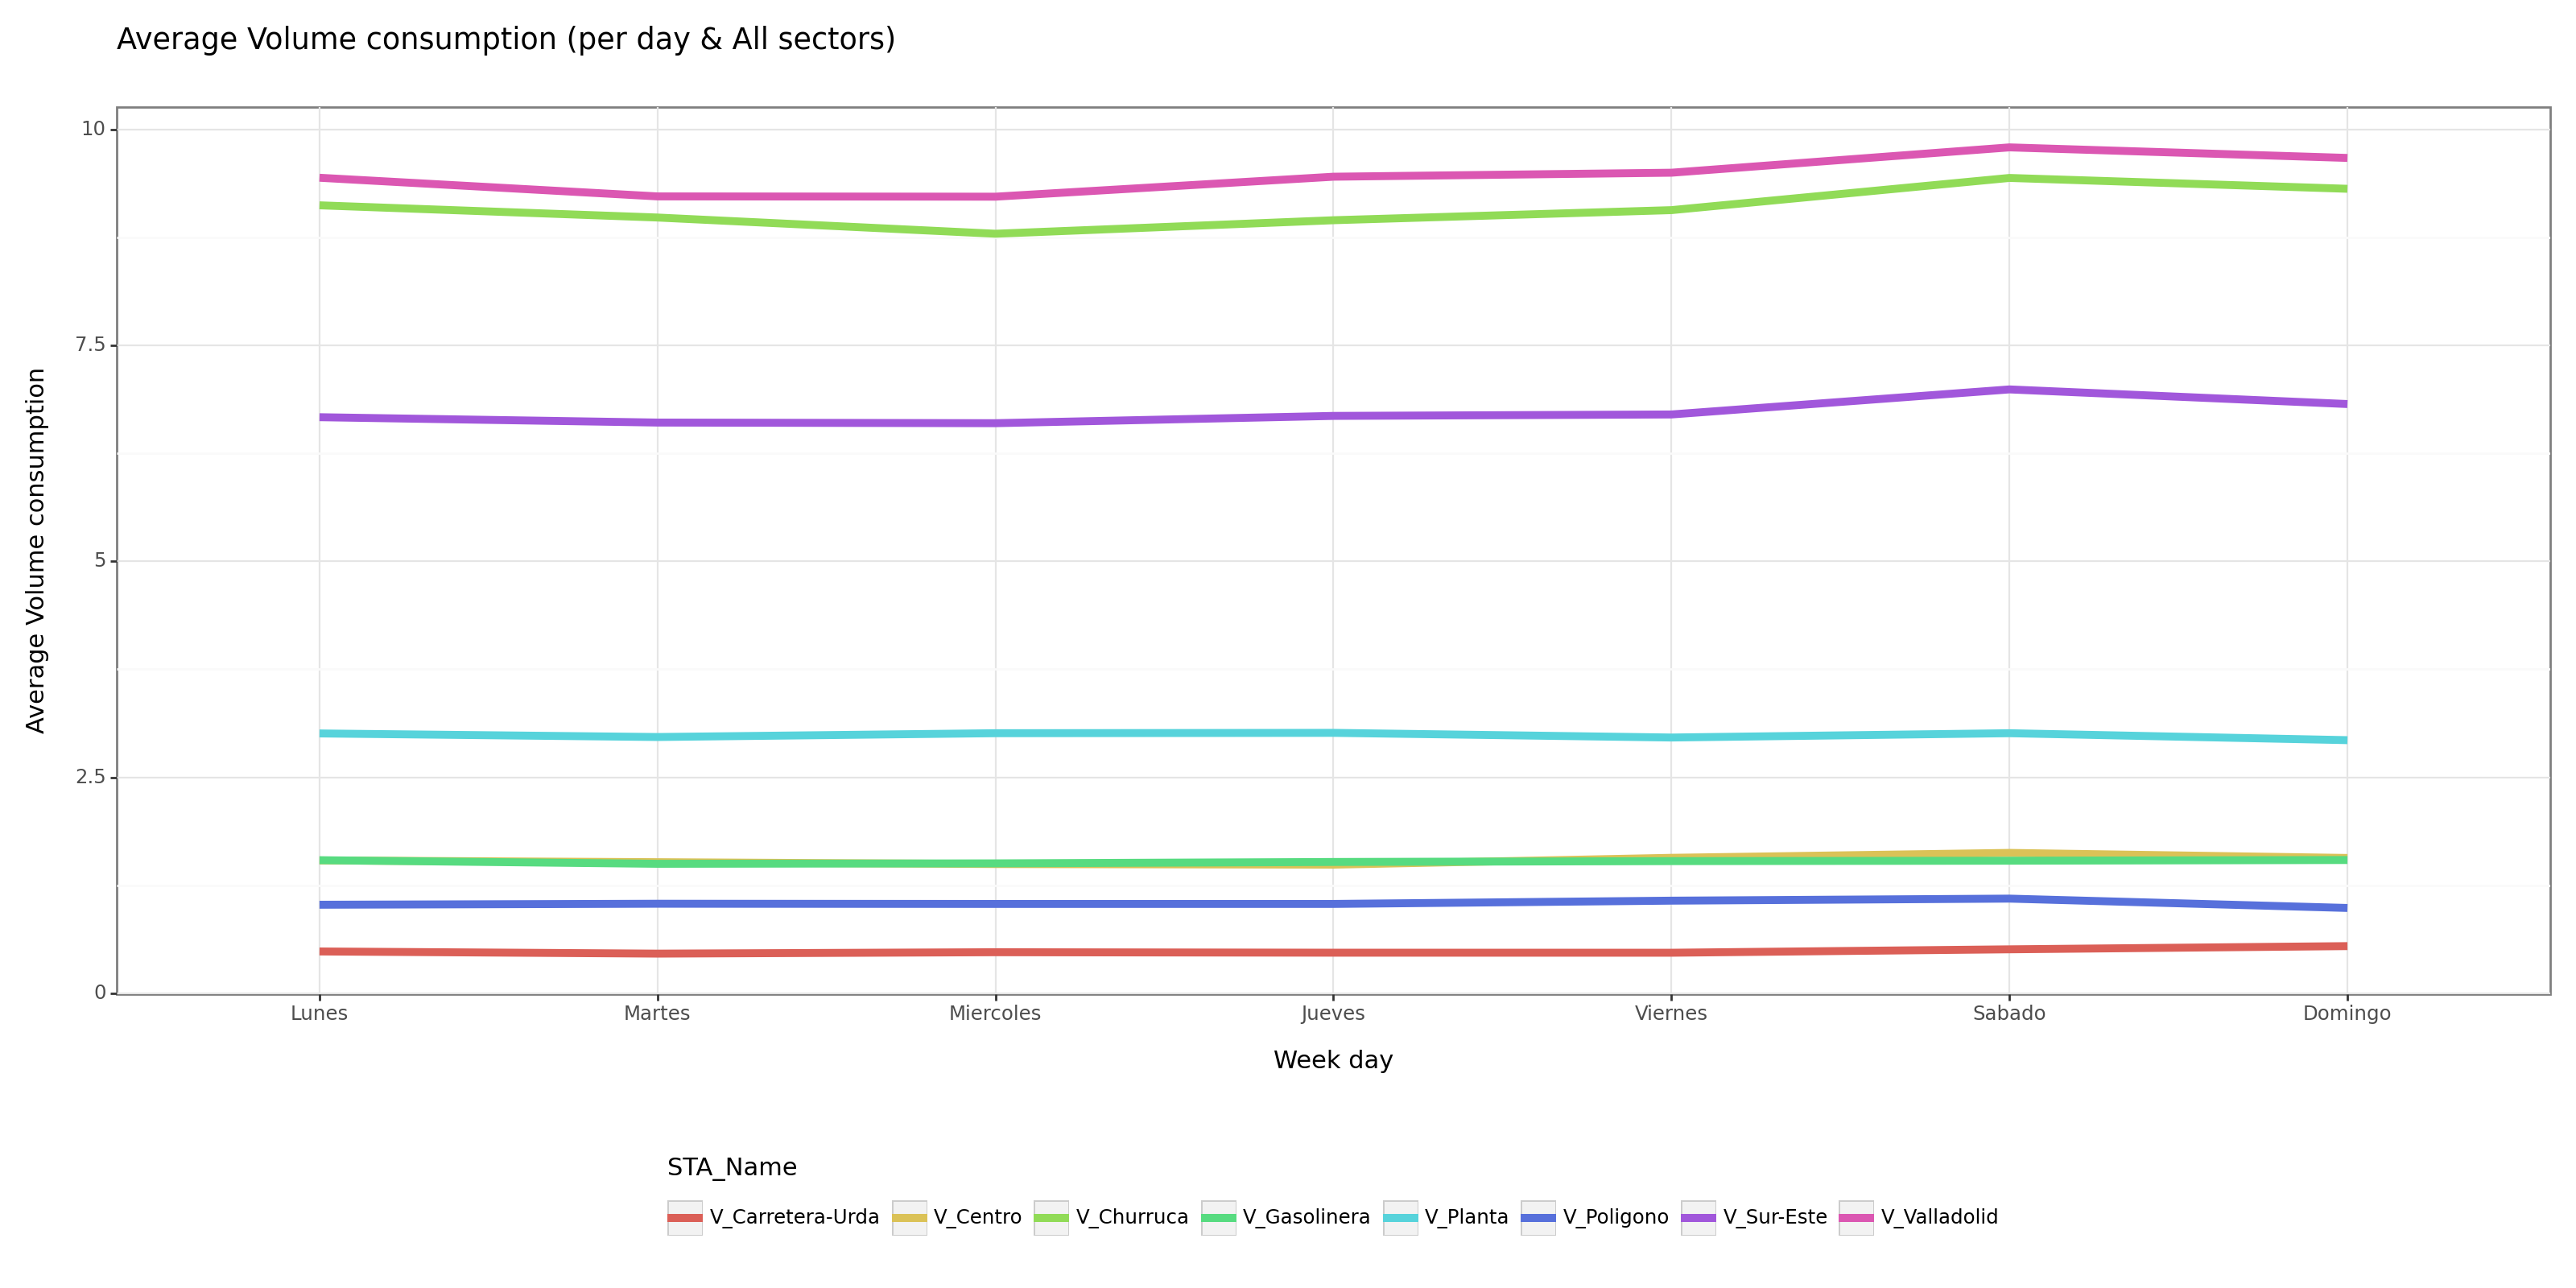

<Figure Size: (1600 x 800)>

In [ ]:
(ggplot(df_viz)
  + aes(x='DiaSem', y='INF_Value', group='STA_Name', color='STA_Name')
  + geom_line(size=2)
  + ggtitle('Average Volume consumption (per day & All sectors)')
  + xlab("Week day")
  + ylab("Average Volume consumption")
  + theme_bw()
  + guides(color=guide_legend(nrow=1, order=1, byrow=True))
  + theme(legend_position='bottom', legend_box='horizontal', axis_text_x=element_text(rotation=0), figure_size=(16, 8))
)

### Average Volume consumption (per month & All sectors)

In [ ]:
df_data = df_1mins76.groupby('N_Mes')[target_vars].mean()
df_data.reset_index(drop=False, inplace=True)
df_data.head()

N_Mes  V_Carretera-Urda  V_Centro  V_Churruca  V_Gasolinera  V_Planta  \
0      1              0.45      0.00       11.70          0.80      0.02   
1      2              2.02      0.00       10.74          1.05      0.07   
2      3              1.91      0.00        9.74          1.37      0.08   
3      4              0.59      1.55       10.21          1.29      3.04   
4      5              0.25      1.68       11.34          0.97      2.86   

   V_Poligono  V_Sur-Este  V_Valladolid  
0        0.73        5.99          7.77  
1        0.68        5.80          7.92  
2        0.60        5.88          8.28  
3        0.61        5.94          8.42  
4        0.86        5.17          5.16

In [ ]:
df_viz = df_cols2rows(df_data,'N_Mes')
df_viz['N_Mes'] = df_viz['N_Mes'].astype('str')
df_viz.head()

N_Mes  INF_Value          STA_Name
0     1       0.45  V_Carretera-Urda
1     2       2.02  V_Carretera-Urda
2     3       1.91  V_Carretera-Urda
3     4       0.59  V_Carretera-Urda
4     5       0.25  V_Carretera-Urda

In [ ]:
x = 'N_Mes'
df_viz[x] = df_viz[x].apply(lambda x: str(x))
df_viz[x].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [ ]:
# Formatting column
df_viz[x] = df_viz[x].apply(lambda x: str(x))
order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
data = df_viz[x]
df_viz[x] = pd.Categorical(data, order, ordered=True)

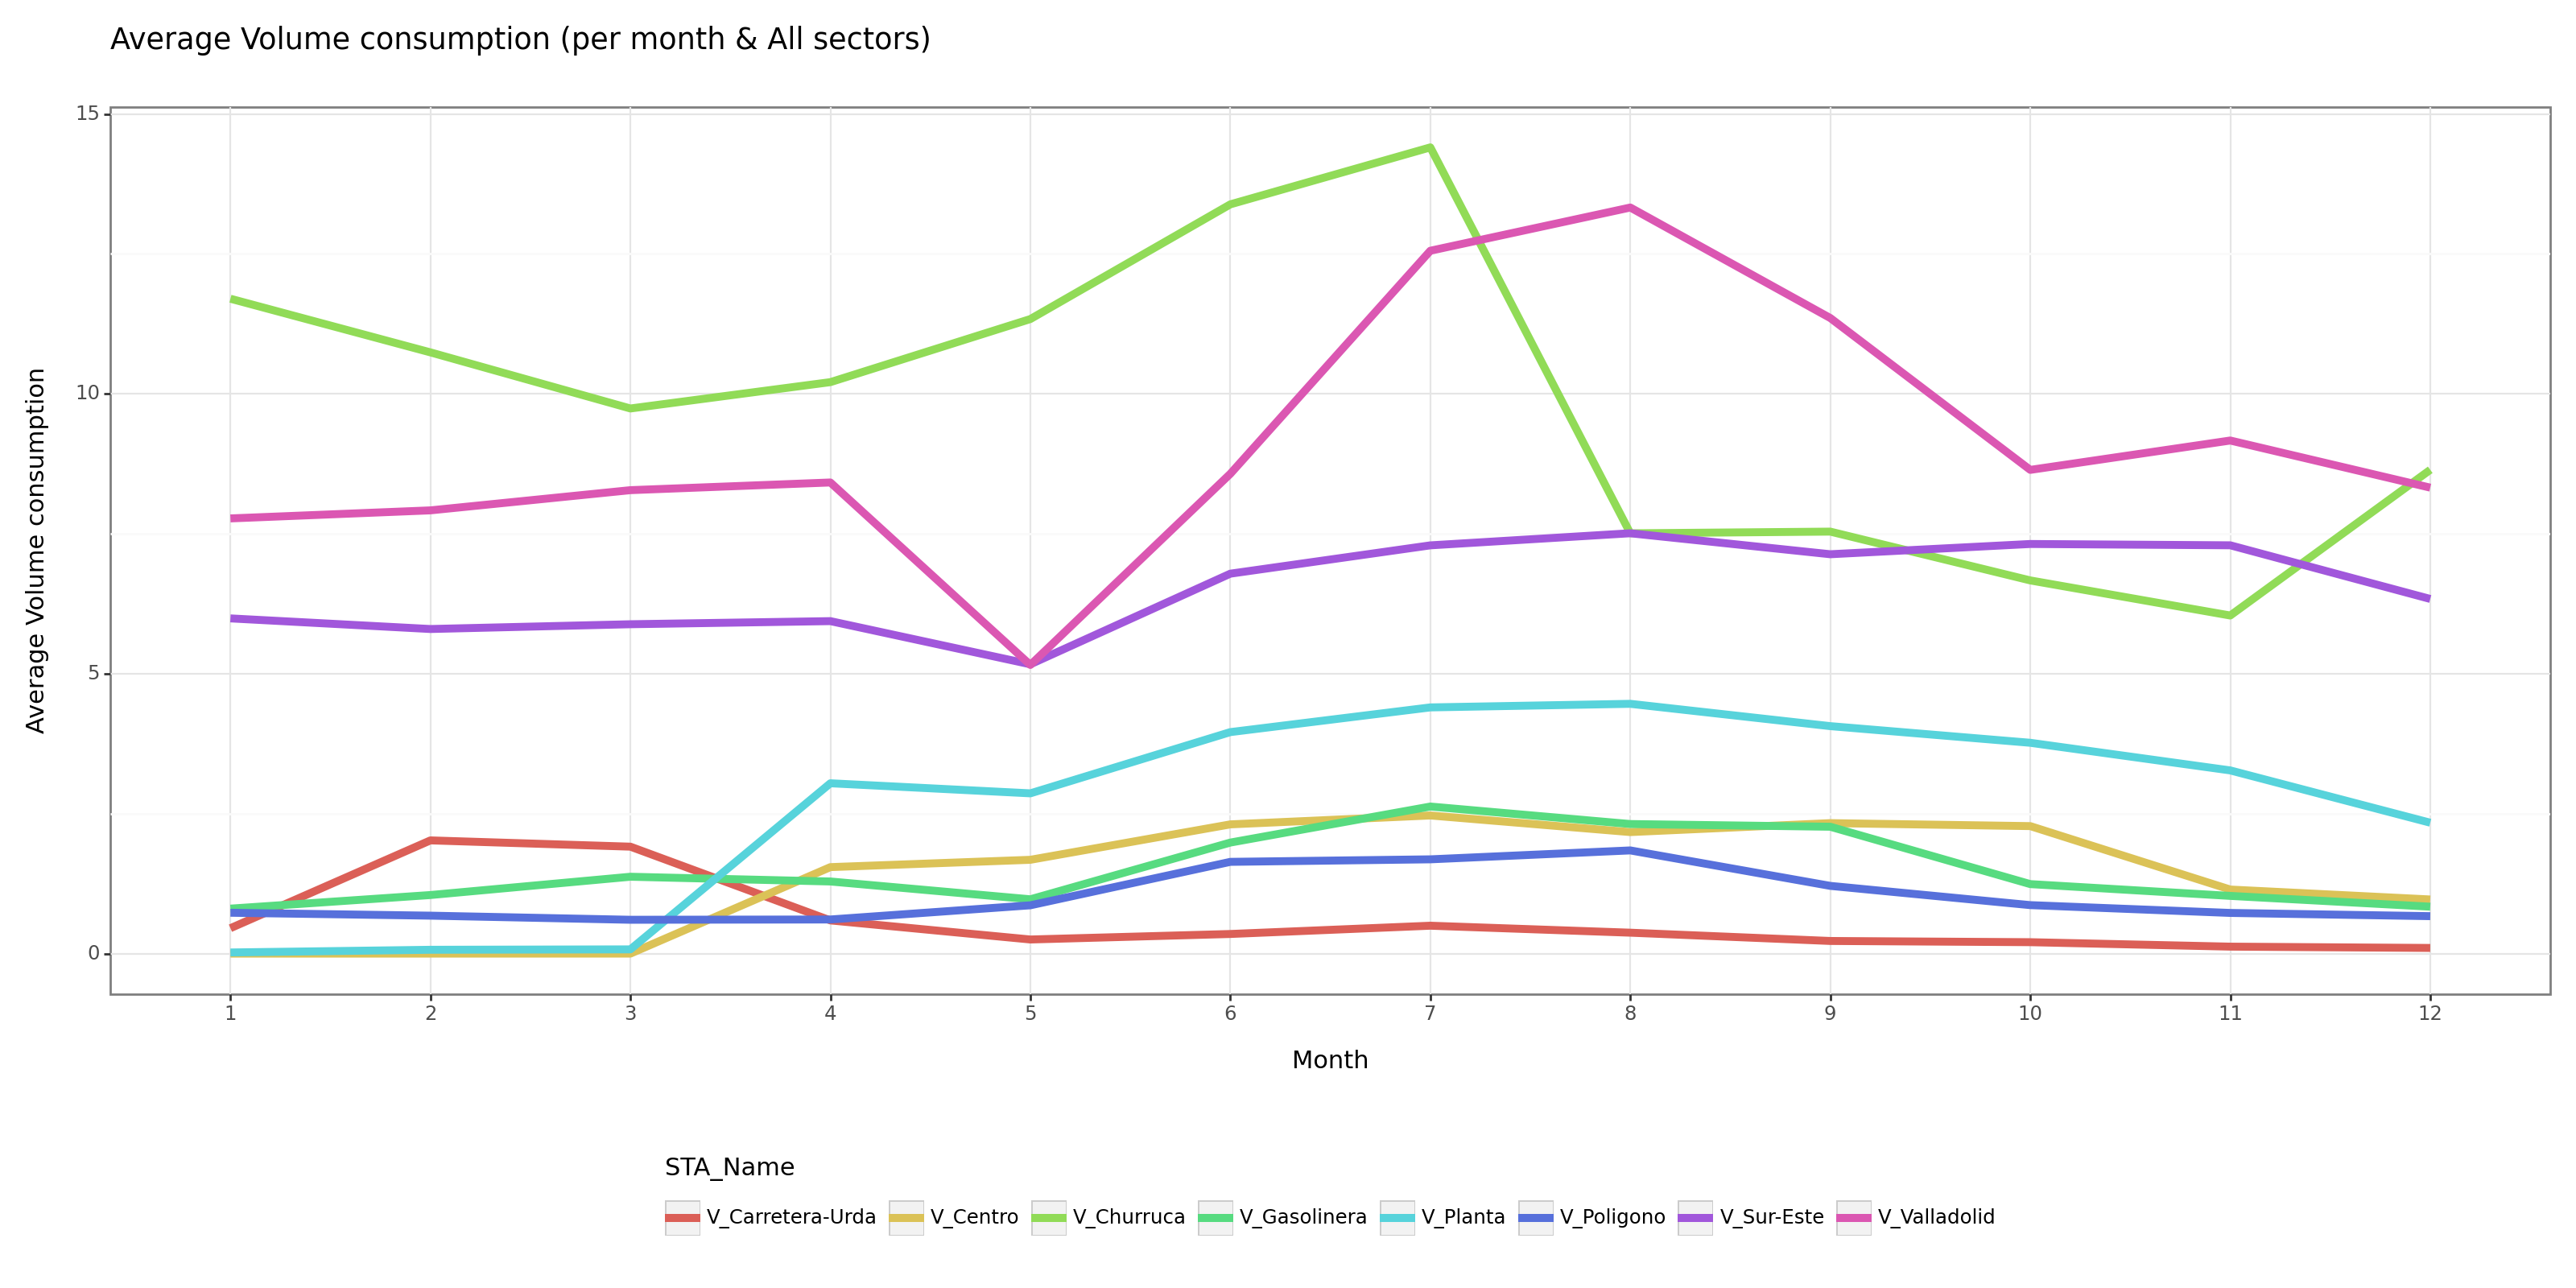

<Figure Size: (1600 x 800)>

In [ ]:
(ggplot(df_viz)
  + aes(x='N_Mes', y='INF_Value', group='STA_Name', color='STA_Name')
  + geom_line(size=2)
  + ggtitle('Average Volume consumption (per month & All sectors)')
  + xlab("Month")
  + ylab("Average Volume consumption")
  + theme_bw()
  + guides(color=guide_legend(nrow=1, order=1, byrow=True))
  + theme(legend_position='bottom', legend_box='horizontal', axis_text_x=element_text(rotation=0), figure_size=(16, 8))
)